In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, labels=next_states_labels)
    eloss = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1))
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, labels=next_states_labels)
    eloss += -tf.reduce_mean(tf.reduce_sum(eloss_, axis=1)) # maximize loss
    aloss2_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, labels=next_states_labels)
    aloss2 = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1)) # minimize loss
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    #rewards__ = tf.square(e_next_states_logits - next_states) 
    next_states_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                               labels=next_states_labels)
    rewards_in = tf.reduce_mean(tf.reduce_sum(next_states_loss, axis=1))
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    # eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
    # aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2, rewards_in

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2, self.rewards_in = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            #rewards_in = sess.run(model.rewards_in, feed_dict)
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], feed_dict)
            #print('rewards_in.mean():', rewards_in.mean())
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:14.0000 R:14.0000 rate:0.0280 aloss:0.6872 eloss:2.6139 aloss2:3.3595 exploreP:0.9986
Episode:1 meanR:23.0000 R:32.0000 rate:0.0640 aloss:0.6967 eloss:2.5280 aloss2:3.3783 exploreP:0.9955
Episode:2 meanR:20.6667 R:16.0000 rate:0.0320 aloss:0.6774 eloss:2.5451 aloss2:3.3832 exploreP:0.9939
Episode:3 meanR:20.7500 R:21.0000 rate:0.0420 aloss:0.6887 eloss:2.5078 aloss2:3.4116 exploreP:0.9918
Episode:4 meanR:19.4000 R:14.0000 rate:0.0280 aloss:0.6870 eloss:2.6207 aloss2:3.3673 exploreP:0.9904
Episode:5 meanR:20.0000 R:23.0000 rate:0.0460 aloss:0.6780 eloss:2.4866 aloss2:3.4105 exploreP:0.9882
Episode:6 meanR:20.2857 R:22.0000 rate:0.0440 aloss:0.6810 eloss:2.4846 aloss2:3.4174 exploreP:0.9860
Episode:7 meanR:19.3750 R:13.0000 rate:0.0260 aloss:0.6853 eloss:2.5292 aloss2:3.4020 exploreP:0.9848
Episode:8 meanR:21.3333 R:37.0000 rate:0.0740 aloss:0.7027 eloss:2.4692 aloss2:3.4578 exploreP:0.9812
Episode:9 meanR:21.3000 R:21.0000 rate:0.0420 aloss:0.6852 eloss:2.4972 aloss2:3.4

Episode:80 meanR:26.6173 R:18.0000 rate:0.0360 aloss:0.6892 eloss:0.9094 aloss2:5.1986 exploreP:0.8080
Episode:81 meanR:26.5732 R:23.0000 rate:0.0460 aloss:0.6964 eloss:0.9334 aloss2:5.0450 exploreP:0.8062
Episode:82 meanR:26.8916 R:53.0000 rate:0.1060 aloss:0.6894 eloss:0.9245 aloss2:5.1599 exploreP:0.8020
Episode:83 meanR:26.7738 R:17.0000 rate:0.0340 aloss:0.6778 eloss:0.8448 aloss2:5.2184 exploreP:0.8006
Episode:84 meanR:26.7176 R:22.0000 rate:0.0440 aloss:0.6865 eloss:0.7917 aloss2:5.3154 exploreP:0.7989
Episode:85 meanR:26.7093 R:26.0000 rate:0.0520 aloss:0.6838 eloss:0.6837 aloss2:5.5146 exploreP:0.7968
Episode:86 meanR:26.5747 R:15.0000 rate:0.0300 aloss:0.6804 eloss:0.7097 aloss2:5.3804 exploreP:0.7956
Episode:87 meanR:26.5000 R:20.0000 rate:0.0400 aloss:0.6865 eloss:0.6046 aloss2:5.5819 exploreP:0.7941
Episode:88 meanR:26.5730 R:33.0000 rate:0.0660 aloss:0.6923 eloss:0.5444 aloss2:5.6408 exploreP:0.7915
Episode:89 meanR:26.7000 R:38.0000 rate:0.0760 aloss:0.7211 eloss:0.5865 

Episode:159 meanR:35.8400 R:20.0000 rate:0.0400 aloss:0.7230 eloss:-2.2243 aloss2:12.9009 exploreP:0.6083
Episode:160 meanR:36.5300 R:84.0000 rate:0.1680 aloss:0.7041 eloss:-2.4821 aloss2:13.3171 exploreP:0.6033
Episode:161 meanR:36.4800 R:28.0000 rate:0.0560 aloss:0.7134 eloss:-1.9957 aloss2:14.1051 exploreP:0.6016
Episode:162 meanR:36.1000 R:14.0000 rate:0.0280 aloss:0.7403 eloss:-2.1463 aloss2:12.7023 exploreP:0.6008
Episode:163 meanR:36.0800 R:19.0000 rate:0.0380 aloss:0.7032 eloss:-2.3470 aloss2:12.8390 exploreP:0.5997
Episode:164 meanR:35.9900 R:15.0000 rate:0.0300 aloss:0.6999 eloss:-2.5278 aloss2:14.6648 exploreP:0.5988
Episode:165 meanR:35.7900 R:20.0000 rate:0.0400 aloss:0.7394 eloss:-2.4600 aloss2:13.7073 exploreP:0.5976
Episode:166 meanR:36.4200 R:92.0000 rate:0.1840 aloss:0.7201 eloss:-2.8527 aloss2:14.0589 exploreP:0.5923
Episode:167 meanR:36.5800 R:53.0000 rate:0.1060 aloss:0.7071 eloss:-3.0393 aloss2:14.8091 exploreP:0.5892
Episode:168 meanR:37.5300 R:129.0000 rate:0.25

Episode:237 meanR:99.6200 R:500.0000 rate:1.0000 aloss:0.7573 eloss:-5.9517 aloss2:42.1622 exploreP:0.2528
Episode:238 meanR:99.6800 R:45.0000 rate:0.0900 aloss:0.7619 eloss:-7.2690 aloss2:41.0695 exploreP:0.2517
Episode:239 meanR:100.8000 R:206.0000 rate:0.4120 aloss:0.7891 eloss:-5.2144 aloss2:42.5558 exploreP:0.2468
Episode:240 meanR:105.3900 R:500.0000 rate:1.0000 aloss:0.7617 eloss:-5.8845 aloss2:42.5483 exploreP:0.2352
Episode:241 meanR:110.2100 R:500.0000 rate:1.0000 aloss:0.7763 eloss:-6.3777 aloss2:42.7912 exploreP:0.2243
Episode:242 meanR:113.6900 R:390.0000 rate:0.7800 aloss:0.7554 eloss:-6.4132 aloss2:43.3169 exploreP:0.2161
Episode:243 meanR:113.8400 R:46.0000 rate:0.0920 aloss:0.7458 eloss:-7.1047 aloss2:43.4836 exploreP:0.2151
Episode:244 meanR:113.9700 R:61.0000 rate:0.1220 aloss:0.7743 eloss:-4.7049 aloss2:43.8792 exploreP:0.2139
Episode:245 meanR:115.5100 R:171.0000 rate:0.3420 aloss:0.7587 eloss:-7.0111 aloss2:43.6499 exploreP:0.2104
Episode:246 meanR:116.5900 R:177.

Episode:313 meanR:392.1200 R:500.0000 rate:1.0000 aloss:0.6797 eloss:-4.6096 aloss2:49.0945 exploreP:0.0186
Episode:314 meanR:396.5800 R:500.0000 rate:1.0000 aloss:0.6628 eloss:-4.0265 aloss2:49.2398 exploreP:0.0182
Episode:315 meanR:396.5800 R:500.0000 rate:1.0000 aloss:0.6579 eloss:-3.9381 aloss2:49.3119 exploreP:0.0178
Episode:316 meanR:399.7500 R:500.0000 rate:1.0000 aloss:0.6416 eloss:-3.6328 aloss2:49.4997 exploreP:0.0174
Episode:317 meanR:403.0800 R:461.0000 rate:0.9220 aloss:0.6528 eloss:-3.8258 aloss2:49.2794 exploreP:0.0171
Episode:318 meanR:407.0500 R:500.0000 rate:1.0000 aloss:0.6469 eloss:-2.7565 aloss2:49.1038 exploreP:0.0168
Episode:319 meanR:410.1600 R:477.0000 rate:0.9540 aloss:0.6585 eloss:-3.5319 aloss2:48.5137 exploreP:0.0164
Episode:320 meanR:412.5000 R:388.0000 rate:0.7760 aloss:0.6321 eloss:-2.5443 aloss2:48.5091 exploreP:0.0162
Episode:321 meanR:417.2800 R:500.0000 rate:1.0000 aloss:0.6408 eloss:-3.5751 aloss2:48.3072 exploreP:0.0159
Episode:322 meanR:418.8900 R

Episode:389 meanR:472.7900 R:500.0000 rate:1.0000 aloss:0.5350 eloss:-0.5226 aloss2:40.9297 exploreP:0.0103
Episode:390 meanR:472.7900 R:500.0000 rate:1.0000 aloss:0.5216 eloss:-0.3190 aloss2:40.5494 exploreP:0.0102
Episode:391 meanR:472.7900 R:500.0000 rate:1.0000 aloss:0.5251 eloss:0.1777 aloss2:39.7539 exploreP:0.0102
Episode:392 meanR:472.7900 R:500.0000 rate:1.0000 aloss:0.5425 eloss:-0.5233 aloss2:39.4972 exploreP:0.0102
Episode:393 meanR:472.7900 R:500.0000 rate:1.0000 aloss:0.5332 eloss:-0.4703 aloss2:39.2469 exploreP:0.0102
Episode:394 meanR:470.1700 R:238.0000 rate:0.4760 aloss:0.5224 eloss:-0.2618 aloss2:39.1316 exploreP:0.0102
Episode:395 meanR:467.5100 R:234.0000 rate:0.4680 aloss:0.5412 eloss:-0.7267 aloss2:39.1262 exploreP:0.0102
Episode:396 meanR:464.6500 R:214.0000 rate:0.4280 aloss:0.5306 eloss:-0.7190 aloss2:39.2239 exploreP:0.0102
Episode:397 meanR:464.6500 R:500.0000 rate:1.0000 aloss:0.5342 eloss:-0.4103 aloss2:39.3129 exploreP:0.0102
Episode:398 meanR:461.9700 R:

Episode:466 meanR:448.0400 R:500.0000 rate:1.0000 aloss:0.4366 eloss:-0.0664 aloss2:13.2874 exploreP:0.0100
Episode:467 meanR:448.0400 R:500.0000 rate:1.0000 aloss:0.4291 eloss:-0.2120 aloss2:13.9697 exploreP:0.0100
Episode:468 meanR:444.5600 R:152.0000 rate:0.3040 aloss:0.4298 eloss:0.0353 aloss2:13.5606 exploreP:0.0100
Episode:469 meanR:444.5600 R:500.0000 rate:1.0000 aloss:0.4329 eloss:-0.2034 aloss2:13.6941 exploreP:0.0100
Episode:470 meanR:443.8400 R:428.0000 rate:0.8560 aloss:0.4282 eloss:-0.3214 aloss2:14.3596 exploreP:0.0100
Episode:471 meanR:447.2800 R:500.0000 rate:1.0000 aloss:0.4365 eloss:-0.2781 aloss2:14.1039 exploreP:0.0100
Episode:472 meanR:447.2800 R:500.0000 rate:1.0000 aloss:0.4351 eloss:-0.4288 aloss2:14.7097 exploreP:0.0100
Episode:473 meanR:447.2800 R:500.0000 rate:1.0000 aloss:0.4350 eloss:-0.4576 aloss2:14.7860 exploreP:0.0100
Episode:474 meanR:447.2800 R:500.0000 rate:1.0000 aloss:0.4354 eloss:-0.4703 aloss2:14.7872 exploreP:0.0100
Episode:475 meanR:447.2800 R:

Episode:543 meanR:339.7700 R:203.0000 rate:0.4060 aloss:0.4560 eloss:-2.3526 aloss2:22.1843 exploreP:0.0100
Episode:544 meanR:334.9500 R:18.0000 rate:0.0360 aloss:0.4797 eloss:-2.0812 aloss2:21.9316 exploreP:0.0100
Episode:545 meanR:334.1200 R:114.0000 rate:0.2280 aloss:0.4657 eloss:-2.3271 aloss2:22.2953 exploreP:0.0100
Episode:546 meanR:333.2500 R:413.0000 rate:0.8260 aloss:0.4599 eloss:-2.6290 aloss2:22.8469 exploreP:0.0100
Episode:547 meanR:333.2500 R:500.0000 rate:1.0000 aloss:0.4579 eloss:-2.5161 aloss2:22.9897 exploreP:0.0100
Episode:548 meanR:328.7400 R:49.0000 rate:0.0980 aloss:0.4387 eloss:-2.7460 aloss2:22.9360 exploreP:0.0100
Episode:549 meanR:328.7400 R:500.0000 rate:1.0000 aloss:0.4574 eloss:-2.6827 aloss2:23.2041 exploreP:0.0100
Episode:550 meanR:323.8600 R:12.0000 rate:0.0240 aloss:0.4824 eloss:-2.4152 aloss2:22.9868 exploreP:0.0100
Episode:551 meanR:319.1300 R:27.0000 rate:0.0540 aloss:0.4662 eloss:-2.8448 aloss2:23.3632 exploreP:0.0100
Episode:552 meanR:314.4000 R:27.

Episode:620 meanR:271.8900 R:179.0000 rate:0.3580 aloss:0.4108 eloss:-8.1827 aloss2:37.3198 exploreP:0.0100
Episode:621 meanR:270.5900 R:41.0000 rate:0.0820 aloss:0.4173 eloss:-9.5304 aloss2:38.8767 exploreP:0.0100
Episode:622 meanR:270.5900 R:500.0000 rate:1.0000 aloss:0.4155 eloss:-8.1592 aloss2:37.6870 exploreP:0.0100
Episode:623 meanR:275.3900 R:500.0000 rate:1.0000 aloss:0.4213 eloss:-8.1081 aloss2:37.9710 exploreP:0.0100
Episode:624 meanR:273.5400 R:315.0000 rate:0.6300 aloss:0.4141 eloss:-7.9810 aloss2:37.8771 exploreP:0.0100
Episode:625 meanR:275.3300 R:500.0000 rate:1.0000 aloss:0.4145 eloss:-8.4979 aloss2:38.7225 exploreP:0.0100
Episode:626 meanR:271.7800 R:145.0000 rate:0.2900 aloss:0.4138 eloss:-8.5274 aloss2:39.0617 exploreP:0.0100
Episode:627 meanR:271.7800 R:500.0000 rate:1.0000 aloss:0.4154 eloss:-8.4567 aloss2:39.1903 exploreP:0.0100
Episode:628 meanR:270.9800 R:21.0000 rate:0.0420 aloss:0.4284 eloss:-10.7062 aloss2:41.7521 exploreP:0.0100
Episode:629 meanR:271.5400 R:

Episode:696 meanR:307.5800 R:25.0000 rate:0.0500 aloss:0.4009 eloss:-20.0874 aloss2:64.0451 exploreP:0.0100
Episode:697 meanR:312.4800 R:500.0000 rate:1.0000 aloss:0.3770 eloss:-16.6848 aloss2:60.2727 exploreP:0.0100
Episode:698 meanR:315.9700 R:359.0000 rate:0.7180 aloss:0.3740 eloss:-16.1611 aloss2:59.7821 exploreP:0.0100
Episode:699 meanR:311.2000 R:23.0000 rate:0.0460 aloss:0.3737 eloss:-18.4815 aloss2:62.6288 exploreP:0.0100
Episode:700 meanR:306.6100 R:41.0000 rate:0.0820 aloss:0.3825 eloss:-16.4450 aloss2:60.2302 exploreP:0.0100
Episode:701 meanR:306.1300 R:17.0000 rate:0.0340 aloss:0.3752 eloss:-19.9717 aloss2:64.0124 exploreP:0.0100
Episode:702 meanR:310.5200 R:500.0000 rate:1.0000 aloss:0.3738 eloss:-16.7454 aloss2:60.4735 exploreP:0.0100
Episode:703 meanR:311.8200 R:233.0000 rate:0.4660 aloss:0.3755 eloss:-17.1168 aloss2:60.9797 exploreP:0.0100
Episode:704 meanR:316.3300 R:461.0000 rate:0.9220 aloss:0.3808 eloss:-17.7255 aloss2:61.8116 exploreP:0.0100
Episode:705 meanR:315.6

Episode:772 meanR:266.5000 R:19.0000 rate:0.0380 aloss:0.3485 eloss:-20.2617 aloss2:66.7336 exploreP:0.0100
Episode:773 meanR:264.0300 R:253.0000 rate:0.5060 aloss:0.3559 eloss:-20.8829 aloss2:68.0332 exploreP:0.0100
Episode:774 meanR:264.0300 R:500.0000 rate:1.0000 aloss:0.3588 eloss:-25.1370 aloss2:73.9859 exploreP:0.0100
Episode:775 meanR:264.0300 R:500.0000 rate:1.0000 aloss:0.3585 eloss:-21.6476 aloss2:69.5458 exploreP:0.0100
Episode:776 meanR:259.8600 R:83.0000 rate:0.1660 aloss:0.3493 eloss:-21.5862 aloss2:69.2901 exploreP:0.0100
Episode:777 meanR:264.6100 R:500.0000 rate:1.0000 aloss:0.3577 eloss:-23.4450 aloss2:71.6826 exploreP:0.0100
Episode:778 meanR:264.4500 R:39.0000 rate:0.0780 aloss:0.3664 eloss:-27.7215 aloss2:76.4091 exploreP:0.0100
Episode:779 meanR:259.6600 R:21.0000 rate:0.0420 aloss:0.3538 eloss:-21.7054 aloss2:69.1869 exploreP:0.0100
Episode:780 meanR:263.9600 R:440.0000 rate:0.8800 aloss:0.3570 eloss:-20.8036 aloss2:68.4441 exploreP:0.0100
Episode:781 meanR:259.0

Episode:848 meanR:241.8200 R:10.0000 rate:0.0200 aloss:0.3301 eloss:-29.1097 aloss2:85.5446 exploreP:0.0100
Episode:849 meanR:243.0700 R:500.0000 rate:1.0000 aloss:0.3404 eloss:-19.7029 aloss2:74.8624 exploreP:0.0100
Episode:850 meanR:243.3100 R:49.0000 rate:0.0980 aloss:0.3380 eloss:-17.3198 aloss2:72.4640 exploreP:0.0100
Episode:851 meanR:246.3100 R:311.0000 rate:0.6220 aloss:0.3405 eloss:-18.4873 aloss2:73.5975 exploreP:0.0100
Episode:852 meanR:246.3100 R:500.0000 rate:1.0000 aloss:0.3408 eloss:-18.2831 aloss2:73.6557 exploreP:0.0100
Episode:853 meanR:247.3000 R:381.0000 rate:0.7620 aloss:0.3414 eloss:-18.2228 aloss2:73.7943 exploreP:0.0100
Episode:854 meanR:252.1300 R:500.0000 rate:1.0000 aloss:0.3409 eloss:-18.5873 aloss2:74.3280 exploreP:0.0100
Episode:855 meanR:256.0600 R:500.0000 rate:1.0000 aloss:0.3413 eloss:-17.5049 aloss2:73.0896 exploreP:0.0100
Episode:856 meanR:258.0100 R:222.0000 rate:0.4440 aloss:0.3430 eloss:-17.4304 aloss2:72.9352 exploreP:0.0100
Episode:857 meanR:254

Episode:924 meanR:186.5000 R:16.0000 rate:0.0320 aloss:0.3069 eloss:-29.2290 aloss2:92.6300 exploreP:0.0100
Episode:925 meanR:184.9500 R:17.0000 rate:0.0340 aloss:0.3207 eloss:-18.2551 aloss2:84.0745 exploreP:0.0100
Episode:926 meanR:188.0600 R:394.0000 rate:0.7880 aloss:0.3111 eloss:-23.8634 aloss2:89.0308 exploreP:0.0100
Episode:927 meanR:189.1400 R:296.0000 rate:0.5920 aloss:0.3099 eloss:-22.8017 aloss2:89.0066 exploreP:0.0100
Episode:928 meanR:186.2700 R:213.0000 rate:0.4260 aloss:0.3094 eloss:-20.9973 aloss2:87.9606 exploreP:0.0100
Episode:929 meanR:191.1700 R:500.0000 rate:1.0000 aloss:0.3076 eloss:-31.2796 aloss2:97.6328 exploreP:0.0100
Episode:930 meanR:190.3100 R:75.0000 rate:0.1500 aloss:0.3102 eloss:-29.1327 aloss2:95.5038 exploreP:0.0100
Episode:931 meanR:185.5100 R:10.0000 rate:0.0200 aloss:0.3168 eloss:-23.4320 aloss2:88.7298 exploreP:0.0100
Episode:932 meanR:190.4100 R:500.0000 rate:1.0000 aloss:0.3075 eloss:-25.0805 aloss2:91.8363 exploreP:0.0100
Episode:933 meanR:186.6

Episode:1000 meanR:138.0800 R:10.0000 rate:0.0200 aloss:0.2878 eloss:-22.3038 aloss2:101.4942 exploreP:0.0100
Episode:1001 meanR:133.5900 R:10.0000 rate:0.0200 aloss:0.2858 eloss:-13.3098 aloss2:91.0482 exploreP:0.0100
Episode:1002 meanR:133.4100 R:11.0000 rate:0.0220 aloss:0.2911 eloss:-16.0396 aloss2:95.3285 exploreP:0.0100
Episode:1003 meanR:131.8900 R:38.0000 rate:0.0760 aloss:0.2935 eloss:-14.1961 aloss2:92.8795 exploreP:0.0100
Episode:1004 meanR:132.1800 R:39.0000 rate:0.0780 aloss:0.2936 eloss:-24.9268 aloss2:103.3758 exploreP:0.0100
Episode:1005 meanR:136.9200 R:484.0000 rate:0.9680 aloss:0.2950 eloss:-18.0487 aloss2:94.8501 exploreP:0.0100
Episode:1006 meanR:134.4100 R:24.0000 rate:0.0480 aloss:0.3002 eloss:-24.1626 aloss2:100.6971 exploreP:0.0100
Episode:1007 meanR:139.3000 R:500.0000 rate:1.0000 aloss:0.3026 eloss:-18.4462 aloss2:92.3804 exploreP:0.0100
Episode:1008 meanR:138.0800 R:17.0000 rate:0.0340 aloss:0.3029 eloss:-13.9571 aloss2:84.4591 exploreP:0.0100
Episode:1009 m

Episode:1075 meanR:246.1600 R:10.0000 rate:0.0200 aloss:0.3704 eloss:-19.5912 aloss2:67.9632 exploreP:0.0100
Episode:1076 meanR:241.2700 R:11.0000 rate:0.0220 aloss:0.3688 eloss:-23.5171 aloss2:72.6114 exploreP:0.0100
Episode:1077 meanR:237.3400 R:10.0000 rate:0.0200 aloss:0.3765 eloss:-21.0520 aloss2:69.5616 exploreP:0.0100
Episode:1078 meanR:234.9800 R:179.0000 rate:0.3580 aloss:0.3732 eloss:-19.8779 aloss2:68.0112 exploreP:0.0100
Episode:1079 meanR:232.3400 R:9.0000 rate:0.0180 aloss:0.3628 eloss:-16.4345 aloss2:63.6639 exploreP:0.0100
Episode:1080 meanR:233.8800 R:346.0000 rate:0.6920 aloss:0.3737 eloss:-18.7420 aloss2:67.3497 exploreP:0.0100
Episode:1081 meanR:234.8500 R:398.0000 rate:0.7960 aloss:0.3734 eloss:-23.3309 aloss2:72.0888 exploreP:0.0100
Episode:1082 meanR:235.8600 R:111.0000 rate:0.2220 aloss:0.3715 eloss:-20.5602 aloss2:69.7571 exploreP:0.0100
Episode:1083 meanR:237.2500 R:161.0000 rate:0.3220 aloss:0.3740 eloss:-19.2362 aloss2:67.6771 exploreP:0.0100
Episode:1084 me

Episode:1150 meanR:202.1700 R:349.0000 rate:0.6980 aloss:0.3834 eloss:-18.7894 aloss2:72.5879 exploreP:0.0100
Episode:1151 meanR:206.5700 R:450.0000 rate:0.9000 aloss:0.3833 eloss:-19.5694 aloss2:73.2533 exploreP:0.0100
Episode:1152 meanR:205.3300 R:10.0000 rate:0.0200 aloss:0.3915 eloss:-20.3350 aloss2:73.5095 exploreP:0.0100
Episode:1153 meanR:204.8500 R:166.0000 rate:0.3320 aloss:0.3784 eloss:-21.9462 aloss2:76.7384 exploreP:0.0100
Episode:1154 meanR:202.2100 R:112.0000 rate:0.2240 aloss:0.3839 eloss:-16.5382 aloss2:69.8291 exploreP:0.0100
Episode:1155 meanR:200.8900 R:148.0000 rate:0.2960 aloss:0.3835 eloss:-18.1328 aloss2:71.7193 exploreP:0.0100
Episode:1156 meanR:197.0900 R:86.0000 rate:0.1720 aloss:0.3851 eloss:-18.4774 aloss2:72.1771 exploreP:0.0100
Episode:1157 meanR:193.2300 R:10.0000 rate:0.0200 aloss:0.3834 eloss:-16.2810 aloss2:68.7030 exploreP:0.0100
Episode:1158 meanR:189.3700 R:10.0000 rate:0.0200 aloss:0.3843 eloss:-22.5430 aloss2:75.0141 exploreP:0.0100
Episode:1159 m

Episode:1225 meanR:248.1800 R:78.0000 rate:0.1560 aloss:0.3868 eloss:-23.5148 aloss2:96.4418 exploreP:0.0100
Episode:1226 meanR:248.1600 R:128.0000 rate:0.2560 aloss:0.3813 eloss:-22.3863 aloss2:92.3161 exploreP:0.0100
Episode:1227 meanR:248.7300 R:208.0000 rate:0.4160 aloss:0.3823 eloss:-21.1331 aloss2:87.8320 exploreP:0.0100
Episode:1228 meanR:245.5300 R:180.0000 rate:0.3600 aloss:0.3844 eloss:-21.7473 aloss2:89.6848 exploreP:0.0100
Episode:1229 meanR:242.7700 R:160.0000 rate:0.3200 aloss:0.3827 eloss:-23.6710 aloss2:90.5967 exploreP:0.0100
Episode:1230 meanR:240.2200 R:96.0000 rate:0.1920 aloss:0.3824 eloss:-21.7002 aloss2:88.5421 exploreP:0.0100
Episode:1231 meanR:239.9800 R:104.0000 rate:0.2080 aloss:0.3885 eloss:-25.3990 aloss2:95.5024 exploreP:0.0100
Episode:1232 meanR:237.0300 R:86.0000 rate:0.1720 aloss:0.3826 eloss:-33.0098 aloss2:108.1915 exploreP:0.0100
Episode:1233 meanR:233.9700 R:124.0000 rate:0.2480 aloss:0.3752 eloss:-30.2020 aloss2:103.9263 exploreP:0.0100
Episode:123

Episode:1300 meanR:168.5100 R:284.0000 rate:0.5680 aloss:0.3791 eloss:-34.3516 aloss2:112.9967 exploreP:0.0100
Episode:1301 meanR:171.4000 R:427.0000 rate:0.8540 aloss:0.3839 eloss:-29.1410 aloss2:106.2069 exploreP:0.0100
Episode:1302 meanR:172.6800 R:196.0000 rate:0.3920 aloss:0.3842 eloss:-26.2185 aloss2:102.7981 exploreP:0.0100
Episode:1303 meanR:173.6300 R:311.0000 rate:0.6220 aloss:0.3649 eloss:-46.2656 aloss2:127.3734 exploreP:0.0100
Episode:1304 meanR:175.5000 R:317.0000 rate:0.6340 aloss:0.3778 eloss:-31.2805 aloss2:111.1002 exploreP:0.0100
Episode:1305 meanR:179.5000 R:500.0000 rate:1.0000 aloss:0.3715 eloss:-29.1221 aloss2:108.9966 exploreP:0.0100
Episode:1306 meanR:180.8900 R:279.0000 rate:0.5580 aloss:0.3737 eloss:-30.7245 aloss2:110.5287 exploreP:0.0100
Episode:1307 meanR:177.5900 R:170.0000 rate:0.3400 aloss:0.3708 eloss:-31.3308 aloss2:110.1850 exploreP:0.0100
Episode:1308 meanR:178.8400 R:429.0000 rate:0.8580 aloss:0.3741 eloss:-30.3612 aloss2:110.1993 exploreP:0.0100
E

Episode:1374 meanR:207.5400 R:79.0000 rate:0.1580 aloss:0.3585 eloss:-52.0982 aloss2:146.3174 exploreP:0.0100
Episode:1375 meanR:211.3600 R:454.0000 rate:0.9080 aloss:0.3616 eloss:-50.7892 aloss2:145.0597 exploreP:0.0100
Episode:1376 meanR:212.0300 R:201.0000 rate:0.4020 aloss:0.3636 eloss:-44.3721 aloss2:138.0148 exploreP:0.0100
Episode:1377 meanR:208.4600 R:67.0000 rate:0.1340 aloss:0.3644 eloss:-43.2207 aloss2:137.4604 exploreP:0.0100
Episode:1378 meanR:210.1600 R:254.0000 rate:0.5080 aloss:0.3679 eloss:-47.8150 aloss2:143.2946 exploreP:0.0100
Episode:1379 meanR:210.0500 R:215.0000 rate:0.4300 aloss:0.3638 eloss:-45.1359 aloss2:139.5873 exploreP:0.0100
Episode:1380 meanR:207.9500 R:10.0000 rate:0.0200 aloss:0.3669 eloss:-82.3866 aloss2:186.4030 exploreP:0.0100
Episode:1381 meanR:209.4600 R:241.0000 rate:0.4820 aloss:0.3587 eloss:-55.5736 aloss2:150.7158 exploreP:0.0100
Episode:1382 meanR:208.5700 R:107.0000 rate:0.2140 aloss:0.3589 eloss:-48.0267 aloss2:142.5821 exploreP:0.0100
Epis

Episode:1449 meanR:175.6500 R:62.0000 rate:0.1240 aloss:0.3653 eloss:-44.8294 aloss2:147.9976 exploreP:0.0100
Episode:1450 meanR:177.5700 R:273.0000 rate:0.5460 aloss:0.3548 eloss:-35.0411 aloss2:137.5668 exploreP:0.0100
Episode:1451 meanR:175.7400 R:107.0000 rate:0.2140 aloss:0.3508 eloss:-35.4376 aloss2:139.0267 exploreP:0.0100
Episode:1452 meanR:175.1200 R:80.0000 rate:0.1600 aloss:0.3451 eloss:-30.0119 aloss2:130.5302 exploreP:0.0100
Episode:1453 meanR:173.8500 R:135.0000 rate:0.2700 aloss:0.3481 eloss:-42.7881 aloss2:147.6013 exploreP:0.0100
Episode:1454 meanR:176.0100 R:475.0000 rate:0.9500 aloss:0.3454 eloss:-37.2172 aloss2:141.0448 exploreP:0.0100
Episode:1455 meanR:173.4300 R:114.0000 rate:0.2280 aloss:0.3512 eloss:-36.7949 aloss2:141.0406 exploreP:0.0100
Episode:1456 meanR:175.9800 R:265.0000 rate:0.5300 aloss:0.3481 eloss:-39.0027 aloss2:143.2189 exploreP:0.0100
Episode:1457 meanR:179.2600 R:485.0000 rate:0.9700 aloss:0.3464 eloss:-41.3028 aloss2:146.6157 exploreP:0.0100
Epi

Episode:1523 meanR:226.6300 R:30.0000 rate:0.0600 aloss:0.3669 eloss:-36.2472 aloss2:154.9753 exploreP:0.0100
Episode:1524 meanR:227.4600 R:475.0000 rate:0.9500 aloss:0.3604 eloss:-43.9861 aloss2:162.7434 exploreP:0.0100
Episode:1525 meanR:230.1600 R:280.0000 rate:0.5600 aloss:0.3550 eloss:-43.8241 aloss2:161.2154 exploreP:0.0100
Episode:1526 meanR:228.2400 R:50.0000 rate:0.1000 aloss:0.3639 eloss:-39.5303 aloss2:157.7358 exploreP:0.0100
Episode:1527 meanR:227.3200 R:46.0000 rate:0.0920 aloss:0.3612 eloss:-45.5241 aloss2:167.4548 exploreP:0.0100
Episode:1528 meanR:231.2100 R:467.0000 rate:0.9340 aloss:0.3545 eloss:-45.1432 aloss2:162.6434 exploreP:0.0100
Episode:1529 meanR:235.6900 R:500.0000 rate:1.0000 aloss:0.3555 eloss:-42.0950 aloss2:160.6373 exploreP:0.0100
Episode:1530 meanR:235.8900 R:121.0000 rate:0.2420 aloss:0.3535 eloss:-43.0066 aloss2:161.3058 exploreP:0.0100
Episode:1531 meanR:235.5200 R:84.0000 rate:0.1680 aloss:0.3573 eloss:-46.5300 aloss2:166.7914 exploreP:0.0100
Episo

Episode:1598 meanR:240.6700 R:500.0000 rate:1.0000 aloss:0.3434 eloss:-52.6522 aloss2:183.6606 exploreP:0.0100
Episode:1599 meanR:239.9700 R:75.0000 rate:0.1500 aloss:0.3473 eloss:-49.9436 aloss2:180.4451 exploreP:0.0100
Episode:1600 meanR:239.9700 R:500.0000 rate:1.0000 aloss:0.3413 eloss:-52.3066 aloss2:184.1257 exploreP:0.0100
Episode:1601 meanR:238.4200 R:211.0000 rate:0.4220 aloss:0.3447 eloss:-58.9046 aloss2:192.1826 exploreP:0.0100
Episode:1602 meanR:238.0600 R:131.0000 rate:0.2620 aloss:0.3449 eloss:-53.8518 aloss2:187.8603 exploreP:0.0100
Episode:1603 meanR:241.2100 R:500.0000 rate:1.0000 aloss:0.3447 eloss:-53.2499 aloss2:186.6217 exploreP:0.0100
Episode:1604 meanR:237.0500 R:84.0000 rate:0.1680 aloss:0.3457 eloss:-53.0927 aloss2:188.4425 exploreP:0.0100
Episode:1605 meanR:236.7300 R:58.0000 rate:0.1160 aloss:0.3473 eloss:-58.4079 aloss2:195.1934 exploreP:0.0100
Episode:1606 meanR:234.9100 R:69.0000 rate:0.1380 aloss:0.3400 eloss:-60.2270 aloss2:196.7211 exploreP:0.0100
Episo

Episode:1672 meanR:272.8300 R:500.0000 rate:1.0000 aloss:0.3459 eloss:-60.5503 aloss2:221.6508 exploreP:0.0100
Episode:1673 meanR:277.2500 R:500.0000 rate:1.0000 aloss:0.3411 eloss:-61.6279 aloss2:221.2916 exploreP:0.0100
Episode:1674 meanR:281.9300 R:500.0000 rate:1.0000 aloss:0.3442 eloss:-62.0587 aloss2:222.2948 exploreP:0.0100
Episode:1675 meanR:283.9600 R:261.0000 rate:0.5220 aloss:0.3383 eloss:-65.3468 aloss2:226.1243 exploreP:0.0100
Episode:1676 meanR:288.6400 R:500.0000 rate:1.0000 aloss:0.3441 eloss:-61.1466 aloss2:221.0630 exploreP:0.0100
Episode:1677 meanR:288.8600 R:49.0000 rate:0.0980 aloss:0.3450 eloss:-60.4389 aloss2:220.4857 exploreP:0.0100
Episode:1678 meanR:293.5500 R:500.0000 rate:1.0000 aloss:0.3468 eloss:-67.2642 aloss2:230.3136 exploreP:0.0100
Episode:1679 meanR:294.5300 R:500.0000 rate:1.0000 aloss:0.3433 eloss:-63.8946 aloss2:225.2436 exploreP:0.0100
Episode:1680 meanR:298.8100 R:500.0000 rate:1.0000 aloss:0.3445 eloss:-63.9482 aloss2:226.0545 exploreP:0.0100
Ep

Episode:1747 meanR:265.4600 R:205.0000 rate:0.4100 aloss:0.3770 eloss:-55.4373 aloss2:230.8435 exploreP:0.0100
Episode:1748 meanR:262.6100 R:215.0000 rate:0.4300 aloss:0.3729 eloss:-55.1727 aloss2:228.3611 exploreP:0.0100
Episode:1749 meanR:261.5600 R:10.0000 rate:0.0200 aloss:0.3783 eloss:-58.5556 aloss2:238.4521 exploreP:0.0100
Episode:1750 meanR:261.5600 R:500.0000 rate:1.0000 aloss:0.3686 eloss:-62.3121 aloss2:239.6023 exploreP:0.0100
Episode:1751 meanR:261.5600 R:500.0000 rate:1.0000 aloss:0.3745 eloss:-57.8749 aloss2:232.3433 exploreP:0.0100
Episode:1752 meanR:260.2800 R:372.0000 rate:0.7440 aloss:0.3738 eloss:-60.0913 aloss2:238.0470 exploreP:0.0100
Episode:1753 meanR:259.3000 R:10.0000 rate:0.0200 aloss:0.3603 eloss:-44.6892 aloss2:221.6513 exploreP:0.0100
Episode:1754 meanR:254.4000 R:10.0000 rate:0.0200 aloss:0.3454 eloss:-90.7855 aloss2:264.4473 exploreP:0.0100
Episode:1755 meanR:258.0900 R:487.0000 rate:0.9740 aloss:0.3777 eloss:-57.3513 aloss2:232.7675 exploreP:0.0100
Epis

Episode:1822 meanR:170.1600 R:42.0000 rate:0.0840 aloss:0.3775 eloss:-57.0182 aloss2:236.6674 exploreP:0.0100
Episode:1823 meanR:170.1600 R:500.0000 rate:1.0000 aloss:0.3831 eloss:-64.7723 aloss2:245.4410 exploreP:0.0100
Episode:1824 meanR:168.0700 R:91.0000 rate:0.1820 aloss:0.3800 eloss:-61.3708 aloss2:242.0963 exploreP:0.0100
Episode:1825 meanR:169.7600 R:226.0000 rate:0.4520 aloss:0.3875 eloss:-54.0709 aloss2:235.3350 exploreP:0.0100
Episode:1826 meanR:169.7600 R:500.0000 rate:1.0000 aloss:0.3783 eloss:-56.8558 aloss2:237.8934 exploreP:0.0100
Episode:1827 meanR:169.1500 R:23.0000 rate:0.0460 aloss:0.3597 eloss:-69.8783 aloss2:251.9288 exploreP:0.0100
Episode:1828 meanR:164.2500 R:10.0000 rate:0.0200 aloss:0.3839 eloss:-32.3382 aloss2:212.0661 exploreP:0.0100
Episode:1829 meanR:164.5800 R:43.0000 rate:0.0860 aloss:0.3763 eloss:-51.8391 aloss2:232.5169 exploreP:0.0100
Episode:1830 meanR:164.0500 R:10.0000 rate:0.0200 aloss:0.3834 eloss:-33.2837 aloss2:212.9336 exploreP:0.0100
Episode

Episode:1897 meanR:162.3700 R:19.0000 rate:0.0380 aloss:0.3438 eloss:-65.0690 aloss2:258.0989 exploreP:0.0100
Episode:1898 meanR:167.2700 R:500.0000 rate:1.0000 aloss:0.3588 eloss:-63.5839 aloss2:257.3903 exploreP:0.0100
Episode:1899 meanR:165.4300 R:19.0000 rate:0.0380 aloss:0.3604 eloss:-58.0011 aloss2:254.4103 exploreP:0.0100
Episode:1900 meanR:165.6800 R:35.0000 rate:0.0700 aloss:0.3574 eloss:-61.3480 aloss2:255.6356 exploreP:0.0100
Episode:1901 meanR:162.9700 R:19.0000 rate:0.0380 aloss:0.3547 eloss:-68.5528 aloss2:263.4904 exploreP:0.0100
Episode:1902 meanR:158.0700 R:10.0000 rate:0.0200 aloss:0.3641 eloss:-47.4067 aloss2:241.4336 exploreP:0.0100
Episode:1903 meanR:162.7100 R:500.0000 rate:1.0000 aloss:0.3577 eloss:-54.9192 aloss2:248.8785 exploreP:0.0100
Episode:1904 meanR:159.0700 R:21.0000 rate:0.0420 aloss:0.3501 eloss:-68.7179 aloss2:262.7012 exploreP:0.0100
Episode:1905 meanR:158.8100 R:10.0000 rate:0.0200 aloss:0.3523 eloss:-55.3951 aloss2:250.1461 exploreP:0.0100
Episode:

Episode:1972 meanR:162.8500 R:229.0000 rate:0.4580 aloss:0.3475 eloss:-73.0323 aloss2:283.9945 exploreP:0.0100
Episode:1973 meanR:161.7400 R:16.0000 rate:0.0320 aloss:0.3607 eloss:-66.3148 aloss2:277.6669 exploreP:0.0100
Episode:1974 meanR:161.9500 R:40.0000 rate:0.0800 aloss:0.3464 eloss:-62.7258 aloss2:271.8472 exploreP:0.0100
Episode:1975 meanR:164.2800 R:243.0000 rate:0.4860 aloss:0.3483 eloss:-62.0943 aloss2:272.0983 exploreP:0.0100
Episode:1976 meanR:164.2800 R:10.0000 rate:0.0200 aloss:0.3342 eloss:-62.3835 aloss2:269.7805 exploreP:0.0100
Episode:1977 meanR:165.0500 R:423.0000 rate:0.8460 aloss:0.3471 eloss:-73.7627 aloss2:284.5203 exploreP:0.0100
Episode:1978 meanR:162.0500 R:20.0000 rate:0.0400 aloss:0.3406 eloss:-74.0251 aloss2:285.1939 exploreP:0.0100
Episode:1979 meanR:166.8400 R:500.0000 rate:1.0000 aloss:0.3487 eloss:-72.6350 aloss2:283.4737 exploreP:0.0100
Episode:1980 meanR:162.0400 R:20.0000 rate:0.0400 aloss:0.3467 eloss:-65.5830 aloss2:275.4496 exploreP:0.0100
Episod

Episode:2047 meanR:156.0000 R:12.0000 rate:0.0240 aloss:0.3504 eloss:-66.3741 aloss2:294.5009 exploreP:0.0100
Episode:2048 meanR:157.1700 R:128.0000 rate:0.2560 aloss:0.3458 eloss:-70.4362 aloss2:299.1662 exploreP:0.0100
Episode:2049 meanR:157.1900 R:12.0000 rate:0.0240 aloss:0.3428 eloss:-60.4308 aloss2:283.1797 exploreP:0.0100
Episode:2050 meanR:153.8400 R:11.0000 rate:0.0220 aloss:0.3522 eloss:-68.8234 aloss2:294.3074 exploreP:0.0100
Episode:2051 meanR:148.9500 R:11.0000 rate:0.0220 aloss:0.3478 eloss:-76.0222 aloss2:308.3459 exploreP:0.0100
Episode:2052 meanR:144.2000 R:22.0000 rate:0.0440 aloss:0.3351 eloss:-57.9577 aloss2:294.8809 exploreP:0.0100
Episode:2053 meanR:149.0900 R:500.0000 rate:1.0000 aloss:0.3448 eloss:-69.9545 aloss2:303.4098 exploreP:0.0100
Episode:2054 meanR:149.0100 R:10.0000 rate:0.0200 aloss:0.3548 eloss:-71.0611 aloss2:374.2010 exploreP:0.0100
Episode:2055 meanR:144.7100 R:70.0000 rate:0.1400 aloss:0.3554 eloss:-59.6966 aloss2:289.6537 exploreP:0.0100
Episode:

Episode:2122 meanR:113.5000 R:226.0000 rate:0.4520 aloss:0.3507 eloss:-73.8445 aloss2:312.5463 exploreP:0.0100
Episode:2123 meanR:109.7900 R:129.0000 rate:0.2580 aloss:0.3451 eloss:-74.4840 aloss2:311.1689 exploreP:0.0100
Episode:2124 meanR:109.3900 R:11.0000 rate:0.0220 aloss:0.3489 eloss:-61.2665 aloss2:298.6357 exploreP:0.0100
Episode:2125 meanR:109.3800 R:11.0000 rate:0.0220 aloss:0.3506 eloss:-88.7251 aloss2:323.1092 exploreP:0.0100
Episode:2126 meanR:109.4400 R:44.0000 rate:0.0880 aloss:0.3448 eloss:-70.2663 aloss2:302.4740 exploreP:0.0100
Episode:2127 meanR:106.2700 R:183.0000 rate:0.3660 aloss:0.3464 eloss:-74.1474 aloss2:310.3982 exploreP:0.0100
Episode:2128 meanR:103.4200 R:84.0000 rate:0.1680 aloss:0.3452 eloss:-73.1623 aloss2:307.2597 exploreP:0.0100
Episode:2129 meanR:101.9100 R:201.0000 rate:0.4020 aloss:0.3456 eloss:-68.1105 aloss2:307.5575 exploreP:0.0100
Episode:2130 meanR:104.6900 R:294.0000 rate:0.5880 aloss:0.3486 eloss:-72.4511 aloss2:310.3895 exploreP:0.0100
Episo

Episode:2197 meanR:87.3000 R:11.0000 rate:0.0220 aloss:0.3553 eloss:-62.6297 aloss2:308.3133 exploreP:0.0100
Episode:2198 meanR:82.4100 R:11.0000 rate:0.0220 aloss:0.3523 eloss:-62.1278 aloss2:301.7101 exploreP:0.0100
Episode:2199 meanR:82.8600 R:55.0000 rate:0.1100 aloss:0.3492 eloss:-67.0851 aloss2:307.0672 exploreP:0.0100
Episode:2200 meanR:77.9700 R:11.0000 rate:0.0220 aloss:0.3527 eloss:-54.9469 aloss2:294.6259 exploreP:0.0100
Episode:2201 meanR:82.5900 R:473.0000 rate:0.9460 aloss:0.3522 eloss:-71.8181 aloss2:314.3771 exploreP:0.0100
Episode:2202 meanR:83.0200 R:94.0000 rate:0.1880 aloss:0.3518 eloss:-69.8533 aloss2:311.6762 exploreP:0.0100
Episode:2203 meanR:84.2600 R:205.0000 rate:0.4100 aloss:0.3508 eloss:-63.9016 aloss2:303.2673 exploreP:0.0100
Episode:2204 meanR:82.8800 R:15.0000 rate:0.0300 aloss:0.3439 eloss:-80.7974 aloss2:320.1415 exploreP:0.0100
Episode:2205 meanR:85.9900 R:321.0000 rate:0.6420 aloss:0.3493 eloss:-71.3992 aloss2:313.4455 exploreP:0.0100
Episode:2206 mea

Episode:2272 meanR:89.9800 R:35.0000 rate:0.0700 aloss:0.3563 eloss:-66.7031 aloss2:314.3667 exploreP:0.0100
Episode:2273 meanR:90.4000 R:143.0000 rate:0.2860 aloss:0.3565 eloss:-69.5301 aloss2:316.2412 exploreP:0.0100
Episode:2274 meanR:88.5000 R:11.0000 rate:0.0220 aloss:0.3915 eloss:-118.5786 aloss2:373.4536 exploreP:0.0100
Episode:2275 meanR:90.4300 R:347.0000 rate:0.6940 aloss:0.3527 eloss:-67.5157 aloss2:315.6386 exploreP:0.0100
Episode:2276 meanR:90.0300 R:17.0000 rate:0.0340 aloss:0.3582 eloss:-61.2325 aloss2:306.6110 exploreP:0.0100
Episode:2277 meanR:90.8400 R:93.0000 rate:0.1860 aloss:0.3551 eloss:-64.1592 aloss2:309.2038 exploreP:0.0100
Episode:2278 meanR:90.5000 R:13.0000 rate:0.0260 aloss:0.3609 eloss:-56.1729 aloss2:301.3943 exploreP:0.0100
Episode:2279 meanR:90.4600 R:11.0000 rate:0.0220 aloss:0.3550 eloss:-55.0948 aloss2:298.7758 exploreP:0.0100
Episode:2280 meanR:89.3600 R:15.0000 rate:0.0300 aloss:0.3525 eloss:-60.6377 aloss2:302.3271 exploreP:0.0100
Episode:2281 mea

Episode:2347 meanR:76.9300 R:11.0000 rate:0.0220 aloss:0.3569 eloss:-59.7434 aloss2:308.7470 exploreP:0.0100
Episode:2348 meanR:77.0300 R:153.0000 rate:0.3060 aloss:0.3585 eloss:-62.4286 aloss2:312.5764 exploreP:0.0100
Episode:2349 meanR:76.7400 R:11.0000 rate:0.0220 aloss:0.3698 eloss:-52.9058 aloss2:301.2279 exploreP:0.0100
Episode:2350 meanR:75.1800 R:13.0000 rate:0.0260 aloss:0.3501 eloss:-68.2119 aloss2:332.2433 exploreP:0.0100
Episode:2351 meanR:75.3900 R:37.0000 rate:0.0740 aloss:0.3649 eloss:-68.4732 aloss2:316.7147 exploreP:0.0100
Episode:2352 meanR:75.9700 R:263.0000 rate:0.5260 aloss:0.3601 eloss:-64.1142 aloss2:312.6125 exploreP:0.0100
Episode:2353 meanR:73.3300 R:61.0000 rate:0.1220 aloss:0.3658 eloss:-86.5927 aloss2:335.8949 exploreP:0.0100
Episode:2354 meanR:73.1100 R:11.0000 rate:0.0220 aloss:0.3644 eloss:-62.8700 aloss2:311.2340 exploreP:0.0100
Episode:2355 meanR:72.3900 R:29.0000 rate:0.0580 aloss:0.3799 eloss:-86.1798 aloss2:333.2744 exploreP:0.0100
Episode:2356 mean

Episode:2422 meanR:79.7100 R:91.0000 rate:0.1820 aloss:0.3758 eloss:-88.9375 aloss2:343.8494 exploreP:0.0100
Episode:2423 meanR:79.7300 R:125.0000 rate:0.2500 aloss:0.3690 eloss:-66.0049 aloss2:318.2623 exploreP:0.0100
Episode:2424 meanR:78.9000 R:62.0000 rate:0.1240 aloss:0.3599 eloss:-75.1560 aloss2:327.0996 exploreP:0.0100
Episode:2425 meanR:78.9100 R:11.0000 rate:0.0220 aloss:0.3603 eloss:-67.6310 aloss2:319.6040 exploreP:0.0100
Episode:2426 meanR:78.2600 R:24.0000 rate:0.0480 aloss:0.3700 eloss:-66.3684 aloss2:316.6152 exploreP:0.0100
Episode:2427 meanR:78.0800 R:13.0000 rate:0.0260 aloss:0.3601 eloss:-66.7865 aloss2:318.7390 exploreP:0.0100
Episode:2428 meanR:77.6800 R:25.0000 rate:0.0500 aloss:0.3554 eloss:-78.5435 aloss2:331.3979 exploreP:0.0100
Episode:2429 meanR:79.6700 R:228.0000 rate:0.4560 aloss:0.3580 eloss:-73.3905 aloss2:327.1481 exploreP:0.0100
Episode:2430 meanR:79.3600 R:10.0000 rate:0.0200 aloss:0.3620 eloss:-70.8317 aloss2:324.4160 exploreP:0.0100
Episode:2431 mean

Episode:2497 meanR:90.0900 R:11.0000 rate:0.0220 aloss:0.3523 eloss:-77.4951 aloss2:313.9496 exploreP:0.0100
Episode:2498 meanR:90.3900 R:203.0000 rate:0.4060 aloss:0.3702 eloss:-70.1641 aloss2:308.8546 exploreP:0.0100
Episode:2499 meanR:91.0100 R:78.0000 rate:0.1560 aloss:0.3940 eloss:-95.8328 aloss2:336.8918 exploreP:0.0100
Episode:2500 meanR:90.4200 R:10.0000 rate:0.0200 aloss:0.3905 eloss:-64.8343 aloss2:316.5051 exploreP:0.0100
Episode:2501 meanR:90.4200 R:12.0000 rate:0.0240 aloss:0.3913 eloss:-114.5190 aloss2:361.9325 exploreP:0.0100
Episode:2502 meanR:90.5100 R:20.0000 rate:0.0400 aloss:0.3790 eloss:-80.9654 aloss2:319.8502 exploreP:0.0100
Episode:2503 meanR:90.8300 R:187.0000 rate:0.3740 aloss:0.3731 eloss:-75.6545 aloss2:315.6540 exploreP:0.0100
Episode:2504 meanR:93.9700 R:457.0000 rate:0.9140 aloss:0.3770 eloss:-86.8177 aloss2:326.4443 exploreP:0.0100
Episode:2505 meanR:92.4800 R:10.0000 rate:0.0200 aloss:0.3798 eloss:-80.9249 aloss2:321.3842 exploreP:0.0100
Episode:2506 me

Episode:2572 meanR:66.7700 R:18.0000 rate:0.0360 aloss:0.3906 eloss:-90.7328 aloss2:334.3031 exploreP:0.0100
Episode:2573 meanR:64.3100 R:65.0000 rate:0.1300 aloss:0.3666 eloss:-92.8836 aloss2:336.5110 exploreP:0.0100
Episode:2574 meanR:62.2900 R:11.0000 rate:0.0220 aloss:0.3755 eloss:-81.4097 aloss2:323.2835 exploreP:0.0100
Episode:2575 meanR:60.9800 R:14.0000 rate:0.0280 aloss:0.3784 eloss:-79.1036 aloss2:321.1989 exploreP:0.0100
Episode:2576 meanR:57.2900 R:22.0000 rate:0.0440 aloss:0.3655 eloss:-96.7572 aloss2:337.0678 exploreP:0.0100
Episode:2577 meanR:57.2800 R:12.0000 rate:0.0240 aloss:0.3819 eloss:-68.6703 aloss2:311.9822 exploreP:0.0100
Episode:2578 meanR:57.1400 R:12.0000 rate:0.0240 aloss:0.3749 eloss:-74.3936 aloss2:319.8134 exploreP:0.0100
Episode:2579 meanR:56.5700 R:11.0000 rate:0.0220 aloss:0.3829 eloss:-100.6053 aloss2:348.9040 exploreP:0.0100
Episode:2580 meanR:56.9700 R:54.0000 rate:0.1080 aloss:0.3830 eloss:-80.8768 aloss2:326.3822 exploreP:0.0100
Episode:2581 meanR

Episode:2647 meanR:53.2300 R:456.0000 rate:0.9120 aloss:0.3869 eloss:-106.3271 aloss2:355.9436 exploreP:0.0100
Episode:2648 meanR:53.9100 R:117.0000 rate:0.2340 aloss:0.3934 eloss:-121.8076 aloss2:370.0494 exploreP:0.0100
Episode:2649 meanR:53.9900 R:18.0000 rate:0.0360 aloss:0.3862 eloss:-81.4219 aloss2:331.5150 exploreP:0.0100
Episode:2650 meanR:55.0300 R:196.0000 rate:0.3920 aloss:0.3772 eloss:-89.1093 aloss2:339.0742 exploreP:0.0100
Episode:2651 meanR:54.8400 R:10.0000 rate:0.0200 aloss:0.3752 eloss:-106.4656 aloss2:355.2132 exploreP:0.0100
Episode:2652 meanR:54.8600 R:16.0000 rate:0.0320 aloss:0.3850 eloss:-87.6016 aloss2:339.2191 exploreP:0.0100
Episode:2653 meanR:54.0600 R:10.0000 rate:0.0200 aloss:0.3662 eloss:-92.0020 aloss2:342.2882 exploreP:0.0100
Episode:2654 meanR:54.1000 R:15.0000 rate:0.0300 aloss:0.3753 eloss:-236.6280 aloss2:478.9470 exploreP:0.0100
Episode:2655 meanR:54.1900 R:20.0000 rate:0.0400 aloss:0.4086 eloss:-62.5629 aloss2:313.1073 exploreP:0.0100
Episode:2656

Episode:2722 meanR:62.6100 R:84.0000 rate:0.1680 aloss:0.3978 eloss:-119.0980 aloss2:373.9055 exploreP:0.0100
Episode:2723 meanR:67.5100 R:500.0000 rate:1.0000 aloss:0.3811 eloss:-98.3720 aloss2:355.2208 exploreP:0.0100
Episode:2724 meanR:67.6500 R:24.0000 rate:0.0480 aloss:0.3683 eloss:-85.3728 aloss2:343.6919 exploreP:0.0100
Episode:2725 meanR:63.2800 R:10.0000 rate:0.0200 aloss:0.3998 eloss:-77.6165 aloss2:336.2506 exploreP:0.0100
Episode:2726 meanR:63.4600 R:30.0000 rate:0.0600 aloss:0.3835 eloss:-95.3083 aloss2:353.3673 exploreP:0.0100
Episode:2727 meanR:63.6500 R:30.0000 rate:0.0600 aloss:0.3815 eloss:-100.9141 aloss2:359.4595 exploreP:0.0100
Episode:2728 meanR:63.6600 R:11.0000 rate:0.0220 aloss:0.4023 eloss:-90.1112 aloss2:350.1261 exploreP:0.0100
Episode:2729 meanR:63.5900 R:11.0000 rate:0.0220 aloss:0.3702 eloss:-114.7864 aloss2:376.5364 exploreP:0.0100
Episode:2730 meanR:65.3300 R:205.0000 rate:0.4100 aloss:0.3782 eloss:-97.5423 aloss2:355.4623 exploreP:0.0100
Episode:2731 m

Episode:2797 meanR:46.2400 R:11.0000 rate:0.0220 aloss:0.4456 eloss:-257.8498 aloss2:506.2751 exploreP:0.0100
Episode:2798 meanR:46.0800 R:10.0000 rate:0.0200 aloss:0.3824 eloss:-181.8885 aloss2:445.9173 exploreP:0.0100
Episode:2799 meanR:46.0800 R:11.0000 rate:0.0220 aloss:0.3824 eloss:-125.2986 aloss2:382.1359 exploreP:0.0100
Episode:2800 meanR:46.2600 R:50.0000 rate:0.1000 aloss:0.3707 eloss:-126.1270 aloss2:387.6779 exploreP:0.0100
Episode:2801 meanR:46.2600 R:12.0000 rate:0.0240 aloss:0.3704 eloss:-110.3916 aloss2:372.5776 exploreP:0.0100
Episode:2802 meanR:46.3800 R:26.0000 rate:0.0520 aloss:0.3849 eloss:-99.7424 aloss2:365.9380 exploreP:0.0100
Episode:2803 meanR:46.4900 R:31.0000 rate:0.0620 aloss:0.3863 eloss:-115.3618 aloss2:383.0081 exploreP:0.0100
Episode:2804 meanR:46.6700 R:29.0000 rate:0.0580 aloss:0.3897 eloss:-108.1234 aloss2:368.4156 exploreP:0.0100
Episode:2805 meanR:46.7300 R:28.0000 rate:0.0560 aloss:0.3859 eloss:-106.6659 aloss2:368.8444 exploreP:0.0100
Episode:280

Episode:2872 meanR:53.9600 R:11.0000 rate:0.0220 aloss:0.3730 eloss:-108.4602 aloss2:372.0081 exploreP:0.0100
Episode:2873 meanR:53.7900 R:11.0000 rate:0.0220 aloss:0.4033 eloss:-74.4398 aloss2:339.1271 exploreP:0.0100
Episode:2874 meanR:53.9700 R:28.0000 rate:0.0560 aloss:0.3721 eloss:-103.3611 aloss2:369.8382 exploreP:0.0100
Episode:2875 meanR:53.9400 R:29.0000 rate:0.0580 aloss:0.3827 eloss:-86.2836 aloss2:352.5077 exploreP:0.0100
Episode:2876 meanR:56.8200 R:321.0000 rate:0.6420 aloss:0.3957 eloss:-124.9104 aloss2:389.8472 exploreP:0.0100
Episode:2877 meanR:57.0100 R:29.0000 rate:0.0580 aloss:0.3882 eloss:-104.0559 aloss2:368.1689 exploreP:0.0100
Episode:2878 meanR:56.1300 R:10.0000 rate:0.0200 aloss:0.4169 eloss:-58.4936 aloss2:326.2976 exploreP:0.0100
Episode:2879 meanR:55.7300 R:11.0000 rate:0.0220 aloss:0.3794 eloss:-65.6065 aloss2:337.0840 exploreP:0.0100
Episode:2880 meanR:55.8100 R:36.0000 rate:0.0720 aloss:0.4022 eloss:-119.0397 aloss2:382.7267 exploreP:0.0100
Episode:2881 

Episode:2947 meanR:71.2900 R:36.0000 rate:0.0720 aloss:0.3618 eloss:-109.9707 aloss2:391.9146 exploreP:0.0100
Episode:2948 meanR:71.4800 R:30.0000 rate:0.0600 aloss:0.3785 eloss:-112.9249 aloss2:393.4459 exploreP:0.0100
Episode:2949 meanR:71.4700 R:34.0000 rate:0.0680 aloss:0.3779 eloss:-153.0701 aloss2:434.1748 exploreP:0.0100
Episode:2950 meanR:71.6600 R:29.0000 rate:0.0580 aloss:0.3787 eloss:-124.1417 aloss2:405.8450 exploreP:0.0100
Episode:2951 meanR:71.8900 R:56.0000 rate:0.1120 aloss:0.4055 eloss:-218.8722 aloss2:494.2893 exploreP:0.0100
Episode:2952 meanR:72.0400 R:26.0000 rate:0.0520 aloss:0.3700 eloss:-169.4233 aloss2:444.2138 exploreP:0.0100
Episode:2953 meanR:71.8800 R:11.0000 rate:0.0220 aloss:0.3940 eloss:-82.9945 aloss2:360.0267 exploreP:0.0100
Episode:2954 meanR:71.7100 R:11.0000 rate:0.0220 aloss:0.5125 eloss:-167.5813 aloss2:445.7790 exploreP:0.0100
Episode:2955 meanR:71.5600 R:30.0000 rate:0.0600 aloss:0.3942 eloss:-129.2774 aloss2:409.7576 exploreP:0.0100
Episode:295

Episode:3022 meanR:92.0100 R:95.0000 rate:0.1900 aloss:0.3671 eloss:-128.5971 aloss2:423.5786 exploreP:0.0100
Episode:3023 meanR:91.8300 R:10.0000 rate:0.0200 aloss:0.3566 eloss:-134.1908 aloss2:411.5976 exploreP:0.0100
Episode:3024 meanR:91.8400 R:28.0000 rate:0.0560 aloss:0.3813 eloss:-92.3205 aloss2:381.6087 exploreP:0.0100
Episode:3025 meanR:90.3800 R:30.0000 rate:0.0600 aloss:0.3558 eloss:-113.0188 aloss2:405.5916 exploreP:0.0100
Episode:3026 meanR:92.2500 R:263.0000 rate:0.5260 aloss:0.3601 eloss:-107.3428 aloss2:406.3271 exploreP:0.0100
Episode:3027 meanR:92.0400 R:9.0000 rate:0.0180 aloss:0.3521 eloss:-120.6706 aloss2:415.0355 exploreP:0.0100
Episode:3028 meanR:91.8200 R:11.0000 rate:0.0220 aloss:0.3604 eloss:-86.8721 aloss2:379.5921 exploreP:0.0100
Episode:3029 meanR:92.3500 R:64.0000 rate:0.1280 aloss:0.3678 eloss:-102.1262 aloss2:397.9997 exploreP:0.0100
Episode:3030 meanR:89.7000 R:10.0000 rate:0.0200 aloss:0.3888 eloss:-154.6399 aloss2:626.7697 exploreP:0.0100
Episode:3031

Episode:3097 meanR:82.2300 R:82.0000 rate:0.1640 aloss:0.3682 eloss:-149.2315 aloss2:449.4613 exploreP:0.0100
Episode:3098 meanR:78.9800 R:32.0000 rate:0.0640 aloss:0.3707 eloss:-141.7664 aloss2:440.7490 exploreP:0.0100
Episode:3099 meanR:79.3200 R:61.0000 rate:0.1220 aloss:0.3609 eloss:-165.5469 aloss2:463.3199 exploreP:0.0100
Episode:3100 meanR:79.0800 R:41.0000 rate:0.0820 aloss:0.3602 eloss:-167.8600 aloss2:464.4524 exploreP:0.0100
Episode:3101 meanR:79.5400 R:57.0000 rate:0.1140 aloss:0.3734 eloss:-113.0060 aloss2:410.1982 exploreP:0.0100
Episode:3102 meanR:77.2000 R:97.0000 rate:0.1940 aloss:0.3620 eloss:-154.3522 aloss2:453.6876 exploreP:0.0100
Episode:3103 meanR:77.3400 R:25.0000 rate:0.0500 aloss:0.3641 eloss:-139.0595 aloss2:434.2825 exploreP:0.0100
Episode:3104 meanR:77.3100 R:31.0000 rate:0.0620 aloss:0.3800 eloss:-110.0433 aloss2:408.5270 exploreP:0.0100
Episode:3105 meanR:77.1000 R:11.0000 rate:0.0220 aloss:0.3566 eloss:-109.1368 aloss2:403.6901 exploreP:0.0100
Episode:31

Episode:3172 meanR:53.3200 R:11.0000 rate:0.0220 aloss:0.3658 eloss:-193.1132 aloss2:489.9158 exploreP:0.0100
Episode:3173 meanR:53.1600 R:11.0000 rate:0.0220 aloss:0.3857 eloss:-150.5356 aloss2:450.8301 exploreP:0.0100
Episode:3174 meanR:55.7300 R:268.0000 rate:0.5360 aloss:0.3693 eloss:-141.8459 aloss2:440.5921 exploreP:0.0100
Episode:3175 meanR:55.7300 R:11.0000 rate:0.0220 aloss:0.3822 eloss:-88.3893 aloss2:385.9811 exploreP:0.0100
Episode:3176 meanR:56.8400 R:121.0000 rate:0.2420 aloss:0.3654 eloss:-151.5295 aloss2:449.3999 exploreP:0.0100
Episode:3177 meanR:56.6000 R:30.0000 rate:0.0600 aloss:0.3767 eloss:-219.4237 aloss2:521.5982 exploreP:0.0100
Episode:3178 meanR:56.8000 R:48.0000 rate:0.0960 aloss:0.3607 eloss:-159.8069 aloss2:460.3748 exploreP:0.0100
Episode:3179 meanR:56.2600 R:57.0000 rate:0.1140 aloss:0.3745 eloss:-144.1537 aloss2:445.5029 exploreP:0.0100
Episode:3180 meanR:56.4600 R:31.0000 rate:0.0620 aloss:0.3567 eloss:-171.3955 aloss2:467.6533 exploreP:0.0100
Episode:3

Episode:3247 meanR:76.8000 R:104.0000 rate:0.2080 aloss:0.3740 eloss:-146.3405 aloss2:456.0224 exploreP:0.0100
Episode:3248 meanR:76.8000 R:28.0000 rate:0.0560 aloss:0.3584 eloss:-153.1131 aloss2:475.8640 exploreP:0.0100
Episode:3249 meanR:76.6500 R:11.0000 rate:0.0220 aloss:0.4037 eloss:-138.1003 aloss2:446.9871 exploreP:0.0100
Episode:3250 meanR:76.2800 R:85.0000 rate:0.1700 aloss:0.3690 eloss:-180.5396 aloss2:496.1602 exploreP:0.0100
Episode:3251 meanR:76.2700 R:10.0000 rate:0.0200 aloss:0.3625 eloss:-141.5752 aloss2:449.0480 exploreP:0.0100
Episode:3252 meanR:75.7900 R:26.0000 rate:0.0520 aloss:0.3647 eloss:-165.5480 aloss2:475.7717 exploreP:0.0100
Episode:3253 meanR:75.1700 R:11.0000 rate:0.0220 aloss:0.3633 eloss:-152.5151 aloss2:463.8052 exploreP:0.0100
Episode:3254 meanR:75.5900 R:67.0000 rate:0.1340 aloss:0.3692 eloss:-126.9172 aloss2:435.4153 exploreP:0.0100
Episode:3255 meanR:79.4700 R:418.0000 rate:0.8360 aloss:0.3719 eloss:-175.5908 aloss2:487.7690 exploreP:0.0100
Episode:

Episode:3322 meanR:88.4100 R:96.0000 rate:0.1920 aloss:0.3907 eloss:-147.0832 aloss2:460.5296 exploreP:0.0100
Episode:3323 meanR:87.7700 R:202.0000 rate:0.4040 aloss:0.3826 eloss:-148.5849 aloss2:465.7888 exploreP:0.0100
Episode:3324 meanR:87.5800 R:10.0000 rate:0.0200 aloss:0.3736 eloss:-148.8369 aloss2:484.2318 exploreP:0.0100
Episode:3325 meanR:84.5400 R:40.0000 rate:0.0800 aloss:0.3742 eloss:-152.5781 aloss2:479.3607 exploreP:0.0100
Episode:3326 meanR:88.9300 R:450.0000 rate:0.9000 aloss:0.3793 eloss:-179.0654 aloss2:495.3568 exploreP:0.0100
Episode:3327 meanR:84.9900 R:40.0000 rate:0.0800 aloss:0.3791 eloss:-148.8938 aloss2:460.7765 exploreP:0.0100
Episode:3328 meanR:84.1400 R:10.0000 rate:0.0200 aloss:0.3946 eloss:-204.5036 aloss2:510.3177 exploreP:0.0100
Episode:3329 meanR:84.1400 R:11.0000 rate:0.0220 aloss:0.3833 eloss:-230.5410 aloss2:553.8238 exploreP:0.0100
Episode:3330 meanR:84.1400 R:10.0000 rate:0.0200 aloss:0.3974 eloss:-220.2022 aloss2:521.3446 exploreP:0.0100
Episode:

Episode:3397 meanR:77.3900 R:49.0000 rate:0.0980 aloss:0.3849 eloss:-150.7787 aloss2:471.0386 exploreP:0.0100
Episode:3398 meanR:77.1100 R:10.0000 rate:0.0200 aloss:0.3903 eloss:-167.4612 aloss2:490.7754 exploreP:0.0100
Episode:3399 meanR:76.7300 R:30.0000 rate:0.0600 aloss:0.3868 eloss:-152.8919 aloss2:474.7787 exploreP:0.0100
Episode:3400 meanR:77.1800 R:56.0000 rate:0.1120 aloss:0.3826 eloss:-158.6571 aloss2:474.6372 exploreP:0.0100
Episode:3401 meanR:77.6600 R:59.0000 rate:0.1180 aloss:0.3743 eloss:-196.3092 aloss2:520.7007 exploreP:0.0100
Episode:3402 meanR:80.1500 R:290.0000 rate:0.5800 aloss:0.3849 eloss:-208.2856 aloss2:538.3586 exploreP:0.0100
Episode:3403 meanR:80.3600 R:53.0000 rate:0.1060 aloss:0.3931 eloss:-183.1615 aloss2:505.8809 exploreP:0.0100
Episode:3404 meanR:79.2900 R:11.0000 rate:0.0220 aloss:0.4336 eloss:-268.1387 aloss2:594.2409 exploreP:0.0100
Episode:3405 meanR:79.1800 R:11.0000 rate:0.0220 aloss:0.4050 eloss:-236.3061 aloss2:565.8740 exploreP:0.0100
Episode:3

Episode:3472 meanR:85.0700 R:53.0000 rate:0.1060 aloss:0.4106 eloss:-306.0865 aloss2:631.2610 exploreP:0.0100
Episode:3473 meanR:84.7700 R:12.0000 rate:0.0240 aloss:0.3609 eloss:-234.5848 aloss2:567.9017 exploreP:0.0100
Episode:3474 meanR:86.9400 R:285.0000 rate:0.5700 aloss:0.3778 eloss:-220.0171 aloss2:542.5395 exploreP:0.0100
Episode:3475 meanR:89.7200 R:322.0000 rate:0.6440 aloss:0.3788 eloss:-205.2897 aloss2:525.5370 exploreP:0.0100
Episode:3476 meanR:89.6400 R:36.0000 rate:0.0720 aloss:0.3815 eloss:-194.8294 aloss2:517.5067 exploreP:0.0100
Episode:3477 meanR:90.4100 R:87.0000 rate:0.1740 aloss:0.3749 eloss:-204.9268 aloss2:519.5876 exploreP:0.0100
Episode:3478 meanR:90.4000 R:10.0000 rate:0.0200 aloss:0.3898 eloss:-234.8501 aloss2:555.1066 exploreP:0.0100
Episode:3479 meanR:91.2300 R:118.0000 rate:0.2360 aloss:0.3870 eloss:-256.2965 aloss2:588.8842 exploreP:0.0100
Episode:3480 meanR:93.9300 R:500.0000 rate:1.0000 aloss:0.3846 eloss:-223.5906 aloss2:544.5156 exploreP:0.0100
Episod

Episode:3547 meanR:94.7900 R:456.0000 rate:0.9120 aloss:0.3818 eloss:-242.4672 aloss2:565.4016 exploreP:0.0100
Episode:3548 meanR:93.8900 R:49.0000 rate:0.0980 aloss:0.3732 eloss:-265.0044 aloss2:597.0414 exploreP:0.0100
Episode:3549 meanR:91.4800 R:139.0000 rate:0.2780 aloss:0.3818 eloss:-219.3364 aloss2:540.3015 exploreP:0.0100
Episode:3550 meanR:91.4900 R:11.0000 rate:0.0220 aloss:0.3769 eloss:-265.4763 aloss2:584.5168 exploreP:0.0100
Episode:3551 meanR:91.7500 R:36.0000 rate:0.0720 aloss:0.4198 eloss:-297.6692 aloss2:622.5356 exploreP:0.0100
Episode:3552 meanR:91.2700 R:10.0000 rate:0.0200 aloss:0.4010 eloss:-308.7499 aloss2:641.1395 exploreP:0.0100
Episode:3553 meanR:92.2800 R:194.0000 rate:0.3880 aloss:0.3812 eloss:-236.0511 aloss2:561.0135 exploreP:0.0100
Episode:3554 meanR:90.3200 R:38.0000 rate:0.0760 aloss:0.3634 eloss:-263.6955 aloss2:582.4606 exploreP:0.0100
Episode:3555 meanR:90.3300 R:12.0000 rate:0.0240 aloss:0.3859 eloss:-225.2762 aloss2:546.9048 exploreP:0.0100
Episode

Episode:3622 meanR:65.6300 R:10.0000 rate:0.0200 aloss:0.3864 eloss:-264.3306 aloss2:583.0342 exploreP:0.0100
Episode:3623 meanR:62.7800 R:9.0000 rate:0.0180 aloss:0.3940 eloss:-361.2764 aloss2:682.4732 exploreP:0.0100
Episode:3624 meanR:65.0900 R:267.0000 rate:0.5340 aloss:0.3869 eloss:-243.9569 aloss2:568.7859 exploreP:0.0100
Episode:3625 meanR:63.0900 R:11.0000 rate:0.0220 aloss:0.4220 eloss:-402.3584 aloss2:734.3424 exploreP:0.0100
Episode:3626 meanR:63.0900 R:11.0000 rate:0.0220 aloss:0.3717 eloss:-194.4749 aloss2:510.1196 exploreP:0.0100
Episode:3627 meanR:63.0900 R:11.0000 rate:0.0220 aloss:0.3898 eloss:-334.5031 aloss2:673.9230 exploreP:0.0100
Episode:3628 meanR:63.0900 R:11.0000 rate:0.0220 aloss:0.3992 eloss:-578.2912 aloss2:937.7285 exploreP:0.0100
Episode:3629 meanR:64.4300 R:144.0000 rate:0.2880 aloss:0.3821 eloss:-256.9367 aloss2:579.1995 exploreP:0.0100
Episode:3630 meanR:64.4300 R:10.0000 rate:0.0200 aloss:0.3979 eloss:-506.7604 aloss2:872.4600 exploreP:0.0100
Episode:3

Episode:3697 meanR:71.0600 R:18.0000 rate:0.0360 aloss:0.4025 eloss:-246.6738 aloss2:572.1931 exploreP:0.0100
Episode:3698 meanR:71.0700 R:12.0000 rate:0.0240 aloss:0.3980 eloss:-315.6920 aloss2:647.0280 exploreP:0.0100
Episode:3699 meanR:71.6600 R:88.0000 rate:0.1760 aloss:0.3835 eloss:-249.2999 aloss2:574.5914 exploreP:0.0100
Episode:3700 meanR:71.1200 R:10.0000 rate:0.0200 aloss:0.3703 eloss:-234.1156 aloss2:547.2172 exploreP:0.0100
Episode:3701 meanR:70.4500 R:11.0000 rate:0.0220 aloss:0.3950 eloss:-404.3197 aloss2:734.7932 exploreP:0.0100
Episode:3702 meanR:71.3200 R:98.0000 rate:0.1960 aloss:0.3982 eloss:-343.6373 aloss2:671.0654 exploreP:0.0100
Episode:3703 meanR:71.0100 R:10.0000 rate:0.0200 aloss:0.3698 eloss:-253.5006 aloss2:574.6766 exploreP:0.0100
Episode:3704 meanR:68.0400 R:94.0000 rate:0.1880 aloss:0.3732 eloss:-279.3325 aloss2:599.6771 exploreP:0.0100
Episode:3705 meanR:68.5300 R:60.0000 rate:0.1200 aloss:0.3912 eloss:-283.0613 aloss2:605.2727 exploreP:0.0100
Episode:37

Episode:3772 meanR:60.4800 R:82.0000 rate:0.1640 aloss:0.3847 eloss:-248.6055 aloss2:657.1988 exploreP:0.0100
Episode:3773 meanR:58.8900 R:20.0000 rate:0.0400 aloss:0.3791 eloss:-301.0804 aloss2:630.0455 exploreP:0.0100
Episode:3774 meanR:61.4200 R:264.0000 rate:0.5280 aloss:0.3822 eloss:-273.4882 aloss2:676.3318 exploreP:0.0100
Episode:3775 meanR:60.9900 R:11.0000 rate:0.0220 aloss:0.3857 eloss:-301.5034 aloss2:649.1852 exploreP:0.0100
Episode:3776 meanR:60.5700 R:11.0000 rate:0.0220 aloss:0.3812 eloss:-256.5835 aloss2:595.9357 exploreP:0.0100
Episode:3777 meanR:60.5700 R:30.0000 rate:0.0600 aloss:0.3781 eloss:-436.5176 aloss2:777.9900 exploreP:0.0100
Episode:3778 meanR:57.3100 R:11.0000 rate:0.0220 aloss:0.4044 eloss:-276.4119 aloss2:602.8900 exploreP:0.0100
Episode:3779 meanR:55.9100 R:11.0000 rate:0.0220 aloss:0.3878 eloss:-350.6681 aloss2:681.5686 exploreP:0.0100
Episode:3780 meanR:57.4300 R:336.0000 rate:0.6720 aloss:0.3909 eloss:-306.1085 aloss2:651.1808 exploreP:0.0100
Episode:

Episode:3847 meanR:56.6300 R:12.0000 rate:0.0240 aloss:0.3806 eloss:-293.7636 aloss2:634.2940 exploreP:0.0100
Episode:3848 meanR:57.8300 R:130.0000 rate:0.2600 aloss:0.3877 eloss:-254.9116 aloss2:617.7454 exploreP:0.0100
Episode:3849 meanR:57.8300 R:11.0000 rate:0.0220 aloss:0.4135 eloss:-226.9575 aloss2:559.7510 exploreP:0.0100
Episode:3850 meanR:62.3500 R:500.0000 rate:1.0000 aloss:0.3876 eloss:-291.0519 aloss2:674.9838 exploreP:0.0100
Episode:3851 meanR:58.7300 R:10.0000 rate:0.0200 aloss:0.3889 eloss:-367.5828 aloss2:895.4329 exploreP:0.0100
Episode:3852 meanR:58.3000 R:11.0000 rate:0.0220 aloss:0.3851 eloss:-360.8252 aloss2:707.4453 exploreP:0.0100
Episode:3853 meanR:60.6000 R:241.0000 rate:0.4820 aloss:0.3847 eloss:-299.4664 aloss2:658.4837 exploreP:0.0100
Episode:3854 meanR:57.0000 R:32.0000 rate:0.0640 aloss:0.3912 eloss:-304.6017 aloss2:645.9326 exploreP:0.0100
Episode:3855 meanR:56.9900 R:10.0000 rate:0.0200 aloss:0.4086 eloss:-407.0139 aloss2:748.0284 exploreP:0.0100
Episode

Episode:3922 meanR:74.2000 R:39.0000 rate:0.0780 aloss:0.3881 eloss:-402.9725 aloss2:756.1911 exploreP:0.0100
Episode:3923 meanR:74.3100 R:57.0000 rate:0.1140 aloss:0.3872 eloss:-317.5521 aloss2:692.0172 exploreP:0.0100
Episode:3924 meanR:74.4400 R:55.0000 rate:0.1100 aloss:0.3798 eloss:-562.0596 aloss2:972.1162 exploreP:0.0100
Episode:3925 meanR:74.6800 R:34.0000 rate:0.0680 aloss:0.3969 eloss:-336.6596 aloss2:685.5223 exploreP:0.0100
Episode:3926 meanR:74.1200 R:27.0000 rate:0.0540 aloss:0.3890 eloss:-247.0488 aloss2:659.9852 exploreP:0.0100
Episode:3927 meanR:76.7700 R:278.0000 rate:0.5560 aloss:0.4058 eloss:-362.4630 aloss2:835.2576 exploreP:0.0100
Episode:3928 meanR:76.7600 R:10.0000 rate:0.0200 aloss:0.3678 eloss:-224.7848 aloss2:592.8365 exploreP:0.0100
Episode:3929 meanR:75.0700 R:11.0000 rate:0.0220 aloss:0.3748 eloss:-247.7819 aloss2:575.2956 exploreP:0.0100
Episode:3930 meanR:79.6800 R:473.0000 rate:0.9460 aloss:0.3927 eloss:-365.0917 aloss2:722.6200 exploreP:0.0100
Episode:

Episode:3997 meanR:78.2700 R:11.0000 rate:0.0220 aloss:0.4174 eloss:-289.9697 aloss2:664.9843 exploreP:0.0100
Episode:3998 meanR:83.1600 R:500.0000 rate:1.0000 aloss:0.4051 eloss:-373.1920 aloss2:755.5356 exploreP:0.0100
Episode:3999 meanR:84.5200 R:191.0000 rate:0.3820 aloss:0.3939 eloss:-325.7618 aloss2:734.2075 exploreP:0.0100
Episode:4000 meanR:82.3600 R:10.0000 rate:0.0200 aloss:0.4346 eloss:-117.8871 aloss2:1060.7335 exploreP:0.0100
Episode:4001 meanR:82.3600 R:11.0000 rate:0.0220 aloss:0.3814 eloss:-319.5614 aloss2:674.8754 exploreP:0.0100
Episode:4002 meanR:81.7300 R:22.0000 rate:0.0440 aloss:0.4166 eloss:-96.7407 aloss2:875.3541 exploreP:0.0100
Episode:4003 meanR:82.5200 R:225.0000 rate:0.4500 aloss:0.3994 eloss:-368.6205 aloss2:770.7310 exploreP:0.0100
Episode:4004 meanR:82.5200 R:11.0000 rate:0.0220 aloss:0.3683 eloss:-347.6284 aloss2:726.4131 exploreP:0.0100
Episode:4005 meanR:84.3200 R:190.0000 rate:0.3800 aloss:0.4156 eloss:-391.2498 aloss2:766.3201 exploreP:0.0100
Episod

Episode:4072 meanR:66.8500 R:11.0000 rate:0.0220 aloss:0.4126 eloss:-563.0865 aloss2:1015.6210 exploreP:0.0100
Episode:4073 meanR:67.3000 R:55.0000 rate:0.1100 aloss:0.3929 eloss:-357.4379 aloss2:766.4015 exploreP:0.0100
Episode:4074 meanR:66.9700 R:11.0000 rate:0.0220 aloss:0.4316 eloss:-310.4705 aloss2:675.3348 exploreP:0.0100
Episode:4075 meanR:68.0300 R:195.0000 rate:0.3900 aloss:0.4059 eloss:-404.1305 aloss2:817.9974 exploreP:0.0100
Episode:4076 meanR:68.0300 R:11.0000 rate:0.0220 aloss:0.4454 eloss:-468.6138 aloss2:841.5443 exploreP:0.0100
Episode:4077 meanR:66.4100 R:56.0000 rate:0.1120 aloss:0.3984 eloss:-361.5932 aloss2:734.8018 exploreP:0.0100
Episode:4078 meanR:67.7500 R:144.0000 rate:0.2880 aloss:0.3968 eloss:-349.1730 aloss2:726.5239 exploreP:0.0100
Episode:4079 meanR:64.8500 R:87.0000 rate:0.1740 aloss:0.3968 eloss:-377.0034 aloss2:751.6383 exploreP:0.0100
Episode:4080 meanR:64.2100 R:11.0000 rate:0.0220 aloss:0.3933 eloss:-292.9404 aloss2:684.6084 exploreP:0.0100
Episode

Episode:4147 meanR:60.8500 R:113.0000 rate:0.2260 aloss:0.3883 eloss:-443.3706 aloss2:829.8547 exploreP:0.0100
Episode:4148 meanR:60.5700 R:11.0000 rate:0.0220 aloss:0.3846 eloss:-422.3351 aloss2:792.8445 exploreP:0.0100
Episode:4149 meanR:62.2900 R:182.0000 rate:0.3640 aloss:0.4027 eloss:-444.2563 aloss2:834.6295 exploreP:0.0100
Episode:4150 meanR:62.4300 R:24.0000 rate:0.0480 aloss:0.3788 eloss:-529.3515 aloss2:904.3037 exploreP:0.0100
Episode:4151 meanR:62.4400 R:11.0000 rate:0.0220 aloss:0.4486 eloss:-893.7535 aloss2:1282.6765 exploreP:0.0100
Episode:4152 meanR:64.3100 R:215.0000 rate:0.4300 aloss:0.3972 eloss:-397.0200 aloss2:780.2115 exploreP:0.0100
Episode:4153 meanR:64.4400 R:24.0000 rate:0.0480 aloss:0.4071 eloss:-360.8692 aloss2:718.2480 exploreP:0.0100
Episode:4154 meanR:63.4300 R:17.0000 rate:0.0340 aloss:0.3766 eloss:-365.1323 aloss2:736.4041 exploreP:0.0100
Episode:4155 meanR:63.4300 R:11.0000 rate:0.0220 aloss:0.3878 eloss:-595.4138 aloss2:992.6010 exploreP:0.0100
Episod

Episode:4222 meanR:70.0800 R:11.0000 rate:0.0220 aloss:0.4261 eloss:-397.4193 aloss2:788.6486 exploreP:0.0100
Episode:4223 meanR:70.0900 R:11.0000 rate:0.0220 aloss:0.3753 eloss:-342.4680 aloss2:686.8901 exploreP:0.0100
Episode:4224 meanR:67.2100 R:11.0000 rate:0.0220 aloss:0.3578 eloss:-353.8553 aloss2:719.9861 exploreP:0.0100
Episode:4225 meanR:68.2700 R:256.0000 rate:0.5120 aloss:0.3875 eloss:-409.5899 aloss2:774.6035 exploreP:0.0100
Episode:4226 meanR:65.8700 R:31.0000 rate:0.0620 aloss:0.3696 eloss:-414.0975 aloss2:767.3209 exploreP:0.0100
Episode:4227 meanR:62.9100 R:11.0000 rate:0.0220 aloss:0.3896 eloss:-639.9687 aloss2:1005.6259 exploreP:0.0100
Episode:4228 meanR:61.5000 R:11.0000 rate:0.0220 aloss:0.3816 eloss:-715.0972 aloss2:1083.8899 exploreP:0.0100
Episode:4229 meanR:60.3300 R:10.0000 rate:0.0200 aloss:0.4126 eloss:-351.5239 aloss2:710.4454 exploreP:0.0100
Episode:4230 meanR:61.9200 R:170.0000 rate:0.3400 aloss:0.4032 eloss:-472.2576 aloss2:881.0914 exploreP:0.0100
Episod

Episode:4297 meanR:69.7100 R:127.0000 rate:0.2540 aloss:0.3902 eloss:-414.5493 aloss2:781.2277 exploreP:0.0100
Episode:4298 meanR:68.8100 R:185.0000 rate:0.3700 aloss:0.3890 eloss:-520.4019 aloss2:894.3131 exploreP:0.0100
Episode:4299 meanR:70.5000 R:193.0000 rate:0.3860 aloss:0.4004 eloss:-503.4016 aloss2:876.8198 exploreP:0.0100
Episode:4300 meanR:70.5100 R:11.0000 rate:0.0220 aloss:0.4027 eloss:-365.4505 aloss2:749.6205 exploreP:0.0100
Episode:4301 meanR:71.2200 R:143.0000 rate:0.2860 aloss:0.3882 eloss:-547.6820 aloss2:926.0956 exploreP:0.0100
Episode:4302 meanR:69.9000 R:11.0000 rate:0.0220 aloss:0.4324 eloss:-1012.2841 aloss2:1400.2645 exploreP:0.0100
Episode:4303 meanR:69.9000 R:10.0000 rate:0.0200 aloss:0.3840 eloss:-309.4660 aloss2:669.0851 exploreP:0.0100
Episode:4304 meanR:69.9300 R:31.0000 rate:0.0620 aloss:0.4102 eloss:-408.2746 aloss2:770.1002 exploreP:0.0100
Episode:4305 meanR:69.9200 R:11.0000 rate:0.0220 aloss:0.3996 eloss:-365.5693 aloss2:724.7602 exploreP:0.0100
Epis

Episode:4372 meanR:68.0500 R:163.0000 rate:0.3260 aloss:0.3845 eloss:-632.9349 aloss2:1013.8995 exploreP:0.0100
Episode:4373 meanR:68.5200 R:57.0000 rate:0.1140 aloss:0.3795 eloss:-459.0977 aloss2:819.1873 exploreP:0.0100
Episode:4374 meanR:69.8600 R:185.0000 rate:0.3700 aloss:0.3753 eloss:-487.7402 aloss2:852.7975 exploreP:0.0100
Episode:4375 meanR:70.0800 R:33.0000 rate:0.0660 aloss:0.3747 eloss:-462.1019 aloss2:834.7527 exploreP:0.0100
Episode:4376 meanR:69.4200 R:11.0000 rate:0.0220 aloss:0.3935 eloss:-538.8671 aloss2:913.8719 exploreP:0.0100
Episode:4377 meanR:71.4500 R:213.0000 rate:0.4260 aloss:0.3726 eloss:-513.1852 aloss2:890.0908 exploreP:0.0100
Episode:4378 meanR:71.6200 R:403.0000 rate:0.8060 aloss:0.3797 eloss:-517.2006 aloss2:899.7646 exploreP:0.0100
Episode:4379 meanR:71.6200 R:11.0000 rate:0.0220 aloss:0.3653 eloss:-484.6834 aloss2:860.3812 exploreP:0.0100
Episode:4380 meanR:70.7500 R:11.0000 rate:0.0220 aloss:0.3613 eloss:-456.8749 aloss2:842.5969 exploreP:0.0100
Episo

Episode:4447 meanR:74.9500 R:40.0000 rate:0.0800 aloss:0.3403 eloss:-751.1309 aloss2:1139.8267 exploreP:0.0100
Episode:4448 meanR:75.7200 R:88.0000 rate:0.1760 aloss:0.3516 eloss:-540.0654 aloss2:923.2338 exploreP:0.0100
Episode:4449 meanR:75.7900 R:18.0000 rate:0.0360 aloss:0.3642 eloss:-543.6722 aloss2:927.9555 exploreP:0.0100
Episode:4450 meanR:75.7300 R:40.0000 rate:0.0800 aloss:0.3510 eloss:-471.6505 aloss2:853.3387 exploreP:0.0100
Episode:4451 meanR:77.1900 R:157.0000 rate:0.3140 aloss:0.3494 eloss:-533.9962 aloss2:915.3563 exploreP:0.0100
Episode:4452 meanR:77.8000 R:91.0000 rate:0.1820 aloss:0.3437 eloss:-613.0953 aloss2:992.9096 exploreP:0.0100
Episode:4453 meanR:77.8000 R:11.0000 rate:0.0220 aloss:0.3557 eloss:-758.1149 aloss2:1137.5103 exploreP:0.0100
Episode:4454 meanR:77.4600 R:36.0000 rate:0.0720 aloss:0.3694 eloss:-504.1841 aloss2:897.7297 exploreP:0.0100
Episode:4455 meanR:79.3300 R:198.0000 rate:0.3960 aloss:0.3672 eloss:-565.7166 aloss2:951.1422 exploreP:0.0100
Episod

Episode:4521 meanR:96.8400 R:20.0000 rate:0.0400 aloss:0.3648 eloss:-446.3350 aloss2:821.5182 exploreP:0.0100
Episode:4522 meanR:100.6400 R:391.0000 rate:0.7820 aloss:0.3689 eloss:-633.0731 aloss2:1010.1141 exploreP:0.0100
Episode:4523 meanR:101.0600 R:82.0000 rate:0.1640 aloss:0.3642 eloss:-792.9074 aloss2:1158.1704 exploreP:0.0100
Episode:4524 meanR:101.6100 R:66.0000 rate:0.1320 aloss:0.3664 eloss:-493.5156 aloss2:854.3375 exploreP:0.0100
Episode:4525 meanR:102.8500 R:150.0000 rate:0.3000 aloss:0.3700 eloss:-632.9736 aloss2:993.1374 exploreP:0.0100
Episode:4526 meanR:105.3600 R:261.0000 rate:0.5220 aloss:0.3757 eloss:-648.2501 aloss2:1020.6633 exploreP:0.0100
Episode:4527 meanR:103.8200 R:86.0000 rate:0.1720 aloss:0.3699 eloss:-632.9457 aloss2:1006.9778 exploreP:0.0100
Episode:4528 meanR:103.7600 R:14.0000 rate:0.0280 aloss:0.3781 eloss:-447.9928 aloss2:808.6255 exploreP:0.0100
Episode:4529 meanR:104.3600 R:71.0000 rate:0.1420 aloss:0.3669 eloss:-832.2386 aloss2:1217.7003 exploreP:0

Episode:4595 meanR:97.9000 R:11.0000 rate:0.0220 aloss:0.4041 eloss:-413.2015 aloss2:759.4603 exploreP:0.0100
Episode:4596 meanR:96.3600 R:123.0000 rate:0.2460 aloss:0.4242 eloss:-900.1306 aloss2:1252.1184 exploreP:0.0100
Episode:4597 meanR:96.3700 R:11.0000 rate:0.0220 aloss:0.4090 eloss:-523.9836 aloss2:873.5840 exploreP:0.0100
Episode:4598 meanR:99.2100 R:294.0000 rate:0.5880 aloss:0.4321 eloss:-806.6924 aloss2:1156.0323 exploreP:0.0100
Episode:4599 meanR:97.4000 R:60.0000 rate:0.1200 aloss:0.4463 eloss:-835.3375 aloss2:1181.2681 exploreP:0.0100
Episode:4600 meanR:97.2900 R:11.0000 rate:0.0220 aloss:0.4469 eloss:-1100.3280 aloss2:1461.2296 exploreP:0.0100
Episode:4601 meanR:97.7200 R:63.0000 rate:0.1260 aloss:0.4312 eloss:-902.1415 aloss2:1250.6273 exploreP:0.0100
Episode:4602 meanR:92.8300 R:11.0000 rate:0.0220 aloss:0.4433 eloss:-478.3903 aloss2:816.4646 exploreP:0.0100
Episode:4603 meanR:94.1100 R:186.0000 rate:0.3720 aloss:0.4254 eloss:-844.4243 aloss2:1193.3590 exploreP:0.0100


Episode:4669 meanR:84.6000 R:149.0000 rate:0.2980 aloss:0.5239 eloss:-836.5179 aloss2:1172.3408 exploreP:0.0100
Episode:4670 meanR:82.7100 R:23.0000 rate:0.0460 aloss:0.5208 eloss:-657.0262 aloss2:994.0187 exploreP:0.0100
Episode:4671 meanR:81.7000 R:67.0000 rate:0.1340 aloss:0.5618 eloss:-1054.7880 aloss2:1391.6145 exploreP:0.0100
Episode:4672 meanR:81.6400 R:39.0000 rate:0.0780 aloss:0.5237 eloss:-682.2426 aloss2:1004.2395 exploreP:0.0100
Episode:4673 meanR:81.6400 R:11.0000 rate:0.0220 aloss:0.5979 eloss:-1240.7744 aloss2:1575.8837 exploreP:0.0100
Episode:4674 meanR:80.3700 R:28.0000 rate:0.0560 aloss:0.5602 eloss:-862.2222 aloss2:1199.3965 exploreP:0.0100
Episode:4675 meanR:80.3700 R:141.0000 rate:0.2820 aloss:0.5424 eloss:-897.9288 aloss2:1241.3126 exploreP:0.0100
Episode:4676 meanR:80.0200 R:30.0000 rate:0.0600 aloss:0.5043 eloss:-2312.8555 aloss2:2664.4504 exploreP:0.0100
Episode:4677 meanR:79.9000 R:11.0000 rate:0.0220 aloss:0.5914 eloss:-590.2263 aloss2:931.9833 exploreP:0.010

Episode:4743 meanR:45.0000 R:10.0000 rate:0.0200 aloss:0.5364 eloss:-1006.0334 aloss2:1343.7517 exploreP:0.0100
Episode:4744 meanR:43.6500 R:10.0000 rate:0.0200 aloss:0.6724 eloss:-795.8436 aloss2:1132.2504 exploreP:0.0100
Episode:4745 meanR:44.1400 R:60.0000 rate:0.1200 aloss:0.6388 eloss:-1031.8588 aloss2:1370.0714 exploreP:0.0100
Episode:4746 meanR:44.1600 R:13.0000 rate:0.0260 aloss:0.6500 eloss:-1347.1758 aloss2:1692.0763 exploreP:0.0100
Episode:4747 meanR:42.9400 R:9.0000 rate:0.0180 aloss:0.6518 eloss:-696.7432 aloss2:1033.7714 exploreP:0.0100
Episode:4748 meanR:42.6200 R:14.0000 rate:0.0280 aloss:0.5754 eloss:-590.2773 aloss2:927.5993 exploreP:0.0100
Episode:4749 meanR:41.6600 R:11.0000 rate:0.0220 aloss:0.5831 eloss:-1155.3475 aloss2:1491.9907 exploreP:0.0100
Episode:4750 meanR:40.2900 R:11.0000 rate:0.0220 aloss:0.5568 eloss:-1026.4497 aloss2:1349.3235 exploreP:0.0100
Episode:4751 meanR:40.2400 R:10.0000 rate:0.0200 aloss:0.5910 eloss:-691.9137 aloss2:1032.5687 exploreP:0.010

Episode:4817 meanR:25.8000 R:19.0000 rate:0.0380 aloss:0.6849 eloss:-939.8962 aloss2:1275.8895 exploreP:0.0100
Episode:4818 meanR:25.7200 R:11.0000 rate:0.0220 aloss:0.6088 eloss:-868.8199 aloss2:1207.7554 exploreP:0.0100
Episode:4819 meanR:25.6200 R:10.0000 rate:0.0200 aloss:0.6611 eloss:-700.8994 aloss2:1036.5166 exploreP:0.0100
Episode:4820 meanR:25.8000 R:45.0000 rate:0.0900 aloss:0.6752 eloss:-1327.6276 aloss2:1669.7390 exploreP:0.0100
Episode:4821 meanR:25.7200 R:16.0000 rate:0.0320 aloss:0.7118 eloss:-888.1202 aloss2:1227.1385 exploreP:0.0100
Episode:4822 meanR:25.5400 R:17.0000 rate:0.0340 aloss:0.6209 eloss:-1154.5980 aloss2:1490.4395 exploreP:0.0100
Episode:4823 meanR:25.2900 R:11.0000 rate:0.0220 aloss:0.7827 eloss:-1286.2507 aloss2:1622.9022 exploreP:0.0100
Episode:4824 meanR:25.2100 R:11.0000 rate:0.0220 aloss:0.8289 eloss:-867.7034 aloss2:1203.0886 exploreP:0.0100
Episode:4825 meanR:25.1500 R:23.0000 rate:0.0460 aloss:0.6821 eloss:-665.5368 aloss2:991.9078 exploreP:0.0100

Episode:4891 meanR:17.3500 R:9.0000 rate:0.0180 aloss:0.6722 eloss:-676.7789 aloss2:1010.2419 exploreP:0.0100
Episode:4892 meanR:16.9100 R:9.0000 rate:0.0180 aloss:0.7686 eloss:-1599.5319 aloss2:1947.0532 exploreP:0.0100
Episode:4893 meanR:16.9000 R:10.0000 rate:0.0200 aloss:0.7882 eloss:-872.3595 aloss2:1217.8809 exploreP:0.0100
Episode:4894 meanR:16.9400 R:15.0000 rate:0.0300 aloss:0.8001 eloss:-1187.3524 aloss2:1527.7548 exploreP:0.0100
Episode:4895 meanR:16.9300 R:9.0000 rate:0.0180 aloss:0.8255 eloss:-1031.5347 aloss2:1369.0389 exploreP:0.0100
Episode:4896 meanR:16.7700 R:9.0000 rate:0.0180 aloss:0.8996 eloss:-1602.1594 aloss2:1923.9045 exploreP:0.0100
Episode:4897 meanR:16.7500 R:15.0000 rate:0.0300 aloss:0.9024 eloss:-1122.2291 aloss2:1461.7700 exploreP:0.0100
Episode:4898 meanR:16.7500 R:11.0000 rate:0.0220 aloss:0.8228 eloss:-1648.6754 aloss2:1991.9540 exploreP:0.0100
Episode:4899 meanR:16.6900 R:11.0000 rate:0.0220 aloss:1.0551 eloss:-1310.3448 aloss2:1659.9904 exploreP:0.010

Episode:4965 meanR:12.1300 R:10.0000 rate:0.0200 aloss:0.8099 eloss:-1161.7312 aloss2:1503.3157 exploreP:0.0100
Episode:4966 meanR:11.9800 R:8.0000 rate:0.0160 aloss:0.7232 eloss:-1029.9338 aloss2:1357.2046 exploreP:0.0100
Episode:4967 meanR:11.8900 R:10.0000 rate:0.0200 aloss:0.8256 eloss:-1295.0652 aloss2:1596.9530 exploreP:0.0100
Episode:4968 meanR:11.8600 R:9.0000 rate:0.0180 aloss:0.7302 eloss:-859.0945 aloss2:1195.9384 exploreP:0.0100
Episode:4969 meanR:11.8700 R:9.0000 rate:0.0180 aloss:0.8105 eloss:-952.8027 aloss2:1295.3563 exploreP:0.0100
Episode:4970 meanR:11.8800 R:11.0000 rate:0.0220 aloss:0.8233 eloss:-1505.9790 aloss2:1846.3247 exploreP:0.0100
Episode:4971 meanR:11.8500 R:10.0000 rate:0.0200 aloss:0.8159 eloss:-1874.1494 aloss2:2218.1851 exploreP:0.0100
Episode:4972 meanR:11.8100 R:9.0000 rate:0.0180 aloss:0.8773 eloss:-1009.5163 aloss2:1347.9962 exploreP:0.0100
Episode:4973 meanR:11.8600 R:15.0000 rate:0.0300 aloss:0.8183 eloss:-1500.5164 aloss2:1838.6049 exploreP:0.010

Episode:5039 meanR:10.9800 R:9.0000 rate:0.0180 aloss:0.9743 eloss:-1306.9359 aloss2:1652.6013 exploreP:0.0100
Episode:5040 meanR:10.9900 R:11.0000 rate:0.0220 aloss:0.9433 eloss:-1210.4314 aloss2:1554.4906 exploreP:0.0100
Episode:5041 meanR:10.9700 R:8.0000 rate:0.0160 aloss:0.9118 eloss:-1198.8020 aloss2:1545.5425 exploreP:0.0100
Episode:5042 meanR:10.8200 R:9.0000 rate:0.0180 aloss:0.9774 eloss:-1449.5786 aloss2:1784.3790 exploreP:0.0100
Episode:5043 meanR:10.8100 R:8.0000 rate:0.0160 aloss:1.0728 eloss:-1340.5314 aloss2:1681.3967 exploreP:0.0100
Episode:5044 meanR:10.8200 R:11.0000 rate:0.0220 aloss:0.8562 eloss:-1490.3571 aloss2:1835.0149 exploreP:0.0100
Episode:5045 meanR:10.8300 R:11.0000 rate:0.0220 aloss:0.7745 eloss:-1077.4923 aloss2:1412.0195 exploreP:0.0100
Episode:5046 meanR:10.8300 R:10.0000 rate:0.0200 aloss:0.9951 eloss:-2878.3940 aloss2:3234.6558 exploreP:0.0100
Episode:5047 meanR:10.7900 R:11.0000 rate:0.0220 aloss:0.9020 eloss:-1341.5214 aloss2:1675.4583 exploreP:0.0

Episode:5113 meanR:10.5000 R:10.0000 rate:0.0200 aloss:0.9808 eloss:-1473.7551 aloss2:1816.4215 exploreP:0.0100
Episode:5114 meanR:10.5400 R:14.0000 rate:0.0280 aloss:1.1843 eloss:-1302.8054 aloss2:1649.4176 exploreP:0.0100
Episode:5115 meanR:10.4200 R:9.0000 rate:0.0180 aloss:1.0041 eloss:-2086.3757 aloss2:2438.0723 exploreP:0.0100
Episode:5116 meanR:10.4300 R:11.0000 rate:0.0220 aloss:1.2793 eloss:-1423.6447 aloss2:1776.5051 exploreP:0.0100
Episode:5117 meanR:10.4100 R:9.0000 rate:0.0180 aloss:1.0939 eloss:-1353.0386 aloss2:1704.8480 exploreP:0.0100
Episode:5118 meanR:10.4200 R:11.0000 rate:0.0220 aloss:1.1116 eloss:-1483.8634 aloss2:1832.0898 exploreP:0.0100
Episode:5119 meanR:10.4300 R:10.0000 rate:0.0200 aloss:1.1895 eloss:-1117.5870 aloss2:1462.5364 exploreP:0.0100
Episode:5120 meanR:10.4300 R:9.0000 rate:0.0180 aloss:1.3335 eloss:-1433.3403 aloss2:1790.2645 exploreP:0.0100
Episode:5121 meanR:10.4300 R:9.0000 rate:0.0180 aloss:1.2078 eloss:-1465.9583 aloss2:1816.9644 exploreP:0.0

Episode:5187 meanR:9.9300 R:9.0000 rate:0.0180 aloss:1.1459 eloss:-1674.5781 aloss2:2028.7485 exploreP:0.0100
Episode:5188 meanR:9.9300 R:9.0000 rate:0.0180 aloss:1.7870 eloss:-1174.2505 aloss2:1544.0977 exploreP:0.0100
Episode:5189 meanR:9.9400 R:11.0000 rate:0.0220 aloss:0.9738 eloss:-1730.1992 aloss2:2078.7349 exploreP:0.0100
Episode:5190 meanR:9.9800 R:12.0000 rate:0.0240 aloss:1.1893 eloss:-1212.3521 aloss2:1536.1924 exploreP:0.0100
Episode:5191 meanR:9.9700 R:9.0000 rate:0.0180 aloss:1.2680 eloss:-1552.3145 aloss2:1904.9370 exploreP:0.0100
Episode:5192 meanR:9.9700 R:11.0000 rate:0.0220 aloss:1.1612 eloss:-1615.6470 aloss2:1962.3124 exploreP:0.0100
Episode:5193 meanR:9.9600 R:9.0000 rate:0.0180 aloss:1.2100 eloss:-1255.8827 aloss2:1592.5507 exploreP:0.0100
Episode:5194 meanR:9.9700 R:11.0000 rate:0.0220 aloss:1.1605 eloss:-1284.0325 aloss2:1618.8519 exploreP:0.0100
Episode:5195 meanR:9.9700 R:9.0000 rate:0.0180 aloss:0.8853 eloss:-2033.6326 aloss2:2369.6523 exploreP:0.0100
Episod

Episode:5261 meanR:10.0100 R:9.0000 rate:0.0180 aloss:1.1007 eloss:-1400.5554 aloss2:1715.4097 exploreP:0.0100
Episode:5262 meanR:10.0200 R:10.0000 rate:0.0200 aloss:1.1476 eloss:-2383.0928 aloss2:2731.8833 exploreP:0.0100
Episode:5263 meanR:10.0000 R:9.0000 rate:0.0180 aloss:1.3035 eloss:-1395.2723 aloss2:1739.3853 exploreP:0.0100
Episode:5264 meanR:10.0100 R:11.0000 rate:0.0220 aloss:1.0766 eloss:-2198.5281 aloss2:2557.7844 exploreP:0.0100
Episode:5265 meanR:10.0200 R:12.0000 rate:0.0240 aloss:1.0410 eloss:-1480.6742 aloss2:1818.8945 exploreP:0.0100
Episode:5266 meanR:10.0400 R:11.0000 rate:0.0220 aloss:1.2250 eloss:-1668.0089 aloss2:2018.4360 exploreP:0.0100
Episode:5267 meanR:10.0400 R:9.0000 rate:0.0180 aloss:1.2011 eloss:-2301.0857 aloss2:2658.2744 exploreP:0.0100
Episode:5268 meanR:10.0200 R:9.0000 rate:0.0180 aloss:1.0222 eloss:-1413.1256 aloss2:1754.3784 exploreP:0.0100
Episode:5269 meanR:10.0200 R:10.0000 rate:0.0200 aloss:1.2339 eloss:-1425.7357 aloss2:1765.3318 exploreP:0.0

Episode:5335 meanR:9.8900 R:11.0000 rate:0.0220 aloss:1.0608 eloss:-2377.3486 aloss2:2725.1260 exploreP:0.0100
Episode:5336 meanR:9.9100 R:11.0000 rate:0.0220 aloss:1.0604 eloss:-1571.1193 aloss2:1891.7681 exploreP:0.0100
Episode:5337 meanR:9.9200 R:10.0000 rate:0.0200 aloss:1.2396 eloss:-1341.7297 aloss2:1675.0491 exploreP:0.0100
Episode:5338 meanR:9.9000 R:9.0000 rate:0.0180 aloss:1.0865 eloss:-1948.0538 aloss2:2285.9646 exploreP:0.0100
Episode:5339 meanR:9.9100 R:10.0000 rate:0.0200 aloss:1.0246 eloss:-2175.2190 aloss2:2503.4595 exploreP:0.0100
Episode:5340 meanR:9.8900 R:9.0000 rate:0.0180 aloss:1.2524 eloss:-1355.0851 aloss2:1688.8156 exploreP:0.0100
Episode:5341 meanR:9.9100 R:11.0000 rate:0.0220 aloss:1.0799 eloss:-1981.4652 aloss2:2320.5505 exploreP:0.0100
Episode:5342 meanR:9.9300 R:11.0000 rate:0.0220 aloss:1.0689 eloss:-2072.6785 aloss2:2414.3584 exploreP:0.0100
Episode:5343 meanR:9.9200 R:8.0000 rate:0.0160 aloss:1.0154 eloss:-1708.0973 aloss2:2042.6121 exploreP:0.0100
Epis

Episode:5410 meanR:9.7000 R:11.0000 rate:0.0220 aloss:0.9114 eloss:-1972.8031 aloss2:2283.9495 exploreP:0.0100
Episode:5411 meanR:9.7100 R:9.0000 rate:0.0180 aloss:1.2165 eloss:-1716.1235 aloss2:2039.5100 exploreP:0.0100
Episode:5412 meanR:9.7000 R:8.0000 rate:0.0160 aloss:1.2755 eloss:-1195.3262 aloss2:1531.7410 exploreP:0.0100
Episode:5413 meanR:9.7200 R:10.0000 rate:0.0200 aloss:0.9283 eloss:-1837.3250 aloss2:2177.6577 exploreP:0.0100
Episode:5414 meanR:9.7000 R:9.0000 rate:0.0180 aloss:1.1470 eloss:-1261.9900 aloss2:1592.6152 exploreP:0.0100
Episode:5415 meanR:9.6900 R:9.0000 rate:0.0180 aloss:1.0293 eloss:-1375.1815 aloss2:1698.4961 exploreP:0.0100
Episode:5416 meanR:9.6900 R:9.0000 rate:0.0180 aloss:0.9558 eloss:-1617.2551 aloss2:1933.6666 exploreP:0.0100
Episode:5417 meanR:9.7000 R:9.0000 rate:0.0180 aloss:0.9995 eloss:-2458.7817 aloss2:2799.1853 exploreP:0.0100
Episode:5418 meanR:9.7000 R:11.0000 rate:0.0220 aloss:1.1050 eloss:-1640.2114 aloss2:1972.1476 exploreP:0.0100
Episode

Episode:5485 meanR:9.9800 R:9.0000 rate:0.0180 aloss:1.0436 eloss:-2109.0203 aloss2:2438.3247 exploreP:0.0100
Episode:5486 meanR:10.0000 R:11.0000 rate:0.0220 aloss:1.0681 eloss:-1205.0055 aloss2:1525.6573 exploreP:0.0100
Episode:5487 meanR:9.9900 R:9.0000 rate:0.0180 aloss:0.7730 eloss:-1853.3611 aloss2:2167.9180 exploreP:0.0100
Episode:5488 meanR:9.9900 R:9.0000 rate:0.0180 aloss:0.6955 eloss:-1590.7399 aloss2:1882.5742 exploreP:0.0100
Episode:5489 meanR:9.9900 R:9.0000 rate:0.0180 aloss:0.9668 eloss:-1373.0112 aloss2:1681.9155 exploreP:0.0100
Episode:5490 meanR:9.9900 R:10.0000 rate:0.0200 aloss:1.0367 eloss:-1581.6862 aloss2:1904.0500 exploreP:0.0100
Episode:5491 meanR:10.0100 R:11.0000 rate:0.0220 aloss:0.9772 eloss:-1398.0997 aloss2:1711.1379 exploreP:0.0100
Episode:5492 meanR:10.0100 R:9.0000 rate:0.0180 aloss:0.8970 eloss:-1357.3674 aloss2:1671.7167 exploreP:0.0100
Episode:5493 meanR:10.0500 R:13.0000 rate:0.0260 aloss:0.8265 eloss:-1427.6854 aloss2:1737.9441 exploreP:0.0100
Ep

Episode:5559 meanR:10.5600 R:9.0000 rate:0.0180 aloss:0.7081 eloss:-1679.6154 aloss2:1994.5048 exploreP:0.0100
Episode:5560 meanR:10.6400 R:19.0000 rate:0.0380 aloss:0.8299 eloss:-1692.7134 aloss2:2010.4254 exploreP:0.0100
Episode:5561 meanR:10.8100 R:26.0000 rate:0.0520 aloss:0.6755 eloss:-1773.0985 aloss2:2067.6992 exploreP:0.0100
Episode:5562 meanR:10.8200 R:10.0000 rate:0.0200 aloss:0.6724 eloss:-1613.8689 aloss2:1925.9797 exploreP:0.0100
Episode:5563 meanR:10.8300 R:12.0000 rate:0.0240 aloss:0.7923 eloss:-876.2493 aloss2:1187.2511 exploreP:0.0100
Episode:5564 meanR:10.9300 R:19.0000 rate:0.0380 aloss:0.8084 eloss:-1374.6655 aloss2:1688.6354 exploreP:0.0100
Episode:5565 meanR:10.9700 R:15.0000 rate:0.0300 aloss:0.6761 eloss:-1494.3949 aloss2:1795.7974 exploreP:0.0100
Episode:5566 meanR:10.9800 R:11.0000 rate:0.0220 aloss:0.5926 eloss:-1008.1136 aloss2:1302.6547 exploreP:0.0100
Episode:5567 meanR:11.0200 R:13.0000 rate:0.0260 aloss:0.6183 eloss:-1190.8032 aloss2:1488.3616 exploreP:0

Episode:5633 meanR:26.9100 R:23.0000 rate:0.0460 aloss:0.5189 eloss:-1138.8645 aloss2:1480.3794 exploreP:0.0100
Episode:5634 meanR:27.0500 R:28.0000 rate:0.0560 aloss:0.5233 eloss:-1404.2371 aloss2:1709.2246 exploreP:0.0100
Episode:5635 meanR:27.0700 R:11.0000 rate:0.0220 aloss:0.6350 eloss:-2119.4854 aloss2:2416.2661 exploreP:0.0100
Episode:5636 meanR:27.1200 R:20.0000 rate:0.0400 aloss:0.4419 eloss:-734.2390 aloss2:1025.6132 exploreP:0.0100
Episode:5637 meanR:27.3200 R:28.0000 rate:0.0560 aloss:0.5321 eloss:-849.4671 aloss2:1170.2952 exploreP:0.0100
Episode:5638 meanR:27.4200 R:19.0000 rate:0.0380 aloss:0.5160 eloss:-909.2215 aloss2:1219.7018 exploreP:0.0100
Episode:5639 meanR:27.5500 R:21.0000 rate:0.0420 aloss:0.4467 eloss:-1035.2482 aloss2:1314.1178 exploreP:0.0100
Episode:5640 meanR:27.6600 R:21.0000 rate:0.0420 aloss:0.4677 eloss:-1009.4257 aloss2:1363.1394 exploreP:0.0100
Episode:5641 meanR:28.0700 R:56.0000 rate:0.1120 aloss:0.5642 eloss:-961.4340 aloss2:1276.1791 exploreP:0.0

Episode:5707 meanR:29.7800 R:12.0000 rate:0.0240 aloss:0.5863 eloss:-589.1071 aloss2:922.2427 exploreP:0.0100
Episode:5708 meanR:30.0300 R:37.0000 rate:0.0740 aloss:0.5469 eloss:-1256.2188 aloss2:1578.6453 exploreP:0.0100
Episode:5709 meanR:29.6100 R:11.0000 rate:0.0220 aloss:0.6339 eloss:-1472.9839 aloss2:1800.9703 exploreP:0.0100
Episode:5710 meanR:29.3900 R:10.0000 rate:0.0200 aloss:0.4562 eloss:-1194.0305 aloss2:1523.8849 exploreP:0.0100
Episode:5711 meanR:26.8800 R:21.0000 rate:0.0420 aloss:0.5531 eloss:-1220.6394 aloss2:1558.9331 exploreP:0.0100
Episode:5712 meanR:26.8400 R:14.0000 rate:0.0280 aloss:0.7569 eloss:-1449.1042 aloss2:1779.1697 exploreP:0.0100
Episode:5713 meanR:26.5400 R:10.0000 rate:0.0200 aloss:1.3780 eloss:-1890.4353 aloss2:2258.5518 exploreP:0.0100
Episode:5714 meanR:26.6000 R:36.0000 rate:0.0720 aloss:0.5452 eloss:-1427.1702 aloss2:1748.7524 exploreP:0.0100
Episode:5715 meanR:26.2700 R:11.0000 rate:0.0220 aloss:0.5766 eloss:-1036.3920 aloss2:1364.6832 exploreP:0

Episode:5781 meanR:19.5200 R:12.0000 rate:0.0240 aloss:0.4955 eloss:-635.3920 aloss2:950.3193 exploreP:0.0100
Episode:5782 meanR:19.5100 R:11.0000 rate:0.0220 aloss:0.5350 eloss:-812.4822 aloss2:1143.4021 exploreP:0.0100
Episode:5783 meanR:19.7100 R:50.0000 rate:0.1000 aloss:0.6894 eloss:-1438.8711 aloss2:1857.0859 exploreP:0.0100
Episode:5784 meanR:19.6700 R:11.0000 rate:0.0220 aloss:0.5906 eloss:-1867.1268 aloss2:2210.5635 exploreP:0.0100
Episode:5785 meanR:19.6900 R:15.0000 rate:0.0300 aloss:0.7912 eloss:-1066.1688 aloss2:1407.6630 exploreP:0.0100
Episode:5786 meanR:19.6000 R:12.0000 rate:0.0240 aloss:0.8424 eloss:-1078.4413 aloss2:1415.1401 exploreP:0.0100
Episode:5787 meanR:19.2900 R:11.0000 rate:0.0220 aloss:0.7586 eloss:-1448.3335 aloss2:1785.7516 exploreP:0.0100
Episode:5788 meanR:19.3300 R:16.0000 rate:0.0320 aloss:0.8008 eloss:-1348.6682 aloss2:1695.4670 exploreP:0.0100
Episode:5789 meanR:19.1600 R:12.0000 rate:0.0240 aloss:0.7859 eloss:-1028.1669 aloss2:1375.5483 exploreP:0.

Episode:5855 meanR:19.0200 R:24.0000 rate:0.0480 aloss:0.5988 eloss:-1511.9686 aloss2:1931.8422 exploreP:0.0100
Episode:5856 meanR:18.7500 R:11.0000 rate:0.0220 aloss:0.5764 eloss:-1174.0145 aloss2:1545.7355 exploreP:0.0100
Episode:5857 meanR:19.3100 R:72.0000 rate:0.1440 aloss:0.6008 eloss:-1094.7567 aloss2:1460.9478 exploreP:0.0100
Episode:5858 meanR:19.3500 R:15.0000 rate:0.0300 aloss:0.5961 eloss:-1055.9280 aloss2:1422.3090 exploreP:0.0100
Episode:5859 meanR:19.3100 R:11.0000 rate:0.0220 aloss:0.6573 eloss:-795.2753 aloss2:1163.0265 exploreP:0.0100
Episode:5860 meanR:19.4200 R:22.0000 rate:0.0440 aloss:0.6346 eloss:-1803.5059 aloss2:2221.1526 exploreP:0.0100
Episode:5861 meanR:19.4300 R:13.0000 rate:0.0260 aloss:0.4751 eloss:-2102.8940 aloss2:2579.4531 exploreP:0.0100
Episode:5862 meanR:19.5600 R:26.0000 rate:0.0520 aloss:0.6445 eloss:-1087.8800 aloss2:1452.9255 exploreP:0.0100
Episode:5863 meanR:19.8700 R:45.0000 rate:0.0900 aloss:0.5566 eloss:-1486.0052 aloss2:1892.3457 exploreP:

Episode:5929 meanR:20.2100 R:15.0000 rate:0.0300 aloss:0.7342 eloss:-1210.3191 aloss2:1590.9241 exploreP:0.0100
Episode:5930 meanR:20.2300 R:14.0000 rate:0.0280 aloss:0.6407 eloss:-1151.7075 aloss2:1526.6149 exploreP:0.0100
Episode:5931 meanR:20.2100 R:12.0000 rate:0.0240 aloss:0.5836 eloss:-680.9691 aloss2:1052.1158 exploreP:0.0100
Episode:5932 meanR:20.9000 R:83.0000 rate:0.1660 aloss:0.5737 eloss:-1146.7836 aloss2:1531.5173 exploreP:0.0100
Episode:5933 meanR:20.9400 R:14.0000 rate:0.0280 aloss:0.6457 eloss:-1421.5095 aloss2:1854.4259 exploreP:0.0100
Episode:5934 meanR:20.9500 R:12.0000 rate:0.0240 aloss:0.5198 eloss:-1303.0410 aloss2:1676.6849 exploreP:0.0100
Episode:5935 meanR:21.0000 R:23.0000 rate:0.0460 aloss:0.5569 eloss:-1342.2588 aloss2:1717.0518 exploreP:0.0100
Episode:5936 meanR:20.9900 R:11.0000 rate:0.0220 aloss:0.5498 eloss:-1576.6733 aloss2:1971.8505 exploreP:0.0100
Episode:5937 meanR:21.1600 R:29.0000 rate:0.0580 aloss:0.6411 eloss:-1273.3512 aloss2:1654.7661 exploreP:

Episode:6003 meanR:22.4900 R:11.0000 rate:0.0220 aloss:0.5447 eloss:-770.6802 aloss2:1144.4562 exploreP:0.0100
Episode:6004 meanR:22.6800 R:31.0000 rate:0.0620 aloss:0.5880 eloss:-1112.1842 aloss2:1466.4532 exploreP:0.0100
Episode:6005 meanR:22.5600 R:19.0000 rate:0.0380 aloss:0.6537 eloss:-1781.2410 aloss2:2154.6025 exploreP:0.0100
Episode:6006 meanR:22.5600 R:11.0000 rate:0.0220 aloss:0.8021 eloss:-1781.9415 aloss2:2145.4775 exploreP:0.0100
Episode:6007 meanR:22.6300 R:33.0000 rate:0.0660 aloss:0.6185 eloss:-1378.4077 aloss2:1751.4403 exploreP:0.0100
Episode:6008 meanR:22.9600 R:43.0000 rate:0.0860 aloss:0.5526 eloss:-1555.5687 aloss2:1940.9142 exploreP:0.0100
Episode:6009 meanR:22.9400 R:10.0000 rate:0.0200 aloss:0.5015 eloss:-2268.3877 aloss2:2643.5469 exploreP:0.0100
Episode:6010 meanR:23.3300 R:61.0000 rate:0.1220 aloss:0.5280 eloss:-2010.1156 aloss2:2400.1074 exploreP:0.0100
Episode:6011 meanR:23.3200 R:36.0000 rate:0.0720 aloss:0.5345 eloss:-1616.1167 aloss2:1996.2782 exploreP:

Episode:6077 meanR:27.2400 R:12.0000 rate:0.0240 aloss:0.6923 eloss:-1666.6118 aloss2:2032.4399 exploreP:0.0100
Episode:6078 meanR:27.2400 R:15.0000 rate:0.0300 aloss:0.7194 eloss:-1045.1908 aloss2:1401.4606 exploreP:0.0100
Episode:6079 meanR:27.2900 R:17.0000 rate:0.0340 aloss:0.5376 eloss:-1512.8698 aloss2:1890.3966 exploreP:0.0100
Episode:6080 meanR:26.2000 R:11.0000 rate:0.0220 aloss:0.5513 eloss:-682.3416 aloss2:1042.4731 exploreP:0.0100
Episode:6081 meanR:26.0900 R:13.0000 rate:0.0260 aloss:0.7141 eloss:-962.9149 aloss2:1349.3099 exploreP:0.0100
Episode:6082 meanR:27.0900 R:119.0000 rate:0.2380 aloss:0.5896 eloss:-1533.9231 aloss2:1911.8977 exploreP:0.0100
Episode:6083 meanR:27.1300 R:15.0000 rate:0.0300 aloss:0.5781 eloss:-1072.0135 aloss2:1448.1888 exploreP:0.0100
Episode:6084 meanR:27.1800 R:16.0000 rate:0.0320 aloss:0.7568 eloss:-1384.6874 aloss2:1766.7217 exploreP:0.0100
Episode:6085 meanR:27.1700 R:12.0000 rate:0.0240 aloss:0.8387 eloss:-1334.5377 aloss2:1715.2150 exploreP:

Episode:6151 meanR:30.4200 R:12.0000 rate:0.0240 aloss:0.5593 eloss:-1375.0151 aloss2:1749.3319 exploreP:0.0100
Episode:6152 meanR:30.5200 R:29.0000 rate:0.0580 aloss:0.6327 eloss:-1145.6787 aloss2:1551.3429 exploreP:0.0100
Episode:6153 meanR:30.7100 R:34.0000 rate:0.0680 aloss:0.6635 eloss:-1616.8667 aloss2:2000.0869 exploreP:0.0100
Episode:6154 meanR:30.5900 R:12.0000 rate:0.0240 aloss:0.8028 eloss:-1216.1940 aloss2:1593.7124 exploreP:0.0100
Episode:6155 meanR:30.5300 R:10.0000 rate:0.0200 aloss:0.7665 eloss:-2372.7031 aloss2:2770.1440 exploreP:0.0100
Episode:6156 meanR:30.4900 R:12.0000 rate:0.0240 aloss:0.6526 eloss:-1046.2098 aloss2:1429.0309 exploreP:0.0100
Episode:6157 meanR:30.1100 R:10.0000 rate:0.0200 aloss:0.7178 eloss:-1078.1238 aloss2:1465.0856 exploreP:0.0100
Episode:6158 meanR:30.2300 R:24.0000 rate:0.0480 aloss:0.7586 eloss:-1048.6621 aloss2:1426.7235 exploreP:0.0100
Episode:6159 meanR:30.0200 R:11.0000 rate:0.0220 aloss:0.8120 eloss:-1509.8730 aloss2:1898.9329 exploreP

Episode:6225 meanR:16.6300 R:9.0000 rate:0.0180 aloss:0.9597 eloss:-788.6937 aloss2:1154.6859 exploreP:0.0100
Episode:6226 meanR:16.2500 R:10.0000 rate:0.0200 aloss:1.1527 eloss:-1045.6305 aloss2:1424.6475 exploreP:0.0100
Episode:6227 meanR:16.2200 R:12.0000 rate:0.0240 aloss:1.0057 eloss:-1189.1205 aloss2:1549.9760 exploreP:0.0100
Episode:6228 meanR:16.2100 R:11.0000 rate:0.0220 aloss:1.0036 eloss:-1499.3351 aloss2:1862.9398 exploreP:0.0100
Episode:6229 meanR:15.3300 R:11.0000 rate:0.0220 aloss:1.0396 eloss:-1572.4368 aloss2:1930.5472 exploreP:0.0100
Episode:6230 meanR:15.1600 R:9.0000 rate:0.0180 aloss:1.1338 eloss:-1018.5691 aloss2:1394.4272 exploreP:0.0100
Episode:6231 meanR:14.7500 R:10.0000 rate:0.0200 aloss:0.8815 eloss:-1348.2975 aloss2:1725.9498 exploreP:0.0100
Episode:6232 meanR:14.7200 R:9.0000 rate:0.0180 aloss:0.8502 eloss:-1505.6420 aloss2:1866.9688 exploreP:0.0100
Episode:6233 meanR:14.6400 R:11.0000 rate:0.0220 aloss:1.0646 eloss:-1429.0438 aloss2:1809.2532 exploreP:0.0

Episode:6299 meanR:9.9600 R:11.0000 rate:0.0220 aloss:0.9241 eloss:-1492.3550 aloss2:1854.5519 exploreP:0.0100
Episode:6300 meanR:9.9700 R:10.0000 rate:0.0200 aloss:0.7876 eloss:-1826.6494 aloss2:2187.3040 exploreP:0.0100
Episode:6301 meanR:9.9900 R:12.0000 rate:0.0240 aloss:1.0623 eloss:-1519.4941 aloss2:1897.0880 exploreP:0.0100
Episode:6302 meanR:10.0200 R:11.0000 rate:0.0220 aloss:0.8897 eloss:-1989.2222 aloss2:2360.2131 exploreP:0.0100
Episode:6303 meanR:10.0500 R:12.0000 rate:0.0240 aloss:0.9183 eloss:-1985.2059 aloss2:2359.0920 exploreP:0.0100
Episode:6304 meanR:10.0700 R:11.0000 rate:0.0220 aloss:1.1770 eloss:-1025.0922 aloss2:1388.0162 exploreP:0.0100
Episode:6305 meanR:10.0800 R:11.0000 rate:0.0220 aloss:1.0917 eloss:-1459.4139 aloss2:1826.8719 exploreP:0.0100
Episode:6306 meanR:10.0500 R:9.0000 rate:0.0180 aloss:1.1169 eloss:-2496.4910 aloss2:2889.1917 exploreP:0.0100
Episode:6307 meanR:10.0000 R:9.0000 rate:0.0180 aloss:0.8181 eloss:-2728.9614 aloss2:3098.1790 exploreP:0.01

Episode:6373 meanR:9.7700 R:9.0000 rate:0.0180 aloss:1.4466 eloss:-1446.5167 aloss2:1831.6367 exploreP:0.0100
Episode:6374 meanR:9.7700 R:9.0000 rate:0.0180 aloss:1.0365 eloss:-1855.3099 aloss2:2214.6245 exploreP:0.0100
Episode:6375 meanR:9.7700 R:10.0000 rate:0.0200 aloss:1.3911 eloss:-1525.7206 aloss2:1911.0908 exploreP:0.0100
Episode:6376 meanR:9.7500 R:8.0000 rate:0.0160 aloss:1.0898 eloss:-1906.6433 aloss2:2278.7168 exploreP:0.0100
Episode:6377 meanR:9.7500 R:9.0000 rate:0.0180 aloss:1.1541 eloss:-1658.4995 aloss2:2032.1584 exploreP:0.0100
Episode:6378 meanR:9.7500 R:9.0000 rate:0.0180 aloss:1.0877 eloss:-1637.1815 aloss2:2003.4312 exploreP:0.0100
Episode:6379 meanR:9.7700 R:11.0000 rate:0.0220 aloss:1.0298 eloss:-1675.5939 aloss2:2036.7886 exploreP:0.0100
Episode:6380 meanR:9.7600 R:11.0000 rate:0.0220 aloss:0.7129 eloss:-1998.1962 aloss2:2349.3643 exploreP:0.0100
Episode:6381 meanR:9.7800 R:11.0000 rate:0.0220 aloss:1.0684 eloss:-1643.9141 aloss2:2009.8979 exploreP:0.0100
Episod

Episode:6448 meanR:9.7200 R:8.0000 rate:0.0160 aloss:1.3753 eloss:-1877.9403 aloss2:2286.2969 exploreP:0.0100
Episode:6449 meanR:9.7200 R:11.0000 rate:0.0220 aloss:1.3370 eloss:-2442.6685 aloss2:2862.7981 exploreP:0.0100
Episode:6450 meanR:9.7200 R:8.0000 rate:0.0160 aloss:1.0828 eloss:-1471.9668 aloss2:1853.9915 exploreP:0.0100
Episode:6451 meanR:9.7200 R:9.0000 rate:0.0180 aloss:1.2344 eloss:-1562.8414 aloss2:1954.2290 exploreP:0.0100
Episode:6452 meanR:9.7200 R:9.0000 rate:0.0180 aloss:1.3374 eloss:-1754.0278 aloss2:2153.0642 exploreP:0.0100
Episode:6453 meanR:9.7100 R:8.0000 rate:0.0160 aloss:1.4058 eloss:-1490.7710 aloss2:1902.9001 exploreP:0.0100
Episode:6454 meanR:9.6900 R:9.0000 rate:0.0180 aloss:1.1538 eloss:-1815.4731 aloss2:2194.9304 exploreP:0.0100
Episode:6455 meanR:9.7200 R:12.0000 rate:0.0240 aloss:1.4104 eloss:-1436.4005 aloss2:1837.0527 exploreP:0.0100
Episode:6456 meanR:9.7500 R:11.0000 rate:0.0220 aloss:1.3208 eloss:-1840.9160 aloss2:2243.2803 exploreP:0.0100
Episode

Episode:6523 meanR:9.9200 R:11.0000 rate:0.0220 aloss:1.3532 eloss:-1361.5490 aloss2:1763.3052 exploreP:0.0100
Episode:6524 meanR:9.9200 R:11.0000 rate:0.0220 aloss:1.4306 eloss:-1562.3195 aloss2:1981.4038 exploreP:0.0100
Episode:6525 meanR:9.9100 R:11.0000 rate:0.0220 aloss:0.9221 eloss:-1815.3400 aloss2:2200.6125 exploreP:0.0100
Episode:6526 meanR:9.9100 R:11.0000 rate:0.0220 aloss:1.5423 eloss:-2012.4290 aloss2:2426.8721 exploreP:0.0100
Episode:6527 meanR:9.9000 R:9.0000 rate:0.0180 aloss:1.2596 eloss:-1773.9426 aloss2:2185.9507 exploreP:0.0100
Episode:6528 meanR:9.8900 R:10.0000 rate:0.0200 aloss:1.4189 eloss:-1665.8997 aloss2:2082.9009 exploreP:0.0100
Episode:6529 meanR:9.8500 R:8.0000 rate:0.0160 aloss:1.0189 eloss:-1633.2688 aloss2:2038.0338 exploreP:0.0100
Episode:6530 meanR:9.8300 R:9.0000 rate:0.0180 aloss:1.3743 eloss:-2039.5575 aloss2:2447.0029 exploreP:0.0100
Episode:6531 meanR:9.8600 R:12.0000 rate:0.0240 aloss:1.2925 eloss:-1846.6475 aloss2:2260.2502 exploreP:0.0100
Epis

Episode:6598 meanR:9.9600 R:12.0000 rate:0.0240 aloss:1.4226 eloss:-1345.6625 aloss2:1790.9115 exploreP:0.0100
Episode:6599 meanR:9.9700 R:11.0000 rate:0.0220 aloss:1.2629 eloss:-1812.0554 aloss2:2227.8506 exploreP:0.0100
Episode:6600 meanR:9.9900 R:11.0000 rate:0.0220 aloss:1.5189 eloss:-1786.0671 aloss2:2225.9802 exploreP:0.0100
Episode:6601 meanR:10.0000 R:10.0000 rate:0.0200 aloss:1.2086 eloss:-2113.4429 aloss2:2523.5051 exploreP:0.0100
Episode:6602 meanR:10.0100 R:11.0000 rate:0.0220 aloss:1.3871 eloss:-1830.3595 aloss2:2229.9888 exploreP:0.0100
Episode:6603 meanR:10.0100 R:9.0000 rate:0.0180 aloss:1.3000 eloss:-1569.8235 aloss2:1981.6981 exploreP:0.0100
Episode:6604 meanR:10.0200 R:11.0000 rate:0.0220 aloss:1.2174 eloss:-2001.6050 aloss2:2417.5391 exploreP:0.0100
Episode:6605 meanR:10.0200 R:11.0000 rate:0.0220 aloss:1.3848 eloss:-1399.8160 aloss2:1843.7030 exploreP:0.0100
Episode:6606 meanR:10.0200 R:10.0000 rate:0.0200 aloss:1.4131 eloss:-1773.9371 aloss2:2197.2104 exploreP:0.0

Episode:6673 meanR:9.8500 R:10.0000 rate:0.0200 aloss:1.0209 eloss:-1397.6130 aloss2:1809.1765 exploreP:0.0100
Episode:6674 meanR:9.8500 R:9.0000 rate:0.0180 aloss:1.0974 eloss:-1304.4371 aloss2:1718.0725 exploreP:0.0100
Episode:6675 meanR:9.8400 R:9.0000 rate:0.0180 aloss:1.0626 eloss:-1216.5815 aloss2:1615.8322 exploreP:0.0100
Episode:6676 meanR:9.8400 R:9.0000 rate:0.0180 aloss:0.9927 eloss:-1263.2799 aloss2:1656.2838 exploreP:0.0100
Episode:6677 meanR:9.8600 R:11.0000 rate:0.0220 aloss:0.8651 eloss:-1377.7528 aloss2:1766.4723 exploreP:0.0100
Episode:6678 meanR:9.8600 R:9.0000 rate:0.0180 aloss:0.8474 eloss:-1648.4028 aloss2:2039.6421 exploreP:0.0100
Episode:6679 meanR:9.8700 R:12.0000 rate:0.0240 aloss:1.0544 eloss:-1994.2545 aloss2:2425.5833 exploreP:0.0100
Episode:6680 meanR:9.8600 R:10.0000 rate:0.0200 aloss:0.9107 eloss:-1477.6838 aloss2:1874.2610 exploreP:0.0100
Episode:6681 meanR:9.8600 R:9.0000 rate:0.0180 aloss:0.8750 eloss:-1912.0187 aloss2:2305.6880 exploreP:0.0100
Episod

Episode:6747 meanR:10.3300 R:19.0000 rate:0.0380 aloss:0.8358 eloss:-1100.8317 aloss2:1501.0021 exploreP:0.0100
Episode:6748 meanR:10.3700 R:12.0000 rate:0.0240 aloss:0.7514 eloss:-1312.2576 aloss2:1716.9082 exploreP:0.0100
Episode:6749 meanR:10.4500 R:18.0000 rate:0.0360 aloss:0.7272 eloss:-1309.0599 aloss2:1687.2856 exploreP:0.0100
Episode:6750 meanR:10.4300 R:8.0000 rate:0.0160 aloss:1.1258 eloss:-1950.7612 aloss2:2331.9092 exploreP:0.0100
Episode:6751 meanR:10.4300 R:10.0000 rate:0.0200 aloss:0.9027 eloss:-1725.7283 aloss2:2086.2266 exploreP:0.0100
Episode:6752 meanR:10.4600 R:11.0000 rate:0.0220 aloss:0.8383 eloss:-1243.6411 aloss2:1623.1060 exploreP:0.0100
Episode:6753 meanR:10.4800 R:11.0000 rate:0.0220 aloss:0.8144 eloss:-1497.0321 aloss2:1895.0906 exploreP:0.0100
Episode:6754 meanR:10.4800 R:11.0000 rate:0.0220 aloss:0.6723 eloss:-1198.3839 aloss2:1583.4583 exploreP:0.0100
Episode:6755 meanR:10.5100 R:12.0000 rate:0.0240 aloss:0.7361 eloss:-1497.0057 aloss2:1884.1143 exploreP:

Episode:6821 meanR:31.6800 R:153.0000 rate:0.3060 aloss:0.5765 eloss:-1241.3807 aloss2:1560.2946 exploreP:0.0100
Episode:6822 meanR:32.3600 R:79.0000 rate:0.1580 aloss:0.5687 eloss:-1261.5250 aloss2:1582.0944 exploreP:0.0100
Episode:6823 meanR:33.3400 R:123.0000 rate:0.2460 aloss:0.6412 eloss:-1056.2142 aloss2:1381.6252 exploreP:0.0100
Episode:6824 meanR:33.6400 R:38.0000 rate:0.0760 aloss:0.5422 eloss:-1154.8480 aloss2:1484.3464 exploreP:0.0100
Episode:6825 meanR:33.7500 R:20.0000 rate:0.0400 aloss:0.6417 eloss:-928.9162 aloss2:1258.8376 exploreP:0.0100
Episode:6826 meanR:34.2300 R:60.0000 rate:0.1200 aloss:0.5990 eloss:-1026.1959 aloss2:1340.2628 exploreP:0.0100
Episode:6827 meanR:34.5000 R:38.0000 rate:0.0760 aloss:0.5998 eloss:-1651.3883 aloss2:1975.5668 exploreP:0.0100
Episode:6828 meanR:34.4900 R:13.0000 rate:0.0260 aloss:0.7777 eloss:-1763.2919 aloss2:2096.3428 exploreP:0.0100
Episode:6829 meanR:34.6700 R:26.0000 rate:0.0520 aloss:0.7453 eloss:-991.8903 aloss2:1317.9575 exploreP

Episode:6895 meanR:42.3600 R:9.0000 rate:0.0180 aloss:0.6724 eloss:-1720.2665 aloss2:2034.5874 exploreP:0.0100
Episode:6896 meanR:42.1000 R:12.0000 rate:0.0240 aloss:0.4698 eloss:-670.1635 aloss2:1062.9258 exploreP:0.0100
Episode:6897 meanR:42.0100 R:11.0000 rate:0.0220 aloss:1.2308 eloss:-1058.1372 aloss2:1383.4073 exploreP:0.0100
Episode:6898 meanR:40.2600 R:28.0000 rate:0.0560 aloss:0.6032 eloss:-1223.0515 aloss2:1550.0265 exploreP:0.0100
Episode:6899 meanR:40.1400 R:12.0000 rate:0.0240 aloss:0.5916 eloss:-1297.1147 aloss2:1616.5732 exploreP:0.0100
Episode:6900 meanR:40.4800 R:69.0000 rate:0.1380 aloss:0.6171 eloss:-1067.3330 aloss2:1384.6713 exploreP:0.0100
Episode:6901 meanR:40.7500 R:95.0000 rate:0.1900 aloss:0.6445 eloss:-1105.7847 aloss2:1423.2809 exploreP:0.0100
Episode:6902 meanR:40.4600 R:11.0000 rate:0.0220 aloss:0.5657 eloss:-1172.7360 aloss2:1500.6332 exploreP:0.0100
Episode:6903 meanR:40.0500 R:22.0000 rate:0.0440 aloss:0.6502 eloss:-1209.7479 aloss2:1527.1891 exploreP:0

Episode:6969 meanR:32.3500 R:29.0000 rate:0.0580 aloss:0.5035 eloss:-965.1844 aloss2:1286.5367 exploreP:0.0100
Episode:6970 meanR:32.1900 R:10.0000 rate:0.0200 aloss:0.5733 eloss:-983.0806 aloss2:1300.4006 exploreP:0.0100
Episode:6971 meanR:32.1800 R:11.0000 rate:0.0220 aloss:0.5441 eloss:-646.6528 aloss2:971.9371 exploreP:0.0100
Episode:6972 meanR:31.7800 R:40.0000 rate:0.0800 aloss:0.7567 eloss:-1216.2734 aloss2:1545.4125 exploreP:0.0100
Episode:6973 meanR:31.5900 R:13.0000 rate:0.0260 aloss:0.5936 eloss:-896.4760 aloss2:1219.6202 exploreP:0.0100
Episode:6974 meanR:31.5900 R:11.0000 rate:0.0220 aloss:0.6611 eloss:-1095.6636 aloss2:1423.9739 exploreP:0.0100
Episode:6975 meanR:31.6800 R:39.0000 rate:0.0780 aloss:0.6417 eloss:-819.5370 aloss2:1147.1119 exploreP:0.0100
Episode:6976 meanR:31.7000 R:12.0000 rate:0.0240 aloss:0.5869 eloss:-1241.7051 aloss2:1537.7184 exploreP:0.0100
Episode:6977 meanR:31.7100 R:11.0000 rate:0.0220 aloss:0.6106 eloss:-2122.1638 aloss2:2482.0845 exploreP:0.010

Episode:7043 meanR:26.3500 R:36.0000 rate:0.0720 aloss:0.5649 eloss:-867.4977 aloss2:1187.8593 exploreP:0.0100
Episode:7044 meanR:26.4600 R:23.0000 rate:0.0460 aloss:0.5647 eloss:-762.6539 aloss2:1067.7908 exploreP:0.0100
Episode:7045 meanR:26.8300 R:48.0000 rate:0.0960 aloss:0.6651 eloss:-908.4704 aloss2:1238.5072 exploreP:0.0100
Episode:7046 meanR:26.5700 R:37.0000 rate:0.0740 aloss:0.6152 eloss:-778.9286 aloss2:1106.4742 exploreP:0.0100
Episode:7047 meanR:26.1300 R:11.0000 rate:0.0220 aloss:0.4777 eloss:-1001.9189 aloss2:1304.3416 exploreP:0.0100
Episode:7048 meanR:26.2000 R:18.0000 rate:0.0360 aloss:0.6989 eloss:-944.2066 aloss2:1268.6866 exploreP:0.0100
Episode:7049 meanR:26.1400 R:17.0000 rate:0.0340 aloss:0.6769 eloss:-618.9695 aloss2:954.4055 exploreP:0.0100
Episode:7050 meanR:25.8000 R:13.0000 rate:0.0260 aloss:0.6087 eloss:-1521.0688 aloss2:1882.3644 exploreP:0.0100
Episode:7051 meanR:25.6500 R:11.0000 rate:0.0220 aloss:0.5062 eloss:-723.0328 aloss2:1036.0061 exploreP:0.0100


Episode:7117 meanR:21.8800 R:11.0000 rate:0.0220 aloss:0.5766 eloss:-948.9127 aloss2:1293.3241 exploreP:0.0100
Episode:7118 meanR:21.5900 R:21.0000 rate:0.0420 aloss:0.6064 eloss:-793.8743 aloss2:1146.3644 exploreP:0.0100
Episode:7119 meanR:21.6900 R:22.0000 rate:0.0440 aloss:0.6050 eloss:-731.6777 aloss2:1073.5800 exploreP:0.0100
Episode:7120 meanR:21.6900 R:11.0000 rate:0.0220 aloss:0.5304 eloss:-413.2886 aloss2:735.0866 exploreP:0.0100
Episode:7121 meanR:21.5800 R:20.0000 rate:0.0400 aloss:0.6244 eloss:-701.9202 aloss2:1049.6752 exploreP:0.0100
Episode:7122 meanR:21.7900 R:34.0000 rate:0.0680 aloss:0.6317 eloss:-731.3188 aloss2:1080.6006 exploreP:0.0100
Episode:7123 meanR:21.2300 R:12.0000 rate:0.0240 aloss:0.6625 eloss:-761.7352 aloss2:1107.6927 exploreP:0.0100
Episode:7124 meanR:21.2200 R:10.0000 rate:0.0200 aloss:0.5956 eloss:-545.2521 aloss2:881.3854 exploreP:0.0100
Episode:7125 meanR:21.5900 R:49.0000 rate:0.0980 aloss:0.5856 eloss:-827.4492 aloss2:1167.6844 exploreP:0.0100
Epi

Episode:7191 meanR:20.1000 R:10.0000 rate:0.0200 aloss:0.4940 eloss:-1800.5221 aloss2:2182.1628 exploreP:0.0100
Episode:7192 meanR:19.8300 R:11.0000 rate:0.0220 aloss:0.6050 eloss:-528.7437 aloss2:859.9951 exploreP:0.0100
Episode:7193 meanR:19.7700 R:10.0000 rate:0.0200 aloss:0.6241 eloss:-458.0551 aloss2:811.4990 exploreP:0.0100
Episode:7194 meanR:19.6300 R:11.0000 rate:0.0220 aloss:0.5700 eloss:-712.1993 aloss2:1066.3527 exploreP:0.0100
Episode:7195 meanR:19.7400 R:21.0000 rate:0.0420 aloss:0.5744 eloss:-758.4843 aloss2:1100.4232 exploreP:0.0100
Episode:7196 meanR:19.3700 R:13.0000 rate:0.0260 aloss:0.6978 eloss:-614.2957 aloss2:974.3761 exploreP:0.0100
Episode:7197 meanR:19.5400 R:28.0000 rate:0.0560 aloss:0.6766 eloss:-727.6793 aloss2:1068.4905 exploreP:0.0100
Episode:7198 meanR:19.5400 R:19.0000 rate:0.0380 aloss:0.6589 eloss:-518.5308 aloss2:865.2387 exploreP:0.0100
Episode:7199 meanR:19.6000 R:16.0000 rate:0.0320 aloss:0.6625 eloss:-780.8055 aloss2:1139.7878 exploreP:0.0100
Epis

Episode:7265 meanR:18.5700 R:10.0000 rate:0.0200 aloss:0.5324 eloss:-751.0544 aloss2:1100.5554 exploreP:0.0100
Episode:7266 meanR:18.5300 R:9.0000 rate:0.0180 aloss:0.6280 eloss:-902.5512 aloss2:1260.1639 exploreP:0.0100
Episode:7267 meanR:18.5400 R:11.0000 rate:0.0220 aloss:0.5718 eloss:-447.8789 aloss2:803.1976 exploreP:0.0100
Episode:7268 meanR:18.5600 R:16.0000 rate:0.0320 aloss:0.5953 eloss:-848.3956 aloss2:1196.4355 exploreP:0.0100
Episode:7269 meanR:18.6900 R:24.0000 rate:0.0480 aloss:0.5045 eloss:-676.0218 aloss2:1023.8879 exploreP:0.0100
Episode:7270 meanR:18.6000 R:14.0000 rate:0.0280 aloss:0.5834 eloss:-616.6475 aloss2:951.4091 exploreP:0.0100
Episode:7271 meanR:18.1700 R:10.0000 rate:0.0200 aloss:0.5325 eloss:-509.0453 aloss2:860.1593 exploreP:0.0100
Episode:7272 meanR:18.2500 R:20.0000 rate:0.0400 aloss:0.5788 eloss:-967.9171 aloss2:1333.6451 exploreP:0.0100
Episode:7273 meanR:18.1900 R:10.0000 rate:0.0200 aloss:0.5396 eloss:-544.0771 aloss2:895.2130 exploreP:0.0100
Episod

Episode:7340 meanR:20.5600 R:11.0000 rate:0.0220 aloss:0.5518 eloss:-1638.2599 aloss2:2032.4813 exploreP:0.0100
Episode:7341 meanR:20.6000 R:16.0000 rate:0.0320 aloss:0.5171 eloss:-599.1836 aloss2:946.9595 exploreP:0.0100
Episode:7342 meanR:19.8900 R:12.0000 rate:0.0240 aloss:0.5530 eloss:-806.7917 aloss2:1159.9817 exploreP:0.0100
Episode:7343 meanR:20.0800 R:29.0000 rate:0.0580 aloss:0.5708 eloss:-1129.0845 aloss2:1510.8257 exploreP:0.0100
Episode:7344 meanR:20.0800 R:11.0000 rate:0.0220 aloss:0.6912 eloss:-791.8770 aloss2:1172.3389 exploreP:0.0100
Episode:7345 meanR:20.0000 R:16.0000 rate:0.0320 aloss:0.5578 eloss:-538.6761 aloss2:877.4613 exploreP:0.0100
Episode:7346 meanR:19.8100 R:35.0000 rate:0.0700 aloss:0.6170 eloss:-732.8452 aloss2:1097.4521 exploreP:0.0100
Episode:7347 meanR:19.8100 R:11.0000 rate:0.0220 aloss:0.6684 eloss:-1251.5519 aloss2:1597.1731 exploreP:0.0100
Episode:7348 meanR:19.8100 R:10.0000 rate:0.0200 aloss:0.6025 eloss:-953.5130 aloss2:1285.2039 exploreP:0.0100


Episode:7415 meanR:19.5800 R:11.0000 rate:0.0220 aloss:0.5399 eloss:-1013.9146 aloss2:1379.0150 exploreP:0.0100
Episode:7416 meanR:19.8300 R:63.0000 rate:0.1260 aloss:0.5458 eloss:-727.8252 aloss2:1085.1099 exploreP:0.0100
Episode:7417 meanR:19.8400 R:11.0000 rate:0.0220 aloss:0.5468 eloss:-723.6032 aloss2:1078.9028 exploreP:0.0100
Episode:7418 meanR:19.8400 R:16.0000 rate:0.0320 aloss:0.6033 eloss:-355.6028 aloss2:719.7350 exploreP:0.0100
Episode:7419 meanR:19.5000 R:30.0000 rate:0.0600 aloss:0.5320 eloss:-550.5090 aloss2:907.2226 exploreP:0.0100
Episode:7420 meanR:19.4700 R:11.0000 rate:0.0220 aloss:0.5298 eloss:-884.3855 aloss2:1252.9069 exploreP:0.0100
Episode:7421 meanR:19.5600 R:19.0000 rate:0.0380 aloss:0.5523 eloss:-706.4562 aloss2:1068.4749 exploreP:0.0100
Episode:7422 meanR:19.4300 R:10.0000 rate:0.0200 aloss:0.5985 eloss:-485.5320 aloss2:852.3737 exploreP:0.0100
Episode:7423 meanR:19.4500 R:12.0000 rate:0.0240 aloss:0.5864 eloss:-504.8014 aloss2:867.1019 exploreP:0.0100
Epis

Episode:7490 meanR:19.9500 R:48.0000 rate:0.0960 aloss:0.5701 eloss:-614.8792 aloss2:986.2590 exploreP:0.0100
Episode:7491 meanR:20.1700 R:31.0000 rate:0.0620 aloss:0.4813 eloss:-713.0555 aloss2:1067.0074 exploreP:0.0100
Episode:7492 meanR:20.1500 R:9.0000 rate:0.0180 aloss:0.5395 eloss:-852.9844 aloss2:1247.4019 exploreP:0.0100
Episode:7493 meanR:20.2100 R:17.0000 rate:0.0340 aloss:0.4918 eloss:-800.2676 aloss2:1141.6895 exploreP:0.0100
Episode:7494 meanR:20.1200 R:10.0000 rate:0.0200 aloss:0.5082 eloss:-585.3484 aloss2:937.6021 exploreP:0.0100
Episode:7495 meanR:20.6700 R:65.0000 rate:0.1300 aloss:0.5398 eloss:-702.3907 aloss2:1069.7950 exploreP:0.0100
Episode:7496 meanR:20.4800 R:9.0000 rate:0.0180 aloss:0.5783 eloss:-791.9011 aloss2:1134.9600 exploreP:0.0100
Episode:7497 meanR:20.5300 R:20.0000 rate:0.0400 aloss:0.5900 eloss:-435.0126 aloss2:793.8768 exploreP:0.0100
Episode:7498 meanR:20.5400 R:11.0000 rate:0.0220 aloss:0.4531 eloss:-583.6632 aloss2:945.1542 exploreP:0.0100
Episode

Episode:7565 meanR:19.0100 R:12.0000 rate:0.0240 aloss:0.5311 eloss:-881.0415 aloss2:1239.4532 exploreP:0.0100
Episode:7566 meanR:19.1200 R:22.0000 rate:0.0440 aloss:0.5893 eloss:-815.0656 aloss2:1201.2114 exploreP:0.0100
Episode:7567 meanR:19.2300 R:23.0000 rate:0.0460 aloss:0.5420 eloss:-922.8232 aloss2:1297.4839 exploreP:0.0100
Episode:7568 meanR:19.3400 R:23.0000 rate:0.0460 aloss:0.5412 eloss:-714.9776 aloss2:1084.9156 exploreP:0.0100
Episode:7569 meanR:18.9200 R:12.0000 rate:0.0240 aloss:0.5459 eloss:-702.2351 aloss2:1094.6664 exploreP:0.0100
Episode:7570 meanR:19.0200 R:23.0000 rate:0.0460 aloss:0.5941 eloss:-515.7489 aloss2:890.2451 exploreP:0.0100
Episode:7571 meanR:18.9200 R:10.0000 rate:0.0200 aloss:0.4878 eloss:-651.9914 aloss2:1021.1076 exploreP:0.0100
Episode:7572 meanR:19.0000 R:21.0000 rate:0.0420 aloss:0.5506 eloss:-642.3754 aloss2:1023.0130 exploreP:0.0100
Episode:7573 meanR:19.0400 R:23.0000 rate:0.0460 aloss:0.5875 eloss:-653.1113 aloss2:1043.4877 exploreP:0.0100
Ep

Episode:7640 meanR:17.2100 R:12.0000 rate:0.0240 aloss:0.6026 eloss:-743.3287 aloss2:1115.6562 exploreP:0.0100
Episode:7641 meanR:17.2000 R:9.0000 rate:0.0180 aloss:0.5514 eloss:-753.2693 aloss2:1133.8645 exploreP:0.0100
Episode:7642 meanR:17.4400 R:52.0000 rate:0.1040 aloss:0.5549 eloss:-621.1305 aloss2:987.5028 exploreP:0.0100
Episode:7643 meanR:17.1600 R:11.0000 rate:0.0220 aloss:0.6132 eloss:-709.8618 aloss2:1088.7854 exploreP:0.0100
Episode:7644 meanR:17.1600 R:11.0000 rate:0.0220 aloss:0.6368 eloss:-670.7750 aloss2:1044.7681 exploreP:0.0100
Episode:7645 meanR:17.1200 R:11.0000 rate:0.0220 aloss:0.6023 eloss:-466.0488 aloss2:822.8926 exploreP:0.0100
Episode:7646 meanR:17.1200 R:10.0000 rate:0.0200 aloss:0.5298 eloss:-1222.7904 aloss2:1606.4641 exploreP:0.0100
Episode:7647 meanR:16.9900 R:11.0000 rate:0.0220 aloss:0.5821 eloss:-597.8914 aloss2:951.3217 exploreP:0.0100
Episode:7648 meanR:16.4900 R:11.0000 rate:0.0220 aloss:0.5488 eloss:-563.6246 aloss2:915.0206 exploreP:0.0100
Episo

Episode:7715 meanR:17.7600 R:35.0000 rate:0.0700 aloss:0.5117 eloss:-793.6200 aloss2:1169.5527 exploreP:0.0100
Episode:7716 meanR:17.5300 R:9.0000 rate:0.0180 aloss:0.7156 eloss:-1079.3926 aloss2:1490.2040 exploreP:0.0100
Episode:7717 meanR:17.8300 R:40.0000 rate:0.0800 aloss:0.6433 eloss:-553.8304 aloss2:927.9869 exploreP:0.0100
Episode:7718 meanR:17.8200 R:10.0000 rate:0.0200 aloss:0.6800 eloss:-389.0950 aloss2:774.5113 exploreP:0.0100
Episode:7719 meanR:17.9200 R:20.0000 rate:0.0400 aloss:0.5037 eloss:-691.8546 aloss2:1071.7341 exploreP:0.0100
Episode:7720 meanR:17.9900 R:18.0000 rate:0.0360 aloss:0.5659 eloss:-782.2501 aloss2:1157.0586 exploreP:0.0100
Episode:7721 meanR:18.1700 R:30.0000 rate:0.0600 aloss:0.5576 eloss:-681.1250 aloss2:1056.0266 exploreP:0.0100
Episode:7722 meanR:18.1700 R:9.0000 rate:0.0180 aloss:0.6958 eloss:-411.4026 aloss2:847.8254 exploreP:0.0100
Episode:7723 meanR:18.1200 R:11.0000 rate:0.0220 aloss:0.4662 eloss:-752.1556 aloss2:1107.6256 exploreP:0.0100
Episo

Episode:7790 meanR:17.5500 R:11.0000 rate:0.0220 aloss:0.5161 eloss:-796.1781 aloss2:1155.9360 exploreP:0.0100
Episode:7791 meanR:17.5100 R:10.0000 rate:0.0200 aloss:0.6530 eloss:-662.5153 aloss2:1031.0237 exploreP:0.0100
Episode:7792 meanR:17.6700 R:28.0000 rate:0.0560 aloss:0.5874 eloss:-627.5361 aloss2:1001.9462 exploreP:0.0100
Episode:7793 meanR:17.8100 R:25.0000 rate:0.0500 aloss:0.5566 eloss:-767.0087 aloss2:1144.7107 exploreP:0.0100
Episode:7794 meanR:17.9400 R:22.0000 rate:0.0440 aloss:0.5865 eloss:-913.8635 aloss2:1301.2894 exploreP:0.0100
Episode:7795 meanR:17.9200 R:9.0000 rate:0.0180 aloss:0.6140 eloss:-1262.8468 aloss2:1674.5640 exploreP:0.0100
Episode:7796 meanR:17.8800 R:9.0000 rate:0.0180 aloss:0.5652 eloss:-533.0498 aloss2:876.9391 exploreP:0.0100
Episode:7797 meanR:17.8700 R:10.0000 rate:0.0200 aloss:0.5039 eloss:-814.3849 aloss2:1151.7499 exploreP:0.0100
Episode:7798 meanR:17.6600 R:11.0000 rate:0.0220 aloss:0.7981 eloss:-981.8325 aloss2:1367.4073 exploreP:0.0100
Epi

Episode:7865 meanR:16.6500 R:10.0000 rate:0.0200 aloss:0.6661 eloss:-729.4443 aloss2:1110.3156 exploreP:0.0100
Episode:7866 meanR:16.5700 R:18.0000 rate:0.0360 aloss:0.5224 eloss:-900.6518 aloss2:1238.3365 exploreP:0.0100
Episode:7867 meanR:16.5600 R:12.0000 rate:0.0240 aloss:0.5853 eloss:-542.8276 aloss2:918.5690 exploreP:0.0100
Episode:7868 meanR:16.6000 R:16.0000 rate:0.0320 aloss:0.5801 eloss:-655.2088 aloss2:1045.0990 exploreP:0.0100
Episode:7869 meanR:16.6400 R:19.0000 rate:0.0380 aloss:0.5429 eloss:-585.5553 aloss2:965.6057 exploreP:0.0100
Episode:7870 meanR:16.8100 R:30.0000 rate:0.0600 aloss:0.6081 eloss:-746.8763 aloss2:1123.6785 exploreP:0.0100
Episode:7871 meanR:16.8300 R:14.0000 rate:0.0280 aloss:0.4865 eloss:-936.0836 aloss2:1302.8409 exploreP:0.0100
Episode:7872 meanR:16.6800 R:12.0000 rate:0.0240 aloss:0.4582 eloss:-513.1998 aloss2:859.7787 exploreP:0.0100
Episode:7873 meanR:16.6800 R:10.0000 rate:0.0200 aloss:0.5666 eloss:-557.2717 aloss2:945.0094 exploreP:0.0100
Episo

Episode:7940 meanR:15.2900 R:22.0000 rate:0.0440 aloss:0.5568 eloss:-657.7521 aloss2:1053.9039 exploreP:0.0100
Episode:7941 meanR:15.2800 R:11.0000 rate:0.0220 aloss:0.6395 eloss:-802.2927 aloss2:1238.9745 exploreP:0.0100
Episode:7942 meanR:15.0700 R:11.0000 rate:0.0220 aloss:0.6883 eloss:-686.9690 aloss2:1076.0643 exploreP:0.0100
Episode:7943 meanR:15.3400 R:38.0000 rate:0.0760 aloss:0.6545 eloss:-753.6502 aloss2:1134.6176 exploreP:0.0100
Episode:7944 meanR:15.3200 R:10.0000 rate:0.0200 aloss:0.5480 eloss:-596.2167 aloss2:939.4613 exploreP:0.0100
Episode:7945 meanR:15.3900 R:18.0000 rate:0.0360 aloss:0.7047 eloss:-583.8718 aloss2:959.0015 exploreP:0.0100
Episode:7946 meanR:15.4000 R:10.0000 rate:0.0200 aloss:0.6494 eloss:-591.2267 aloss2:921.7242 exploreP:0.0100
Episode:7947 meanR:15.1800 R:10.0000 rate:0.0200 aloss:0.6431 eloss:-583.1523 aloss2:964.2224 exploreP:0.0100
Episode:7948 meanR:15.1100 R:10.0000 rate:0.0200 aloss:0.6035 eloss:-545.8121 aloss2:938.1073 exploreP:0.0100
Episod

Episode:8015 meanR:15.0300 R:22.0000 rate:0.0440 aloss:0.5809 eloss:-558.7499 aloss2:933.1789 exploreP:0.0100
Episode:8016 meanR:15.3700 R:44.0000 rate:0.0880 aloss:0.5922 eloss:-621.4254 aloss2:981.5244 exploreP:0.0100
Episode:8017 meanR:15.1700 R:12.0000 rate:0.0240 aloss:0.6240 eloss:-446.6061 aloss2:802.6970 exploreP:0.0100
Episode:8018 meanR:15.1400 R:9.0000 rate:0.0180 aloss:0.4425 eloss:-793.5949 aloss2:1163.3044 exploreP:0.0100
Episode:8019 meanR:15.0500 R:9.0000 rate:0.0180 aloss:0.7161 eloss:-578.4034 aloss2:970.6984 exploreP:0.0100
Episode:8020 meanR:14.9000 R:9.0000 rate:0.0180 aloss:0.6848 eloss:-528.5983 aloss2:917.8114 exploreP:0.0100
Episode:8021 meanR:15.0100 R:23.0000 rate:0.0460 aloss:0.6467 eloss:-652.7548 aloss2:1020.6132 exploreP:0.0100
Episode:8022 meanR:15.0400 R:14.0000 rate:0.0280 aloss:0.5648 eloss:-465.5527 aloss2:838.3903 exploreP:0.0100
Episode:8023 meanR:15.1600 R:23.0000 rate:0.0460 aloss:0.6424 eloss:-522.5094 aloss2:884.1276 exploreP:0.0100
Episode:802

Episode:8090 meanR:15.9700 R:24.0000 rate:0.0480 aloss:0.6291 eloss:-588.3953 aloss2:963.6058 exploreP:0.0100
Episode:8091 meanR:16.2000 R:34.0000 rate:0.0680 aloss:0.6088 eloss:-591.5572 aloss2:974.8173 exploreP:0.0100
Episode:8092 meanR:16.2100 R:11.0000 rate:0.0220 aloss:0.5037 eloss:-565.0993 aloss2:929.9460 exploreP:0.0100
Episode:8093 meanR:16.1300 R:10.0000 rate:0.0200 aloss:0.6144 eloss:-575.2537 aloss2:947.3174 exploreP:0.0100
Episode:8094 meanR:16.0100 R:9.0000 rate:0.0180 aloss:0.6297 eloss:-412.3911 aloss2:780.7273 exploreP:0.0100
Episode:8095 meanR:16.0800 R:18.0000 rate:0.0360 aloss:0.5667 eloss:-660.5790 aloss2:1042.6222 exploreP:0.0100
Episode:8096 meanR:16.0900 R:10.0000 rate:0.0200 aloss:0.4816 eloss:-501.1789 aloss2:844.6517 exploreP:0.0100
Episode:8097 meanR:16.0600 R:11.0000 rate:0.0220 aloss:0.6589 eloss:-921.2104 aloss2:1328.7144 exploreP:0.0100
Episode:8098 meanR:16.0600 R:11.0000 rate:0.0220 aloss:0.6427 eloss:-776.6689 aloss2:1170.1045 exploreP:0.0100
Episode:

Episode:8165 meanR:17.7000 R:9.0000 rate:0.0180 aloss:0.5975 eloss:-533.0490 aloss2:917.3969 exploreP:0.0100
Episode:8166 meanR:17.7400 R:15.0000 rate:0.0300 aloss:0.6008 eloss:-691.2295 aloss2:1075.9447 exploreP:0.0100
Episode:8167 meanR:17.8200 R:16.0000 rate:0.0320 aloss:0.5398 eloss:-636.3873 aloss2:988.5706 exploreP:0.0100
Episode:8168 meanR:17.7500 R:11.0000 rate:0.0220 aloss:0.5694 eloss:-532.2653 aloss2:902.9741 exploreP:0.0100
Episode:8169 meanR:17.7300 R:11.0000 rate:0.0220 aloss:0.4873 eloss:-513.4066 aloss2:882.0847 exploreP:0.0100
Episode:8170 meanR:17.5900 R:13.0000 rate:0.0260 aloss:0.4680 eloss:-597.9327 aloss2:945.4785 exploreP:0.0100
Episode:8171 meanR:17.3600 R:11.0000 rate:0.0220 aloss:0.5537 eloss:-537.1741 aloss2:887.9848 exploreP:0.0100
Episode:8172 meanR:17.3900 R:13.0000 rate:0.0260 aloss:0.4556 eloss:-562.6780 aloss2:921.3981 exploreP:0.0100
Episode:8173 meanR:17.4400 R:18.0000 rate:0.0360 aloss:0.6058 eloss:-659.4216 aloss2:1019.4077 exploreP:0.0100
Episode:8

Episode:8240 meanR:13.9200 R:18.0000 rate:0.0360 aloss:0.6533 eloss:-557.1021 aloss2:937.2665 exploreP:0.0100
Episode:8241 meanR:13.8200 R:14.0000 rate:0.0280 aloss:0.5912 eloss:-699.2847 aloss2:1082.7263 exploreP:0.0100
Episode:8242 meanR:13.8700 R:14.0000 rate:0.0280 aloss:0.3889 eloss:-742.0215 aloss2:1075.8862 exploreP:0.0100
Episode:8243 meanR:13.8700 R:11.0000 rate:0.0220 aloss:0.4593 eloss:-542.0934 aloss2:879.9451 exploreP:0.0100
Episode:8244 meanR:13.8300 R:9.0000 rate:0.0180 aloss:0.5666 eloss:-553.5524 aloss2:926.0748 exploreP:0.0100
Episode:8245 meanR:13.8300 R:9.0000 rate:0.0180 aloss:0.5230 eloss:-797.5800 aloss2:1162.5220 exploreP:0.0100
Episode:8246 meanR:13.9100 R:19.0000 rate:0.0380 aloss:0.5228 eloss:-808.3005 aloss2:1182.4553 exploreP:0.0100
Episode:8247 meanR:13.8900 R:9.0000 rate:0.0180 aloss:0.6939 eloss:-632.8726 aloss2:995.1907 exploreP:0.0100
Episode:8248 meanR:13.7200 R:13.0000 rate:0.0260 aloss:0.5220 eloss:-359.4542 aloss2:722.6920 exploreP:0.0100
Episode:8

Episode:8315 meanR:15.5600 R:22.0000 rate:0.0440 aloss:0.5249 eloss:-485.2863 aloss2:858.0199 exploreP:0.0100
Episode:8316 meanR:15.5600 R:20.0000 rate:0.0400 aloss:0.7187 eloss:-769.7227 aloss2:1171.7755 exploreP:0.0100
Episode:8317 meanR:15.7200 R:27.0000 rate:0.0540 aloss:0.5967 eloss:-650.1918 aloss2:1032.6553 exploreP:0.0100
Episode:8318 meanR:15.7000 R:11.0000 rate:0.0220 aloss:0.3795 eloss:-856.7939 aloss2:1213.8961 exploreP:0.0100
Episode:8319 meanR:15.7100 R:11.0000 rate:0.0220 aloss:0.6385 eloss:-518.3276 aloss2:899.0414 exploreP:0.0100
Episode:8320 meanR:15.7400 R:11.0000 rate:0.0220 aloss:0.5889 eloss:-556.4729 aloss2:901.0093 exploreP:0.0100
Episode:8321 meanR:15.7300 R:11.0000 rate:0.0220 aloss:0.8228 eloss:-799.7162 aloss2:1187.0167 exploreP:0.0100
Episode:8322 meanR:15.7600 R:15.0000 rate:0.0300 aloss:0.5904 eloss:-445.4126 aloss2:818.8975 exploreP:0.0100
Episode:8323 meanR:15.7000 R:9.0000 rate:0.0180 aloss:0.5656 eloss:-453.3043 aloss2:822.6458 exploreP:0.0100
Episode

Episode:8390 meanR:16.8900 R:11.0000 rate:0.0220 aloss:0.6613 eloss:-512.9957 aloss2:869.9480 exploreP:0.0100
Episode:8391 meanR:16.8500 R:17.0000 rate:0.0340 aloss:0.5787 eloss:-477.5652 aloss2:843.5957 exploreP:0.0100
Episode:8392 meanR:16.7300 R:9.0000 rate:0.0180 aloss:0.5973 eloss:-558.8953 aloss2:933.4033 exploreP:0.0100
Episode:8393 meanR:16.7300 R:11.0000 rate:0.0220 aloss:0.5758 eloss:-429.7009 aloss2:796.5225 exploreP:0.0100
Episode:8394 meanR:16.7500 R:11.0000 rate:0.0220 aloss:0.5330 eloss:-537.8972 aloss2:874.4168 exploreP:0.0100
Episode:8395 meanR:16.9400 R:27.0000 rate:0.0540 aloss:0.6867 eloss:-524.3233 aloss2:898.0220 exploreP:0.0100
Episode:8396 meanR:17.0000 R:17.0000 rate:0.0340 aloss:0.7623 eloss:-597.7651 aloss2:978.0161 exploreP:0.0100
Episode:8397 meanR:16.8700 R:16.0000 rate:0.0320 aloss:0.5348 eloss:-668.8176 aloss2:1075.6229 exploreP:0.0100
Episode:8398 meanR:16.8200 R:10.0000 rate:0.0200 aloss:0.7280 eloss:-573.7502 aloss2:949.7708 exploreP:0.0100
Episode:83

Episode:8465 meanR:17.2900 R:14.0000 rate:0.0280 aloss:0.5204 eloss:-505.3720 aloss2:865.5864 exploreP:0.0100
Episode:8466 meanR:17.3300 R:15.0000 rate:0.0300 aloss:0.6787 eloss:-425.4306 aloss2:788.1371 exploreP:0.0100
Episode:8467 meanR:17.4500 R:38.0000 rate:0.0760 aloss:0.6276 eloss:-511.5850 aloss2:881.4575 exploreP:0.0100
Episode:8468 meanR:17.4100 R:11.0000 rate:0.0220 aloss:0.7480 eloss:-575.1033 aloss2:939.3965 exploreP:0.0100
Episode:8469 meanR:17.5600 R:43.0000 rate:0.0860 aloss:0.5476 eloss:-491.7267 aloss2:860.7136 exploreP:0.0100
Episode:8470 meanR:17.5200 R:15.0000 rate:0.0300 aloss:0.5592 eloss:-384.2318 aloss2:749.6891 exploreP:0.0100
Episode:8471 meanR:17.5600 R:17.0000 rate:0.0340 aloss:0.6144 eloss:-486.8059 aloss2:848.3215 exploreP:0.0100
Episode:8472 meanR:17.5100 R:9.0000 rate:0.0180 aloss:0.5986 eloss:-620.3760 aloss2:950.7778 exploreP:0.0100
Episode:8473 meanR:17.3300 R:12.0000 rate:0.0240 aloss:0.5114 eloss:-653.1643 aloss2:983.3328 exploreP:0.0100
Episode:847

Episode:8540 meanR:17.9400 R:15.0000 rate:0.0300 aloss:0.6137 eloss:-525.9797 aloss2:900.7067 exploreP:0.0100
Episode:8541 meanR:17.9600 R:13.0000 rate:0.0260 aloss:0.6135 eloss:-569.4180 aloss2:939.3732 exploreP:0.0100
Episode:8542 meanR:17.9400 R:11.0000 rate:0.0220 aloss:0.6163 eloss:-544.4388 aloss2:905.5115 exploreP:0.0100
Episode:8543 meanR:18.1200 R:29.0000 rate:0.0580 aloss:0.5293 eloss:-481.2330 aloss2:860.5162 exploreP:0.0100
Episode:8544 meanR:18.1000 R:9.0000 rate:0.0180 aloss:0.6637 eloss:-581.1172 aloss2:959.9031 exploreP:0.0100
Episode:8545 meanR:18.1000 R:11.0000 rate:0.0220 aloss:0.5968 eloss:-417.6226 aloss2:785.6996 exploreP:0.0100
Episode:8546 meanR:18.4400 R:46.0000 rate:0.0920 aloss:0.5896 eloss:-621.6139 aloss2:1005.6418 exploreP:0.0100
Episode:8547 meanR:18.5300 R:18.0000 rate:0.0360 aloss:0.5852 eloss:-517.2422 aloss2:890.6266 exploreP:0.0100
Episode:8548 meanR:18.5600 R:13.0000 rate:0.0260 aloss:0.5489 eloss:-519.1902 aloss2:890.3663 exploreP:0.0100
Episode:85

Episode:8615 meanR:19.0200 R:9.0000 rate:0.0180 aloss:0.5660 eloss:-658.0952 aloss2:1024.5762 exploreP:0.0100
Episode:8616 meanR:19.0200 R:9.0000 rate:0.0180 aloss:0.5914 eloss:-402.9017 aloss2:767.4974 exploreP:0.0100
Episode:8617 meanR:19.0700 R:21.0000 rate:0.0420 aloss:0.6589 eloss:-512.8258 aloss2:880.1204 exploreP:0.0100
Episode:8618 meanR:18.8800 R:9.0000 rate:0.0180 aloss:0.6177 eloss:-546.6083 aloss2:881.1384 exploreP:0.0100
Episode:8619 meanR:18.8300 R:11.0000 rate:0.0220 aloss:0.6076 eloss:-325.9661 aloss2:701.5992 exploreP:0.0100
Episode:8620 meanR:18.9000 R:21.0000 rate:0.0420 aloss:0.5709 eloss:-612.2204 aloss2:976.8857 exploreP:0.0100
Episode:8621 meanR:18.9200 R:11.0000 rate:0.0220 aloss:0.4408 eloss:-556.4929 aloss2:908.3914 exploreP:0.0100
Episode:8622 meanR:18.8000 R:12.0000 rate:0.0240 aloss:0.6169 eloss:-428.2980 aloss2:799.6111 exploreP:0.0100
Episode:8623 meanR:18.6200 R:16.0000 rate:0.0320 aloss:0.5564 eloss:-526.4628 aloss2:901.7086 exploreP:0.0100
Episode:8624

Episode:8690 meanR:18.7600 R:28.0000 rate:0.0560 aloss:0.5116 eloss:-484.6111 aloss2:857.8795 exploreP:0.0100
Episode:8691 meanR:18.7700 R:18.0000 rate:0.0360 aloss:0.4100 eloss:-376.6148 aloss2:746.6072 exploreP:0.0100
Episode:8692 meanR:18.5600 R:9.0000 rate:0.0180 aloss:0.4864 eloss:-345.5319 aloss2:720.3385 exploreP:0.0100
Episode:8693 meanR:18.6100 R:16.0000 rate:0.0320 aloss:0.4349 eloss:-428.4242 aloss2:793.5052 exploreP:0.0100
Episode:8694 meanR:18.7000 R:22.0000 rate:0.0440 aloss:0.5815 eloss:-404.8678 aloss2:782.9363 exploreP:0.0100
Episode:8695 meanR:18.8900 R:61.0000 rate:0.1220 aloss:0.5976 eloss:-419.7404 aloss2:793.2951 exploreP:0.0100
Episode:8696 meanR:19.0500 R:38.0000 rate:0.0760 aloss:0.5608 eloss:-458.7115 aloss2:834.8182 exploreP:0.0100
Episode:8697 meanR:19.2100 R:28.0000 rate:0.0560 aloss:0.4783 eloss:-597.8753 aloss2:978.9463 exploreP:0.0100
Episode:8698 meanR:19.4100 R:29.0000 rate:0.0580 aloss:0.6129 eloss:-399.7714 aloss2:770.8684 exploreP:0.0100
Episode:869

Episode:8765 meanR:22.9400 R:20.0000 rate:0.0400 aloss:0.5643 eloss:-603.6642 aloss2:980.2595 exploreP:0.0100
Episode:8766 meanR:22.8100 R:15.0000 rate:0.0300 aloss:0.5661 eloss:-625.0853 aloss2:983.7870 exploreP:0.0100
Episode:8767 meanR:22.7300 R:18.0000 rate:0.0360 aloss:0.5697 eloss:-538.7581 aloss2:910.3333 exploreP:0.0100
Episode:8768 meanR:22.9000 R:26.0000 rate:0.0520 aloss:0.5314 eloss:-351.9543 aloss2:719.4268 exploreP:0.0100
Episode:8769 meanR:23.0700 R:25.0000 rate:0.0500 aloss:0.4837 eloss:-439.8357 aloss2:806.2930 exploreP:0.0100
Episode:8770 meanR:23.0300 R:26.0000 rate:0.0520 aloss:0.5246 eloss:-531.6998 aloss2:883.4216 exploreP:0.0100
Episode:8771 meanR:23.0200 R:9.0000 rate:0.0180 aloss:0.4032 eloss:-825.0705 aloss2:1250.8639 exploreP:0.0100
Episode:8772 meanR:22.8300 R:13.0000 rate:0.0260 aloss:0.5735 eloss:-644.2531 aloss2:1019.2753 exploreP:0.0100
Episode:8773 meanR:22.8400 R:34.0000 rate:0.0680 aloss:0.5231 eloss:-376.1828 aloss2:732.0244 exploreP:0.0100
Episode:8

Episode:8840 meanR:23.0300 R:19.0000 rate:0.0380 aloss:0.4857 eloss:-575.7720 aloss2:961.1661 exploreP:0.0100
Episode:8841 meanR:23.1500 R:24.0000 rate:0.0480 aloss:0.5191 eloss:-331.4099 aloss2:697.0806 exploreP:0.0100
Episode:8842 meanR:22.9800 R:9.0000 rate:0.0180 aloss:0.4709 eloss:-508.8392 aloss2:860.8827 exploreP:0.0100
Episode:8843 meanR:22.9900 R:22.0000 rate:0.0440 aloss:0.5871 eloss:-496.8140 aloss2:847.0615 exploreP:0.0100
Episode:8844 meanR:22.9300 R:11.0000 rate:0.0220 aloss:0.5322 eloss:-348.8871 aloss2:722.2424 exploreP:0.0100
Episode:8845 meanR:22.8600 R:40.0000 rate:0.0800 aloss:0.4031 eloss:-400.2821 aloss2:754.0195 exploreP:0.0100
Episode:8846 meanR:22.7200 R:9.0000 rate:0.0180 aloss:0.4672 eloss:-393.2061 aloss2:766.1456 exploreP:0.0100
Episode:8847 meanR:22.5000 R:12.0000 rate:0.0240 aloss:0.4909 eloss:-453.0673 aloss2:819.5286 exploreP:0.0100
Episode:8848 meanR:22.3300 R:24.0000 rate:0.0480 aloss:0.4423 eloss:-389.3405 aloss2:745.4910 exploreP:0.0100
Episode:8849

Episode:8915 meanR:26.2000 R:22.0000 rate:0.0440 aloss:0.5543 eloss:-228.3679 aloss2:598.3311 exploreP:0.0100
Episode:8916 meanR:26.0400 R:8.0000 rate:0.0160 aloss:0.5952 eloss:-310.9816 aloss2:693.2323 exploreP:0.0100
Episode:8917 meanR:26.0700 R:52.0000 rate:0.1040 aloss:0.5669 eloss:-369.1602 aloss2:732.9688 exploreP:0.0100
Episode:8918 meanR:26.5500 R:60.0000 rate:0.1200 aloss:0.5495 eloss:-330.5922 aloss2:704.5620 exploreP:0.0100
Episode:8919 meanR:26.5500 R:26.0000 rate:0.0520 aloss:0.4906 eloss:-348.2128 aloss2:698.2538 exploreP:0.0100
Episode:8920 meanR:26.2300 R:13.0000 rate:0.0260 aloss:0.3963 eloss:-480.9155 aloss2:865.8251 exploreP:0.0100
Episode:8921 meanR:26.3200 R:38.0000 rate:0.0760 aloss:0.4161 eloss:-307.7433 aloss2:673.6259 exploreP:0.0100
Episode:8922 meanR:26.5200 R:34.0000 rate:0.0680 aloss:0.4561 eloss:-395.0450 aloss2:751.9382 exploreP:0.0100
Episode:8923 meanR:26.7100 R:31.0000 rate:0.0620 aloss:0.4605 eloss:-417.4104 aloss2:772.3775 exploreP:0.0100
Episode:892

Episode:8990 meanR:27.7200 R:9.0000 rate:0.0180 aloss:0.5342 eloss:-228.0224 aloss2:617.7875 exploreP:0.0100
Episode:8991 meanR:28.5000 R:95.0000 rate:0.1900 aloss:0.5250 eloss:-410.6526 aloss2:774.4249 exploreP:0.0100
Episode:8992 meanR:28.2500 R:14.0000 rate:0.0280 aloss:0.5004 eloss:-292.8021 aloss2:655.3176 exploreP:0.0100
Episode:8993 meanR:28.3900 R:52.0000 rate:0.1040 aloss:0.4808 eloss:-245.3176 aloss2:609.1041 exploreP:0.0100
Episode:8994 meanR:28.2000 R:15.0000 rate:0.0300 aloss:0.5225 eloss:-270.3013 aloss2:625.5463 exploreP:0.0100
Episode:8995 meanR:28.1300 R:56.0000 rate:0.1120 aloss:0.5062 eloss:-325.8114 aloss2:684.2643 exploreP:0.0100
Episode:8996 meanR:28.0500 R:9.0000 rate:0.0180 aloss:0.3869 eloss:-234.0965 aloss2:581.6189 exploreP:0.0100
Episode:8997 meanR:28.3300 R:65.0000 rate:0.1300 aloss:0.4340 eloss:-300.2830 aloss2:654.4446 exploreP:0.0100
Episode:8998 meanR:28.2800 R:21.0000 rate:0.0420 aloss:0.4864 eloss:-210.7155 aloss2:572.5947 exploreP:0.0100
Episode:8999

Episode:9065 meanR:31.6400 R:15.0000 rate:0.0300 aloss:0.5186 eloss:-254.0450 aloss2:620.3627 exploreP:0.0100
Episode:9066 meanR:31.7300 R:18.0000 rate:0.0360 aloss:0.4965 eloss:-243.4058 aloss2:589.0998 exploreP:0.0100
Episode:9067 meanR:31.7400 R:10.0000 rate:0.0200 aloss:0.4658 eloss:-239.8207 aloss2:613.2563 exploreP:0.0100
Episode:9068 meanR:31.8200 R:20.0000 rate:0.0400 aloss:0.5086 eloss:-382.7473 aloss2:730.0534 exploreP:0.0100
Episode:9069 meanR:31.9900 R:39.0000 rate:0.0780 aloss:0.5268 eloss:-377.9563 aloss2:730.8998 exploreP:0.0100
Episode:9070 meanR:32.2000 R:32.0000 rate:0.0640 aloss:0.5050 eloss:-390.0141 aloss2:767.8278 exploreP:0.0100
Episode:9071 meanR:31.8800 R:11.0000 rate:0.0220 aloss:0.4979 eloss:-270.8644 aloss2:635.1389 exploreP:0.0100
Episode:9072 meanR:32.0300 R:36.0000 rate:0.0720 aloss:0.4583 eloss:-358.0820 aloss2:698.9515 exploreP:0.0100
Episode:9073 meanR:32.0000 R:50.0000 rate:0.1000 aloss:0.4289 eloss:-387.5067 aloss2:732.9883 exploreP:0.0100
Episode:90

Episode:9140 meanR:25.0300 R:19.0000 rate:0.0380 aloss:0.4777 eloss:-306.7802 aloss2:652.1293 exploreP:0.0100
Episode:9141 meanR:25.0500 R:42.0000 rate:0.0840 aloss:0.4530 eloss:-251.7325 aloss2:615.1708 exploreP:0.0100
Episode:9142 meanR:25.2700 R:54.0000 rate:0.1080 aloss:0.4644 eloss:-307.1720 aloss2:670.7070 exploreP:0.0100
Episode:9143 meanR:24.9400 R:11.0000 rate:0.0220 aloss:0.5826 eloss:-393.1338 aloss2:742.6722 exploreP:0.0100
Episode:9144 meanR:25.0800 R:36.0000 rate:0.0720 aloss:0.4565 eloss:-297.6188 aloss2:646.1868 exploreP:0.0100
Episode:9145 meanR:24.9300 R:13.0000 rate:0.0260 aloss:0.4675 eloss:-246.4541 aloss2:608.8062 exploreP:0.0100
Episode:9146 meanR:24.2400 R:17.0000 rate:0.0340 aloss:0.4271 eloss:-325.9076 aloss2:693.6975 exploreP:0.0100
Episode:9147 meanR:24.2500 R:15.0000 rate:0.0300 aloss:0.4426 eloss:-304.1009 aloss2:659.1559 exploreP:0.0100
Episode:9148 meanR:24.3200 R:16.0000 rate:0.0320 aloss:0.4613 eloss:-308.0375 aloss2:654.5024 exploreP:0.0100
Episode:91

Episode:9215 meanR:25.9900 R:19.0000 rate:0.0380 aloss:0.4258 eloss:-257.9486 aloss2:625.2493 exploreP:0.0100
Episode:9216 meanR:26.0600 R:16.0000 rate:0.0320 aloss:0.5120 eloss:-331.3641 aloss2:675.1515 exploreP:0.0100
Episode:9217 meanR:26.0700 R:21.0000 rate:0.0420 aloss:0.3985 eloss:-261.2968 aloss2:622.7208 exploreP:0.0100
Episode:9218 meanR:26.0400 R:28.0000 rate:0.0560 aloss:0.5050 eloss:-305.1904 aloss2:669.6215 exploreP:0.0100
Episode:9219 meanR:26.2800 R:43.0000 rate:0.0860 aloss:0.4488 eloss:-336.9778 aloss2:684.8740 exploreP:0.0100
Episode:9220 meanR:26.3300 R:29.0000 rate:0.0580 aloss:0.4907 eloss:-348.6709 aloss2:709.4775 exploreP:0.0100
Episode:9221 meanR:26.3100 R:21.0000 rate:0.0420 aloss:0.5084 eloss:-305.7593 aloss2:665.1649 exploreP:0.0100
Episode:9222 meanR:26.2000 R:33.0000 rate:0.0660 aloss:0.4644 eloss:-340.8342 aloss2:696.0146 exploreP:0.0100
Episode:9223 meanR:26.3700 R:30.0000 rate:0.0600 aloss:0.4481 eloss:-292.5609 aloss2:654.1871 exploreP:0.0100
Episode:92

Episode:9290 meanR:27.4400 R:48.0000 rate:0.0960 aloss:0.4891 eloss:-287.1222 aloss2:645.2286 exploreP:0.0100
Episode:9291 meanR:27.4100 R:18.0000 rate:0.0360 aloss:0.4979 eloss:-284.6312 aloss2:647.1587 exploreP:0.0100
Episode:9292 meanR:27.0900 R:8.0000 rate:0.0160 aloss:0.4227 eloss:-268.4571 aloss2:641.6377 exploreP:0.0100
Episode:9293 meanR:27.2500 R:70.0000 rate:0.1400 aloss:0.5049 eloss:-278.7627 aloss2:646.3965 exploreP:0.0100
Episode:9294 meanR:27.1600 R:8.0000 rate:0.0160 aloss:0.5337 eloss:-311.8340 aloss2:684.7642 exploreP:0.0100
Episode:9295 meanR:27.6300 R:55.0000 rate:0.1100 aloss:0.5079 eloss:-316.8827 aloss2:681.5945 exploreP:0.0100
Episode:9296 meanR:27.8100 R:34.0000 rate:0.0680 aloss:0.5254 eloss:-413.8245 aloss2:782.0634 exploreP:0.0100
Episode:9297 meanR:27.7300 R:17.0000 rate:0.0340 aloss:0.5181 eloss:-242.7967 aloss2:616.0264 exploreP:0.0100
Episode:9298 meanR:27.6800 R:22.0000 rate:0.0440 aloss:0.4049 eloss:-265.7976 aloss2:632.9206 exploreP:0.0100
Episode:9299

Episode:9365 meanR:27.6100 R:22.0000 rate:0.0440 aloss:0.3954 eloss:-337.2101 aloss2:704.0850 exploreP:0.0100
Episode:9366 meanR:27.5100 R:20.0000 rate:0.0400 aloss:0.4841 eloss:-313.0916 aloss2:674.7435 exploreP:0.0100
Episode:9367 meanR:27.3400 R:18.0000 rate:0.0360 aloss:0.5215 eloss:-266.6660 aloss2:639.8889 exploreP:0.0100
Episode:9368 meanR:27.2800 R:24.0000 rate:0.0480 aloss:0.4517 eloss:-265.0433 aloss2:631.6116 exploreP:0.0100
Episode:9369 meanR:27.2900 R:30.0000 rate:0.0600 aloss:0.4954 eloss:-280.0046 aloss2:635.2532 exploreP:0.0100
Episode:9370 meanR:27.3400 R:28.0000 rate:0.0560 aloss:0.3958 eloss:-236.4174 aloss2:597.8851 exploreP:0.0100
Episode:9371 meanR:27.1100 R:8.0000 rate:0.0160 aloss:0.4819 eloss:-429.3597 aloss2:781.6703 exploreP:0.0100
Episode:9372 meanR:27.1300 R:19.0000 rate:0.0380 aloss:0.5000 eloss:-225.0594 aloss2:598.5223 exploreP:0.0100
Episode:9373 meanR:27.0300 R:21.0000 rate:0.0420 aloss:0.4032 eloss:-190.9163 aloss2:562.1240 exploreP:0.0100
Episode:937

Episode:9440 meanR:26.2800 R:55.0000 rate:0.1100 aloss:0.5306 eloss:-281.7618 aloss2:668.4491 exploreP:0.0100
Episode:9441 meanR:26.1800 R:34.0000 rate:0.0680 aloss:0.4970 eloss:-233.6669 aloss2:592.4824 exploreP:0.0100
Episode:9442 meanR:26.3600 R:26.0000 rate:0.0520 aloss:0.4940 eloss:-291.1404 aloss2:643.5798 exploreP:0.0100
Episode:9443 meanR:26.2500 R:18.0000 rate:0.0360 aloss:0.4637 eloss:-540.6667 aloss2:906.6530 exploreP:0.0100
Episode:9444 meanR:26.0700 R:15.0000 rate:0.0300 aloss:0.4312 eloss:-191.2883 aloss2:563.9067 exploreP:0.0100
Episode:9445 meanR:26.1200 R:22.0000 rate:0.0440 aloss:0.4811 eloss:-228.8339 aloss2:589.8124 exploreP:0.0100
Episode:9446 meanR:26.4000 R:71.0000 rate:0.1420 aloss:0.4875 eloss:-265.7632 aloss2:624.3076 exploreP:0.0100
Episode:9447 meanR:26.3600 R:22.0000 rate:0.0440 aloss:0.4676 eloss:-203.6521 aloss2:574.7043 exploreP:0.0100
Episode:9448 meanR:26.0500 R:20.0000 rate:0.0400 aloss:0.4428 eloss:-284.4402 aloss2:655.2537 exploreP:0.0100
Episode:94

Episode:9515 meanR:27.0300 R:24.0000 rate:0.0480 aloss:0.4866 eloss:-229.1907 aloss2:614.9162 exploreP:0.0100
Episode:9516 meanR:27.2500 R:30.0000 rate:0.0600 aloss:0.4717 eloss:-244.0976 aloss2:611.1528 exploreP:0.0100
Episode:9517 meanR:27.3200 R:22.0000 rate:0.0440 aloss:0.4528 eloss:-312.2995 aloss2:668.8262 exploreP:0.0100
Episode:9518 meanR:27.7200 R:55.0000 rate:0.1100 aloss:0.5253 eloss:-247.3664 aloss2:617.8254 exploreP:0.0100
Episode:9519 meanR:27.7100 R:15.0000 rate:0.0300 aloss:0.3724 eloss:-259.8256 aloss2:637.7332 exploreP:0.0100
Episode:9520 meanR:27.6200 R:59.0000 rate:0.1180 aloss:0.4672 eloss:-288.5041 aloss2:656.4818 exploreP:0.0100
Episode:9521 meanR:27.4600 R:23.0000 rate:0.0460 aloss:0.5033 eloss:-225.5417 aloss2:600.7737 exploreP:0.0100
Episode:9522 meanR:27.2800 R:20.0000 rate:0.0400 aloss:0.5519 eloss:-159.2915 aloss2:538.2987 exploreP:0.0100
Episode:9523 meanR:27.2800 R:8.0000 rate:0.0160 aloss:0.3474 eloss:-204.8443 aloss2:580.3798 exploreP:0.0100
Episode:952

Episode:9590 meanR:28.7900 R:15.0000 rate:0.0300 aloss:0.4732 eloss:-226.4250 aloss2:614.1124 exploreP:0.0100
Episode:9591 meanR:28.7700 R:17.0000 rate:0.0340 aloss:0.5165 eloss:-266.5978 aloss2:632.9857 exploreP:0.0100
Episode:9592 meanR:28.9100 R:30.0000 rate:0.0600 aloss:0.4097 eloss:-265.9357 aloss2:619.1055 exploreP:0.0100
Episode:9593 meanR:29.2300 R:47.0000 rate:0.0940 aloss:0.4736 eloss:-202.1471 aloss2:571.5803 exploreP:0.0100
Episode:9594 meanR:29.3300 R:18.0000 rate:0.0360 aloss:0.3843 eloss:-275.8346 aloss2:636.9695 exploreP:0.0100
Episode:9595 meanR:29.4600 R:30.0000 rate:0.0600 aloss:0.4678 eloss:-173.0666 aloss2:544.4644 exploreP:0.0100
Episode:9596 meanR:29.4800 R:31.0000 rate:0.0620 aloss:0.4785 eloss:-196.4015 aloss2:567.8998 exploreP:0.0100
Episode:9597 meanR:29.5900 R:48.0000 rate:0.0960 aloss:0.4537 eloss:-238.3776 aloss2:611.7326 exploreP:0.0100
Episode:9598 meanR:29.6800 R:17.0000 rate:0.0340 aloss:0.5254 eloss:-271.5723 aloss2:634.6470 exploreP:0.0100
Episode:95

Episode:9665 meanR:26.6300 R:16.0000 rate:0.0320 aloss:0.4527 eloss:-283.7553 aloss2:648.0978 exploreP:0.0100
Episode:9666 meanR:26.6200 R:19.0000 rate:0.0380 aloss:0.4586 eloss:-155.0992 aloss2:533.7214 exploreP:0.0100
Episode:9667 meanR:26.7000 R:34.0000 rate:0.0680 aloss:0.4746 eloss:-204.5163 aloss2:569.0569 exploreP:0.0100
Episode:9668 meanR:26.7600 R:21.0000 rate:0.0420 aloss:0.4643 eloss:-241.7367 aloss2:595.6515 exploreP:0.0100
Episode:9669 meanR:26.5700 R:53.0000 rate:0.1060 aloss:0.4769 eloss:-212.9146 aloss2:591.0920 exploreP:0.0100
Episode:9670 meanR:26.5700 R:21.0000 rate:0.0420 aloss:0.4034 eloss:-207.3907 aloss2:583.0336 exploreP:0.0100
Episode:9671 meanR:26.5100 R:27.0000 rate:0.0540 aloss:0.4751 eloss:-154.1817 aloss2:512.6354 exploreP:0.0100
Episode:9672 meanR:26.5200 R:16.0000 rate:0.0320 aloss:0.5370 eloss:-212.8584 aloss2:590.4160 exploreP:0.0100
Episode:9673 meanR:26.3500 R:15.0000 rate:0.0300 aloss:0.4646 eloss:-173.7994 aloss2:527.1635 exploreP:0.0100
Episode:96

Episode:9740 meanR:25.8400 R:53.0000 rate:0.1060 aloss:0.4534 eloss:-222.5371 aloss2:594.1978 exploreP:0.0100
Episode:9741 meanR:25.7700 R:10.0000 rate:0.0200 aloss:0.5282 eloss:-178.9731 aloss2:543.0853 exploreP:0.0100
Episode:9742 meanR:25.9100 R:24.0000 rate:0.0480 aloss:0.4966 eloss:-203.2524 aloss2:580.2524 exploreP:0.0100
Episode:9743 meanR:25.9900 R:45.0000 rate:0.0900 aloss:0.4710 eloss:-212.3403 aloss2:579.1299 exploreP:0.0100
Episode:9744 meanR:26.0300 R:19.0000 rate:0.0380 aloss:0.4490 eloss:-186.6331 aloss2:547.3391 exploreP:0.0100
Episode:9745 meanR:26.0800 R:17.0000 rate:0.0340 aloss:0.4278 eloss:-176.7026 aloss2:560.3545 exploreP:0.0100
Episode:9746 meanR:26.1800 R:27.0000 rate:0.0540 aloss:0.4477 eloss:-150.9475 aloss2:524.3932 exploreP:0.0100
Episode:9747 meanR:26.5400 R:52.0000 rate:0.1040 aloss:0.4810 eloss:-192.8104 aloss2:561.5259 exploreP:0.0100
Episode:9748 meanR:26.5400 R:15.0000 rate:0.0300 aloss:0.4319 eloss:-151.1981 aloss2:530.8239 exploreP:0.0100
Episode:97

Episode:9815 meanR:26.6100 R:18.0000 rate:0.0360 aloss:0.3581 eloss:-138.3877 aloss2:507.1472 exploreP:0.0100
Episode:9816 meanR:26.9500 R:50.0000 rate:0.1000 aloss:0.4559 eloss:-195.6752 aloss2:559.4841 exploreP:0.0100
Episode:9817 meanR:27.0000 R:15.0000 rate:0.0300 aloss:0.4381 eloss:-201.4870 aloss2:589.1479 exploreP:0.0100
Episode:9818 meanR:27.0900 R:29.0000 rate:0.0580 aloss:0.4686 eloss:-201.8189 aloss2:571.8677 exploreP:0.0100
Episode:9819 meanR:27.6300 R:62.0000 rate:0.1240 aloss:0.4338 eloss:-197.3740 aloss2:579.7912 exploreP:0.0100
Episode:9820 meanR:27.3500 R:36.0000 rate:0.0720 aloss:0.4282 eloss:-151.1997 aloss2:509.7432 exploreP:0.0100
Episode:9821 meanR:26.9600 R:12.0000 rate:0.0240 aloss:0.4573 eloss:-203.4034 aloss2:562.5571 exploreP:0.0100
Episode:9822 meanR:27.1300 R:32.0000 rate:0.0640 aloss:0.4192 eloss:-184.8498 aloss2:562.5803 exploreP:0.0100
Episode:9823 meanR:27.1300 R:18.0000 rate:0.0360 aloss:0.4583 eloss:-174.6376 aloss2:553.7544 exploreP:0.0100
Episode:98

Episode:9890 meanR:26.8100 R:48.0000 rate:0.0960 aloss:0.4541 eloss:-180.5720 aloss2:558.8989 exploreP:0.0100
Episode:9891 meanR:27.0800 R:49.0000 rate:0.0980 aloss:0.4665 eloss:-153.2168 aloss2:522.3203 exploreP:0.0100
Episode:9892 meanR:27.3900 R:41.0000 rate:0.0820 aloss:0.4133 eloss:-168.9790 aloss2:547.7534 exploreP:0.0100
Episode:9893 meanR:27.4600 R:22.0000 rate:0.0440 aloss:0.4475 eloss:-185.1230 aloss2:567.1906 exploreP:0.0100
Episode:9894 meanR:27.1700 R:40.0000 rate:0.0800 aloss:0.4297 eloss:-200.0816 aloss2:577.5222 exploreP:0.0100
Episode:9895 meanR:27.2800 R:47.0000 rate:0.0940 aloss:0.4363 eloss:-161.6902 aloss2:538.9372 exploreP:0.0100
Episode:9896 meanR:27.1900 R:37.0000 rate:0.0740 aloss:0.4922 eloss:-196.5339 aloss2:571.9258 exploreP:0.0100
Episode:9897 meanR:27.2000 R:22.0000 rate:0.0440 aloss:0.4066 eloss:-174.4149 aloss2:569.7183 exploreP:0.0100
Episode:9898 meanR:27.2600 R:21.0000 rate:0.0420 aloss:0.4435 eloss:-260.6414 aloss2:649.3550 exploreP:0.0100
Episode:98

Episode:9965 meanR:30.8500 R:39.0000 rate:0.0780 aloss:0.3955 eloss:-156.1829 aloss2:543.5997 exploreP:0.0100
Episode:9966 meanR:30.9500 R:26.0000 rate:0.0520 aloss:0.4755 eloss:-161.1568 aloss2:541.1047 exploreP:0.0100
Episode:9967 meanR:30.9100 R:16.0000 rate:0.0320 aloss:0.3938 eloss:-218.6294 aloss2:597.0031 exploreP:0.0100
Episode:9968 meanR:31.1600 R:40.0000 rate:0.0800 aloss:0.4139 eloss:-182.3101 aloss2:567.2876 exploreP:0.0100
Episode:9969 meanR:31.0400 R:19.0000 rate:0.0380 aloss:0.4106 eloss:-173.8196 aloss2:561.7317 exploreP:0.0100
Episode:9970 meanR:31.0700 R:22.0000 rate:0.0440 aloss:0.4934 eloss:-148.3903 aloss2:539.2720 exploreP:0.0100
Episode:9971 meanR:31.0000 R:20.0000 rate:0.0400 aloss:0.4272 eloss:-190.7995 aloss2:582.5558 exploreP:0.0100
Episode:9972 meanR:31.2400 R:47.0000 rate:0.0940 aloss:0.4595 eloss:-178.0446 aloss2:558.7686 exploreP:0.0100
Episode:9973 meanR:31.2800 R:31.0000 rate:0.0620 aloss:0.4520 eloss:-154.9851 aloss2:529.0440 exploreP:0.0100
Episode:99

Episode:10040 meanR:28.7600 R:33.0000 rate:0.0660 aloss:0.4360 eloss:-183.2761 aloss2:571.0402 exploreP:0.0100
Episode:10041 meanR:28.9000 R:29.0000 rate:0.0580 aloss:0.4750 eloss:-155.6423 aloss2:532.0083 exploreP:0.0100
Episode:10042 meanR:28.9300 R:22.0000 rate:0.0440 aloss:0.4248 eloss:-131.6069 aloss2:517.5180 exploreP:0.0100
Episode:10043 meanR:29.0100 R:24.0000 rate:0.0480 aloss:0.4240 eloss:-159.0914 aloss2:542.5383 exploreP:0.0100
Episode:10044 meanR:28.8600 R:22.0000 rate:0.0440 aloss:0.4360 eloss:-236.2429 aloss2:647.7836 exploreP:0.0100
Episode:10045 meanR:29.0600 R:45.0000 rate:0.0900 aloss:0.4779 eloss:-146.7038 aloss2:532.3437 exploreP:0.0100
Episode:10046 meanR:28.7800 R:24.0000 rate:0.0480 aloss:0.4291 eloss:-137.9997 aloss2:517.9695 exploreP:0.0100
Episode:10047 meanR:29.0200 R:45.0000 rate:0.0900 aloss:0.4466 eloss:-169.4278 aloss2:561.0239 exploreP:0.0100
Episode:10048 meanR:28.9000 R:37.0000 rate:0.0740 aloss:0.4897 eloss:-203.7545 aloss2:591.8959 exploreP:0.0100
E

Episode:10114 meanR:28.3800 R:26.0000 rate:0.0520 aloss:0.4955 eloss:-212.2134 aloss2:620.6885 exploreP:0.0100
Episode:10115 meanR:27.9500 R:10.0000 rate:0.0200 aloss:0.4484 eloss:-159.5467 aloss2:561.0459 exploreP:0.0100
Episode:10116 meanR:27.9700 R:31.0000 rate:0.0620 aloss:0.4208 eloss:-174.8575 aloss2:574.1403 exploreP:0.0100
Episode:10117 meanR:27.9200 R:39.0000 rate:0.0780 aloss:0.4613 eloss:-214.3205 aloss2:618.2418 exploreP:0.0100
Episode:10118 meanR:27.8900 R:25.0000 rate:0.0500 aloss:0.4593 eloss:-179.7032 aloss2:561.6711 exploreP:0.0100
Episode:10119 meanR:27.8500 R:18.0000 rate:0.0360 aloss:0.4573 eloss:-218.8004 aloss2:617.0447 exploreP:0.0100
Episode:10120 meanR:27.7200 R:16.0000 rate:0.0320 aloss:0.4562 eloss:-191.9719 aloss2:588.4909 exploreP:0.0100
Episode:10121 meanR:27.5300 R:16.0000 rate:0.0320 aloss:0.4656 eloss:-189.4064 aloss2:598.7189 exploreP:0.0100
Episode:10122 meanR:27.2600 R:34.0000 rate:0.0680 aloss:0.4385 eloss:-178.8616 aloss2:569.5058 exploreP:0.0100
E

Episode:10188 meanR:26.5700 R:17.0000 rate:0.0340 aloss:0.4012 eloss:-196.8947 aloss2:573.7606 exploreP:0.0100
Episode:10189 meanR:26.4900 R:15.0000 rate:0.0300 aloss:0.4092 eloss:-184.0864 aloss2:587.2762 exploreP:0.0100
Episode:10190 meanR:26.4600 R:15.0000 rate:0.0300 aloss:0.5402 eloss:-258.0620 aloss2:645.2748 exploreP:0.0100
Episode:10191 meanR:26.2700 R:15.0000 rate:0.0300 aloss:0.4203 eloss:-132.8482 aloss2:530.6080 exploreP:0.0100
Episode:10192 meanR:26.3000 R:19.0000 rate:0.0380 aloss:0.4895 eloss:-165.3155 aloss2:553.2574 exploreP:0.0100
Episode:10193 meanR:26.0900 R:18.0000 rate:0.0360 aloss:0.4867 eloss:-171.2673 aloss2:559.6816 exploreP:0.0100
Episode:10194 meanR:25.8700 R:13.0000 rate:0.0260 aloss:0.4379 eloss:-247.0457 aloss2:659.7557 exploreP:0.0100
Episode:10195 meanR:25.6100 R:53.0000 rate:0.1060 aloss:0.4475 eloss:-190.2819 aloss2:583.3891 exploreP:0.0100
Episode:10196 meanR:25.8600 R:40.0000 rate:0.0800 aloss:0.4859 eloss:-178.8066 aloss2:574.2031 exploreP:0.0100
E

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

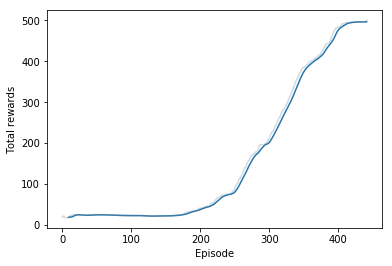

In [18]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

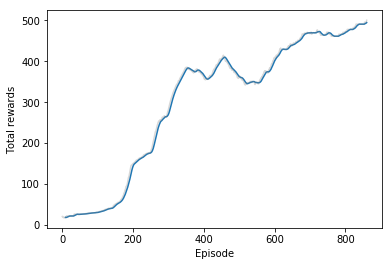

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

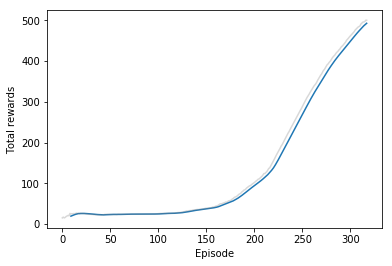

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

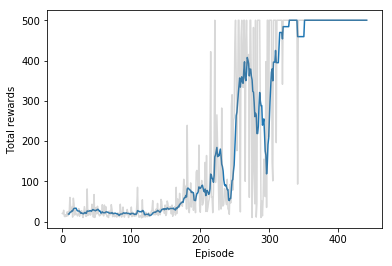

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

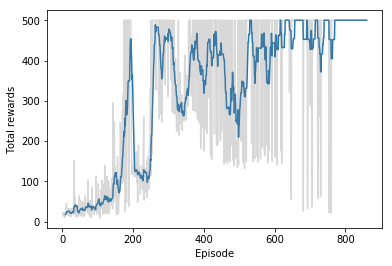

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

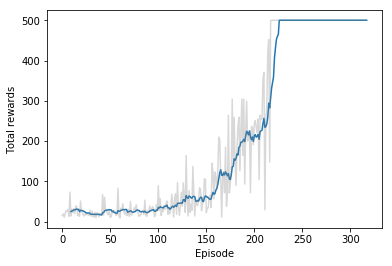

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

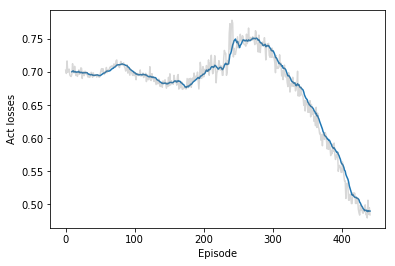

In [20]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Act losses')

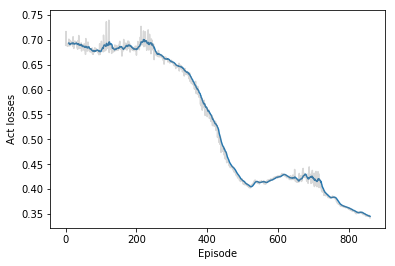

In [19]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Act losses')

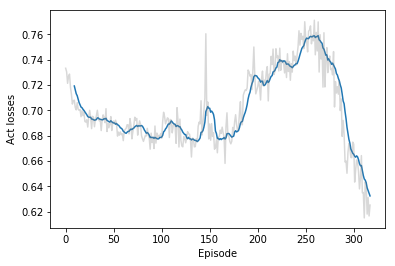

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

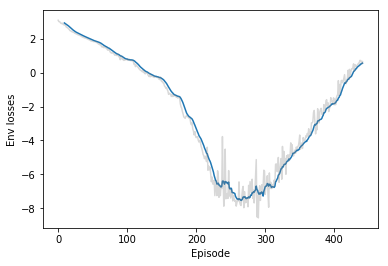

In [21]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Env losses')

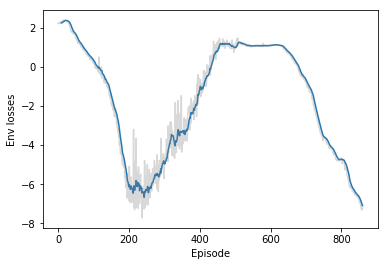

In [20]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Env losses')

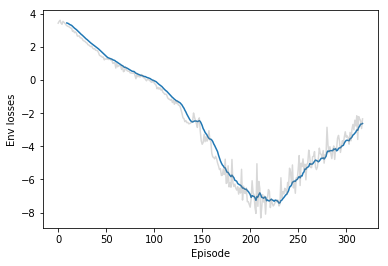

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

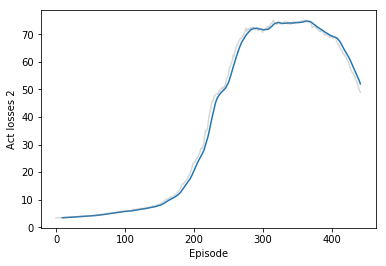

In [22]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

Text(0, 0.5, 'Act losses 2')

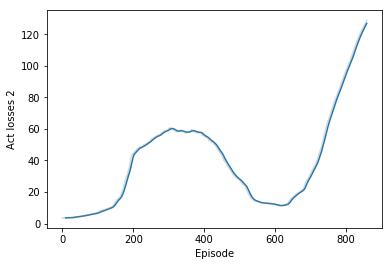

In [21]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

Text(0, 0.5, 'Act losses 2')

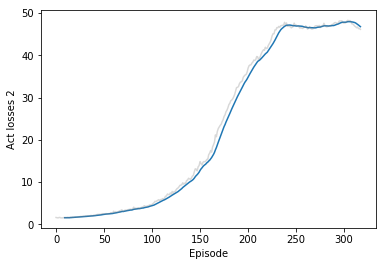

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
